In [1]:
'''
Import necessary packages
'''
import numpy as np
import scipy
import scipy.integrate
import scipy.signal
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
from matplotlib import rc
import pickle
from tqdm import tqdm

# from ip3_ca_ode import *
from ip3_ca_ode_cfg import *
import cfg
import os

save = 'figures/paper_plots/'

#set figure font sizes for readability
font = {'size' : 30,
       'family': 'serif',
       'sans-serif': ['Helvetica']}
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)
color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
               '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [2]:
def report_max_ratios(times=[0, 100, 160, 300], var='c'):
    '''
    Report the max values and ratio of maxes for a variable in the time frames given
    Times should always be a list of 4 integers giving two time intervals to measure maxes from
    Returns:
        ratio of second max to first max (e.g. if second max is 50% of first, return 0.5)
        list of max values reported
        list of index location of max values (for plotting)
    '''
    indices = [np.argmax(cfg.t > t) for t in times]
    if indices[-1] == 0:
        indices[-1] = -1
    y = getattr(cfg, var)
    
    maxes = []
    pos = []
    for i in range(2):
        low = indices[i*2]
        high = indices[i*2 + 1]
        
        ymax = np.max(y[low:high])
        maxpos = np.argmax(y[low:high])
        
        pos.append(maxpos + low)
        maxes.append(ymax)
        
    ratio = maxes[1] / maxes[0]
    return ratio, maxes, pos

def slope_at_index(idx, var='c'):
    y = getattr(cfg, var)
    t2 = cfg.t[idx + 1]
    t1 = cfg.t[idx - 1]
    y2 = y[idx + 1]
    y1 = y[idx - 1]
    return (y2 - y1) / (t2 - t1)

# Double bath desensitizations

Showing experiments demonstrating what it looks like to have different types of desensitization in the GPCR

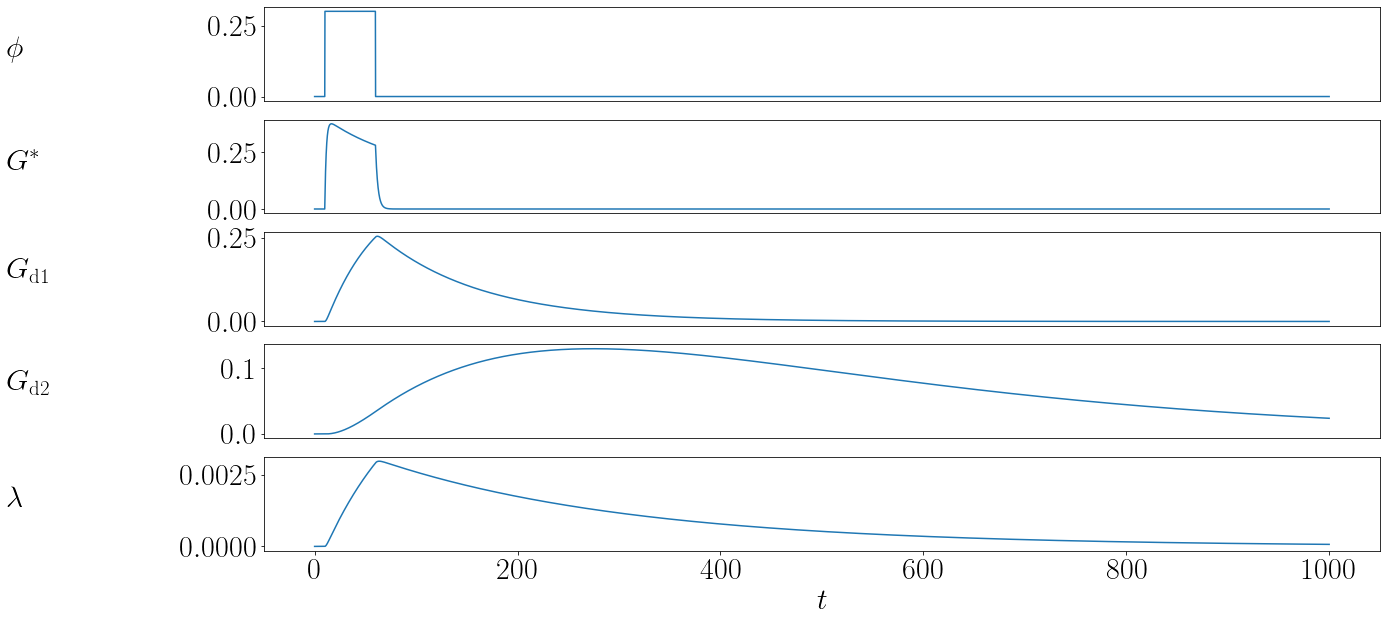

In [3]:
run_experiment()
fig, ax = plt.subplots(5, 1, figsize=(20,10))
plot_experiment_plots(['glut', 'Gstar', 'Gd1', 'Gd2', 'lamb'], ax)

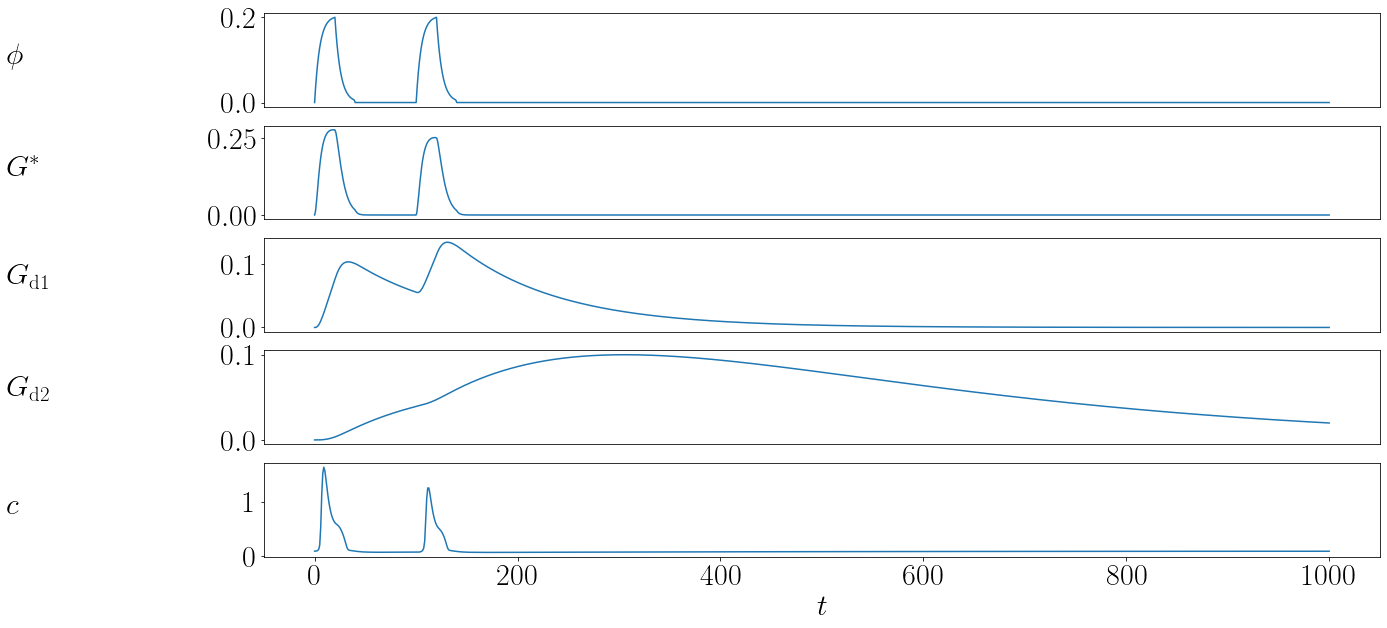

In [59]:
cfg.oscillation_on_duration = 30
cfg.oscillation_off_duration = 60
cfg.r_rise = 0.2
cfg.d_rise = 20
cfg.d_decay = 20
cfg.r_decay = compute_r_decay(0.2, 20)
cfg.A = 0.2
cfg.num_oscillations = 2
fig, ax = plt.subplots(5, 1, figsize=(20,10))
run_experiment('exponential_oscillation', max_step=1)
plot_experiment_plots(['glut', 'Gstar', 'Gd1', 'Gd2', 'c'], ax)

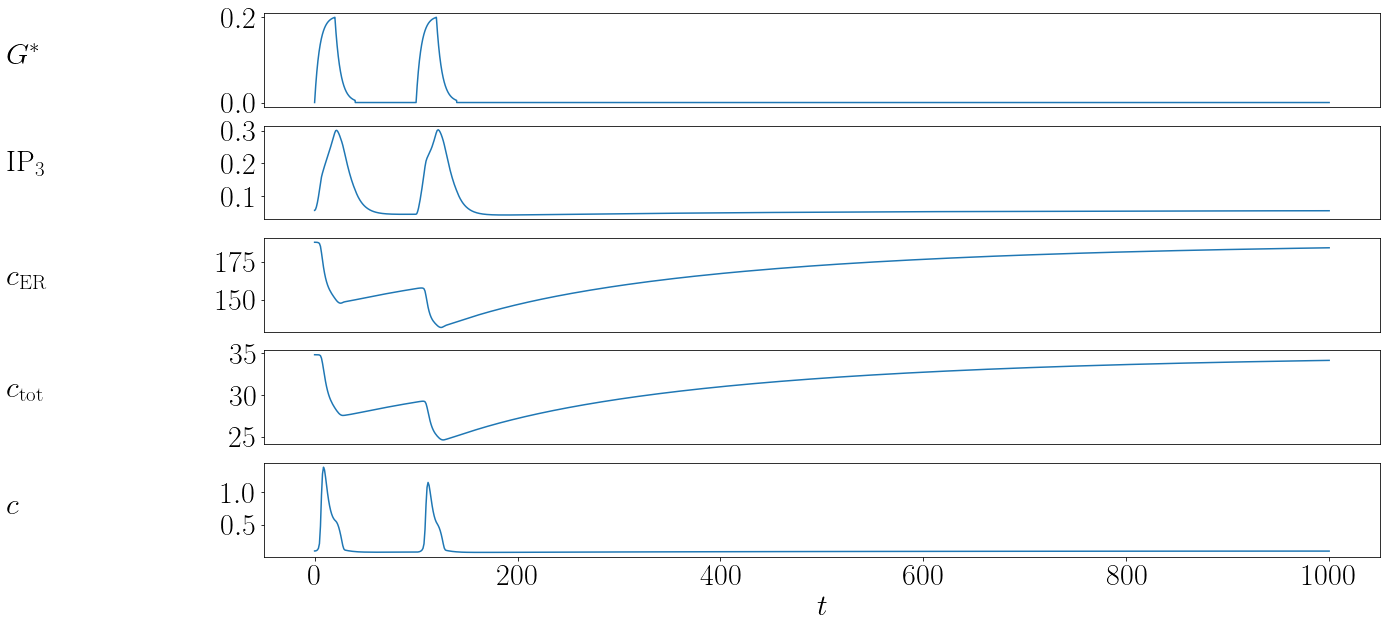

In [75]:
cfg.oscillation_on_duration = 30
cfg.oscillation_off_duration = 60
cfg.r_rise = 0.2
cfg.d_rise = 20
cfg.d_decay = 20
cfg.r_decay = compute_r_decay(0.2, 20)
cfg.A = 0.2
cfg.num_oscillations = 2
fig, ax = plt.subplots(5, 1, figsize=(20,10))
run_Gstar_controlled_experiment('exponential_oscillation', max_step=1)
plot_experiment_plots(['Gstar', 'p', 'c_er', 'c_tot', 'c'], ax)

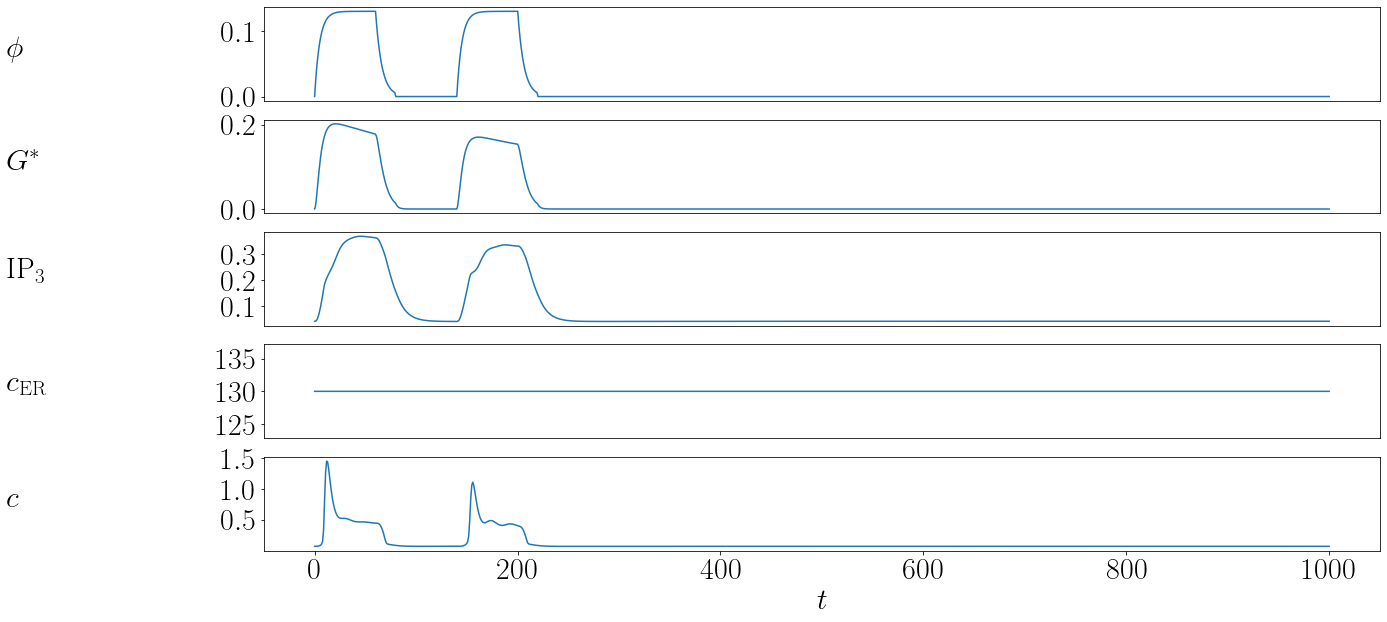

In [179]:
cfg.oscillation_on_duration = 30
cfg.oscillation_off_duration = 60
cfg.r_rise = 0.2
cfg.d_rise = 60
cfg.d_decay = 20
cfg.A = 0.13
cfg.r_decay = compute_r_decay(cfg.A, cfg.d_decay)
cfg.num_oscillations = 2
fig, ax = plt.subplots(5, 1, figsize=(20,10))
run_experiment('exponential_oscillation', max_step=1, fix_c_er=130)
plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)


In [93]:
oscillation_duration = cfg.oscillation_off_duration + cfg.d_rise + cfg.d_decay
t_oscillations = [i * oscillation_duration for i in range(cfg.num_oscillations)]
oscillation_indices = [np.argmax(cfg.t > t) for t in t_oscillations]
c_maxes = []
for i in range(len(oscillation_indices)):
    low = oscillation_indices[i]
    high = oscillation_indices[i+1] if i < len(oscillation_indices) - 1 else -1
    c_max = np.max(cfg.c[low:high])
    c_maxes.append(c_max)

In [94]:
c_maxes

[1.3384046128374665, 1.1689793057611468]

In [95]:
1.16898/1.3384

0.8734160191273161

In [76]:
oscillation_duration = cfg.oscillation_off_duration + cfg.d_rise + cfg.d_decay
t_oscillations = [i * oscillation_duration for i in range(cfg.num_oscillations)]
oscillation_indices = [np.argmax(cfg.t > t) for t in t_oscillations]
c_maxes = []
for i in range(len(oscillation_indices)):
    low = oscillation_indices[i]
    high = oscillation_indices[i+1] if i < len(oscillation_indices) - 1 else -1
    c_max = np.max(cfg.c[low:high])
    c_maxes.append(c_max)

In [77]:
c_maxes

[1.3884582157621639, 1.1530678542357358]

In [78]:
1.15307/1.3885

0.8304429240187252

## Vary oscillation off duration, see effects on calcium ratios

In [182]:
oscillation_off_durations = np.arange(10, 600, 10)
oscillation_on_durations = [20, 60, 120]

all_c_ratios = {}
all_Gstar_ratios = {}

for oscillation_on_duration in oscillation_on_durations:
    cfg.r_rise = 0.2
    cfg.d_rise = oscillation_on_duration / 2
    cfg.d_decay = 20
    cfg.A = 0.13
    cfg.r_decay = compute_r_decay(cfg.A, cfg.d_decay)
    cfg.num_oscillations = 2

    c_ratios = []
    Gstar_ratios = []
    for oscillation_off_duration in tqdm(oscillation_off_durations):
        cfg.oscillation_off_duration = oscillation_off_duration
        oscillation_on_duration = cfg.d_rise + cfg.d_decay
        t_f = (oscillation_on_duration + oscillation_off_duration) * (cfg.num_oscillations - 1) + 30 + oscillation_on_duration
        run_experiment('exponential_oscillation', max_step=0.1, t_f=t_f, fix_c_er=130)

        #compute the c ratios
        oscillation_duration = cfg.oscillation_off_duration + cfg.d_rise + cfg.d_decay
        t_oscillations = [i * oscillation_duration for i in range(cfg.num_oscillations)]
        oscillation_indices = [np.argmax(cfg.t > t) for t in t_oscillations]
        c_maxes = []
        Gstar_maxes = []
        for i in range(len(oscillation_indices)):
            low = oscillation_indices[i]
            high = oscillation_indices[i+1] if i < len(oscillation_indices) - 1 else -1
            c_max = np.max(cfg.c[low:high])
            Gstar_max = np.max(cfg.Gstar[low:high])
            
            Gstar_maxes.append(Gstar_max)
            c_maxes.append(c_max)
        
        c_ratio = c_maxes[1] / c_maxes[0]
        c_ratios.append(c_ratio)
        Gstar_ratio = Gstar_maxes[1] / Gstar_maxes[0]
        Gstar_ratios.append(Gstar_ratio)
        
    all_c_ratios[oscillation_on_duration] = c_ratios
    all_Gstar_ratios[oscillation_on_duration] = Gstar_ratios

100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:54<00:00,  1.93s/it]


In [183]:
oscillation_off_durations = np.arange(10, 600, 10)
oscillation_on_durations = [20, 60, 120]

# all_c_ratios = {}
# all_Gstar_ratios = {}

cfg.kd1 = 0

for oscillation_on_duration in oscillation_on_durations:
    cfg.r_rise = 0.2
    cfg.d_rise = oscillation_on_duration / 2
    cfg.d_decay = 20
    cfg.A = 0.13
    cfg.r_decay = compute_r_decay(cfg.A, cfg.d_decay)
    cfg.num_oscillations = 2

    c_ratios = []
    Gstar_ratios = []
    for oscillation_off_duration in tqdm(oscillation_off_durations):
        cfg.oscillation_off_duration = oscillation_off_duration
        oscillation_on_duration = cfg.d_rise + cfg.d_decay
        t_f = (oscillation_on_duration + oscillation_off_duration) * (cfg.num_oscillations - 1) + 30 + oscillation_on_duration
        run_experiment('exponential_oscillation', max_step=0.1, t_f=t_f, fix_c_er=130)

        #compute the c ratios
        oscillation_duration = cfg.oscillation_off_duration + cfg.d_rise + cfg.d_decay
        t_oscillations = [i * oscillation_duration for i in range(cfg.num_oscillations)]
        oscillation_indices = [np.argmax(cfg.t > t) for t in t_oscillations]
        c_maxes = []
        Gstar_maxes = []
        for i in range(len(oscillation_indices)):
            low = oscillation_indices[i]
            high = oscillation_indices[i+1] if i < len(oscillation_indices) - 1 else -1
            c_max = np.max(cfg.c[low:high])
            Gstar_max = np.max(cfg.Gstar[low:high])
            
            Gstar_maxes.append(Gstar_max)
            c_maxes.append(c_max)
        
        c_ratio = c_maxes[1] / c_maxes[0]
        c_ratios.append(c_ratio)
        Gstar_ratio = Gstar_maxes[1] / Gstar_maxes[0]
        Gstar_ratios.append(Gstar_ratio)
        
    all_c_ratios[str(oscillation_on_duration) + '_d1off'] = c_ratios
    all_Gstar_ratios[str(oscillation_on_duration) + '_d1off'] = Gstar_ratios
    
cfg.kd1 = 0.02

100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [02:01<00:00,  2.06s/it]


In [184]:
oscillation_off_durations = np.arange(10, 600, 10)
oscillation_on_durations = [20, 60, 120]

# all_c_ratios = {}
# all_Gstar_ratios = {}

# cfg.kd1 = 0
cfg.kd2 = 0

for oscillation_on_duration in oscillation_on_durations:
    cfg.r_rise = 0.2
    cfg.d_rise = oscillation_on_duration / 2
    cfg.d_decay = 20
    cfg.A = 0.13
    cfg.r_decay = compute_r_decay(cfg.A, cfg.d_decay)
    cfg.num_oscillations = 2

    c_ratios = []
    Gstar_ratios = []
    for oscillation_off_duration in tqdm(oscillation_off_durations):
        cfg.oscillation_off_duration = oscillation_off_duration
        oscillation_on_duration = cfg.d_rise + cfg.d_decay
        t_f = (oscillation_on_duration + oscillation_off_duration) * (cfg.num_oscillations - 1) + 30 + oscillation_on_duration
        run_experiment('exponential_oscillation', max_step=0.1, t_f=t_f, fix_c_er=130)

        #compute the c ratios
        oscillation_duration = cfg.oscillation_off_duration + cfg.d_rise + cfg.d_decay
        t_oscillations = [i * oscillation_duration for i in range(cfg.num_oscillations)]
        oscillation_indices = [np.argmax(cfg.t > t) for t in t_oscillations]
        c_maxes = []
        Gstar_maxes = []
        for i in range(len(oscillation_indices)):
            low = oscillation_indices[i]
            high = oscillation_indices[i+1] if i < len(oscillation_indices) - 1 else -1
            c_max = np.max(cfg.c[low:high])
            Gstar_max = np.max(cfg.Gstar[low:high])
            
            Gstar_maxes.append(Gstar_max)
            c_maxes.append(c_max)
        
        c_ratio = c_maxes[1] / c_maxes[0]
        c_ratios.append(c_ratio)
        Gstar_ratio = Gstar_maxes[1] / Gstar_maxes[0]
        Gstar_ratios.append(Gstar_ratio)
        
    all_c_ratios[str(oscillation_on_duration) + '_d2off'] = c_ratios
    all_Gstar_ratios[str(oscillation_on_duration) + '_d2off'] = Gstar_ratios
    
# cfg.kd1 = 0.02
cfg.kd2 = 0.6

100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:59<00:00,  2.03s/it]


In [185]:
pickle.dump(all_c_ratios, open('data/plot_data/double_bath_c_ratios_fix_cer_130_fixed_ddecay', 'wb'))
pickle.dump(all_Gstar_ratios, open('data/plot_data/double_bath_Gstar_ratios_fix_cer_130_fixed_ddecay', 'wb'))

In [101]:
all_c_ratios['120_fix'] = c_ratios

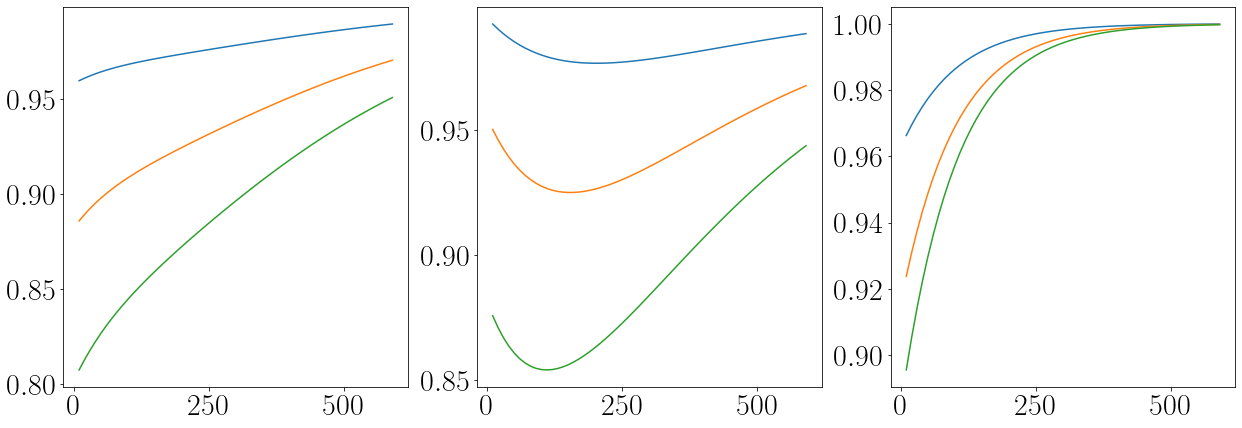

In [180]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7))

ax[0].plot(oscillation_off_durations, all_Gstar_ratios[20])
ax[0].plot(oscillation_off_durations, all_Gstar_ratios[60])
ax[0].plot(oscillation_off_durations, all_Gstar_ratios[120])

ax[1].plot(oscillation_off_durations, all_Gstar_ratios['20.0_d1off'])
ax[1].plot(oscillation_off_durations, all_Gstar_ratios['60.0_d1off'])
ax[1].plot(oscillation_off_durations, all_Gstar_ratios['120.0_d1off'])

ax[2].plot(oscillation_off_durations, all_Gstar_ratios['20.0_d2off'])
ax[2].plot(oscillation_off_durations, all_Gstar_ratios['60.0_d2off'])
ax[2].plot(oscillation_off_durations, all_Gstar_ratios['120.0_d2off'])

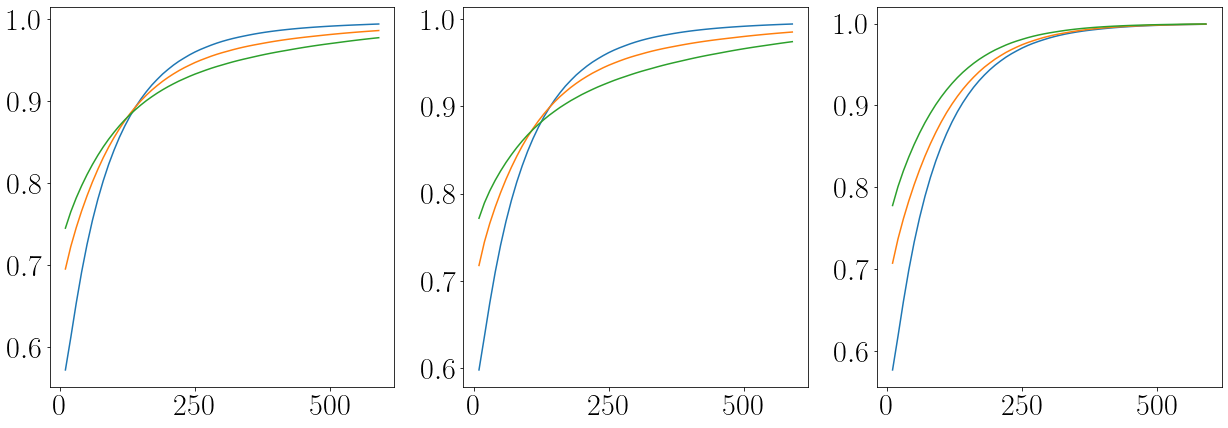

In [181]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7))

ax[0].plot(oscillation_off_durations, all_c_ratios[20])
ax[0].plot(oscillation_off_durations, all_c_ratios[60])
ax[0].plot(oscillation_off_durations, all_c_ratios[120])

ax[1].plot(oscillation_off_durations, all_c_ratios['20.0_d1off'])
ax[1].plot(oscillation_off_durations, all_c_ratios['60.0_d1off'])
ax[1].plot(oscillation_off_durations, all_c_ratios['120.0_d1off'])

ax[2].plot(oscillation_off_durations, all_c_ratios['20.0_d2off'])
ax[2].plot(oscillation_off_durations, all_c_ratios['60.0_d2off'])
ax[2].plot(oscillation_off_durations, all_c_ratios['120.0_d2off'])

### Keeping decay time constant

Fixed decay time so that it doesn't make weird things happen by sort of extending the off time

Note that Gd2 reaches it's max a while after the stimulation is turned off, but Gd1 has a exponential ramp down. Combined, the effect almost has a linear recovery with time. The exact shape of this would depend on parameters

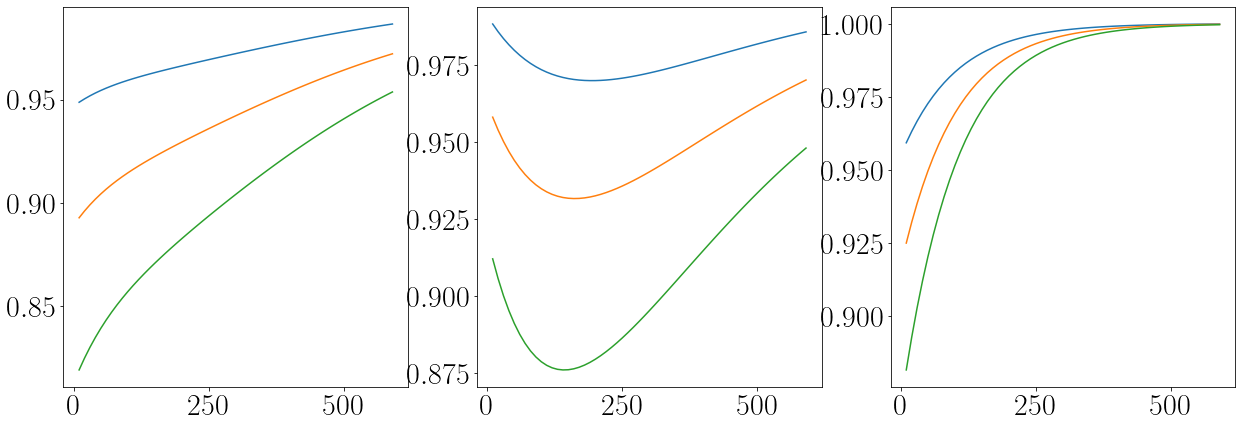

In [188]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7))

ax[0].plot(oscillation_off_durations, all_Gstar_ratios[30])
ax[0].plot(oscillation_off_durations, all_Gstar_ratios[50])
ax[0].plot(oscillation_off_durations, all_Gstar_ratios[80])

ax[1].plot(oscillation_off_durations, all_Gstar_ratios['30.0_d1off'])
ax[1].plot(oscillation_off_durations, all_Gstar_ratios['50.0_d1off'])
ax[1].plot(oscillation_off_durations, all_Gstar_ratios['80.0_d1off'])

ax[2].plot(oscillation_off_durations, all_Gstar_ratios['30.0_d2off'])
ax[2].plot(oscillation_off_durations, all_Gstar_ratios['50.0_d2off'])
ax[2].plot(oscillation_off_durations, all_Gstar_ratios['80.0_d2off'])

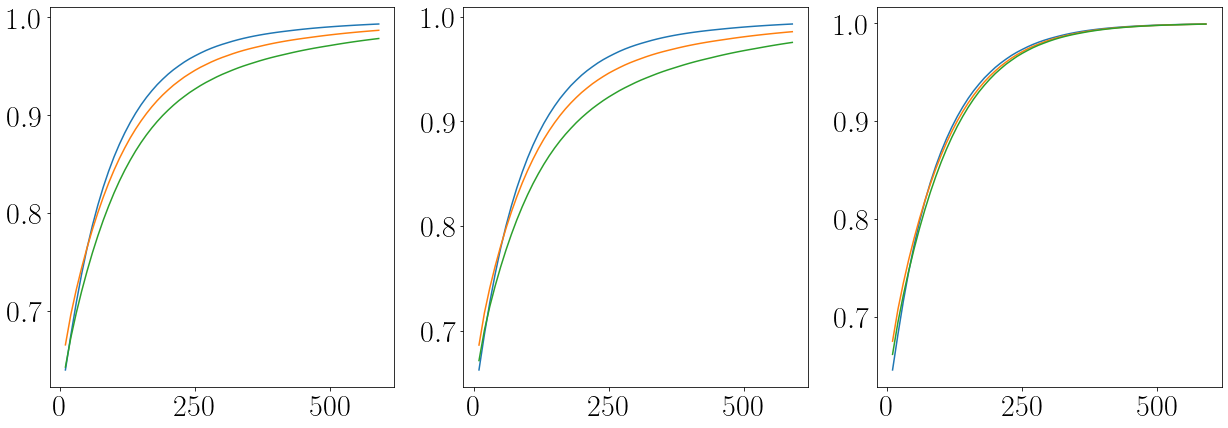

In [189]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7))

ax[0].plot(oscillation_off_durations, all_c_ratios[30])
ax[0].plot(oscillation_off_durations, all_c_ratios[50])
ax[0].plot(oscillation_off_durations, all_c_ratios[80])

ax[1].plot(oscillation_off_durations, all_c_ratios['30.0_d1off'])
ax[1].plot(oscillation_off_durations, all_c_ratios['50.0_d1off'])
ax[1].plot(oscillation_off_durations, all_c_ratios['80.0_d1off'])

ax[2].plot(oscillation_off_durations, all_c_ratios['30.0_d2off'])
ax[2].plot(oscillation_off_durations, all_c_ratios['50.0_d2off'])
ax[2].plot(oscillation_off_durations, all_c_ratios['80.0_d2off'])

## Time to full desensitization

One way we can check for the existence of a slow desensitization is by looking for how long it takes for maximum desensitization to be reached

Here we are attempting an experimental protocol that would be easier to implement in the lab setting. 

1. Variable length first bath
2. 60 seconds wash
3. Additionaly 60 seconds second bath

The goal is to see how the maximum calcium reached is affected in the second bath

In [25]:
first_ons = np.arange(10, 600, 10)

all_c_ratios = {}
all_Gstar_ratios = {}

for cond in ['normal', 'd1_off', 'd2_off']:
    all_c_ratios[cond] = []
    all_Gstar_ratios[cond] = []

for first_on in tqdm(first_ons):
    cfg.custom_input_times = [0, 10, 10+first_on, 70+first_on, 130+first_on]
    cfg.custom_input_vals = [0, 0.4, 0, 0.4, 0]
    
    for cond in ['normal', 'd1_off', 'd2_off']:
        if cond == 'd1_off':
            cfg.kd1 = 0
        elif cond == 'd2_off':
            cfg.kd2 = 0
        sol = run_experiment('custom', max_step=0.1, t_f=140+first_on)

        #compute the c ratios
        t_indices = [np.argmax(cfg.t > t) for t in [10, 10+first_on, 70+first_on, 130+first_on]]

        c_maxes = []
        Gstar_maxes = []
        for i in range(2):
            low = t_indices[i*2]
            high = t_indices[i*2 + 1]

            c_max = np.max(cfg.c[low:high])
            Gstar_max = np.max(cfg.Gstar[low:high])

            Gstar_maxes.append(Gstar_max)
            c_maxes.append(c_max)
            
        cfg.kd1 = 0.02
        cfg.kd2 = 0.6

        c_ratio = c_maxes[1] / c_maxes[0]
        all_c_ratios[cond].append(c_ratio)
        Gstar_ratio = Gstar_maxes[1] / Gstar_maxes[0]
        all_Gstar_ratios[cond].append(Gstar_ratio)


 98%|████████████████████████████████████████████████████████████████████████████████▌ | 58/59 [05:48<00:06,  6.00s/it]


KeyboardInterrupt: 

### interpolate between Gd1 and Gd2 to see how the calcium response curves are affected

In [31]:
pickle.dump([first_ons, all_c_ratios, all_Gstar_ratios], open('data/plot_data/first_bath_length_changed_ratios', 'wb'))

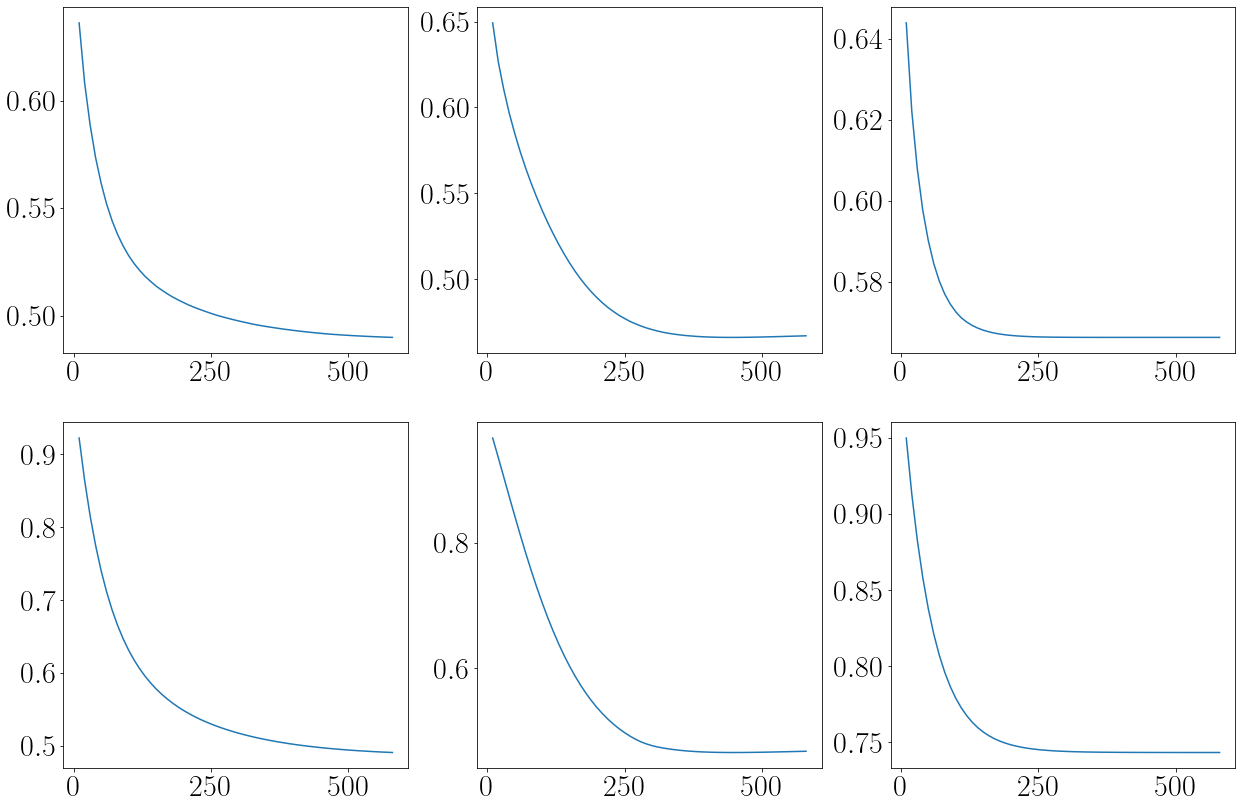

In [32]:
first_ons, all_c_ratios, all_Gstar_ratios = pickle.load(open('data/plot_data/first_bath_length_changed_ratios', 'rb'))
fig, ax = plt.subplots(2, 3, figsize=(21, 14))
for i in range(2):
    for j, cond in enumerate(['normal', 'd1_off', 'd2_off']):
        if i == 0:
            ax[i, j].plot(first_ons, all_c_ratios[cond])
        else:
            ax[i, j].plot(first_ons, all_Gstar_ratios[cond])

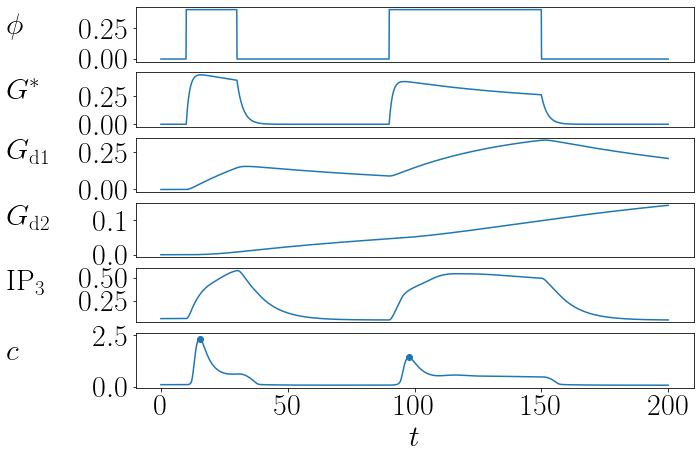

In [19]:
fig, ax = plt.subplots(6, 1, figsize=(10, 7))

for i, first_on in enumerate([20]):
    cfg.custom_input_times = [0, 10, 10+first_on, 70+first_on, 130+first_on]
    cfg.custom_input_vals = [0, 0.4, 0, 0.4, 0]
    
    
    sol = run_experiment('custom', t_f=200)
    plot_experiment_plots(['glut', 'Gstar', 'Gd1', 'Gd2', 'p', 'c'], ax)
    
    t_indices = [np.argmax(cfg.t > t) for t in [10, 10+first_on, 70+first_on, 130+first_on]]
    
    c_maxes = []
    Gstar_maxes = []
    max_pos = []
    for i in range(2):
        low = t_indices[i*2]
        high = t_indices[i*2 + 1]
        
        c_max = np.max(cfg.c[low:high])
        Gstar_max = np.max(cfg.Gstar[low:high])

        Gstar_maxes.append(Gstar_max)
        c_maxes.append(c_max)
        max_pos.append(np.argmax(cfg.c[low:high]) + low)
    ax[5].scatter(cfg.t[np.array(max_pos)], c_maxes)
        

    cfg.kd1 = 0.02
    cfg.kd2 = 0.6

    c_ratio = c_maxes[1] / c_maxes[0]
    all_c_ratios[cond].append(c_ratio)
    Gstar_ratio = Gstar_maxes[1] / Gstar_maxes[0]
    all_Gstar_ratios[cond].append(Gstar_ratio)

In [ ]:
slider = np.linspace(0, 1, 10)

In [33]:
first_ons = np.arange(10, 600, 20)
slider = np.linspace(0, 1, 11)

all_c_ratios = {}
all_Gstar_ratios = {}

for mod in slider:
    all_c_ratios[mod] = []
    all_Gstar_ratios[mod] = []

for first_on in tqdm(first_ons):
    cfg.custom_input_times = [0, 10, 10+first_on, 70+first_on, 130+first_on]
    cfg.custom_input_vals = [0, 0.4, 0, 0.4, 0]
    
    for mod in slider:
        cfg.kd1 = cfg.kd1 * mod
        cfg.kd2 = cfg.kd2 * (1 - mod)
        sol = run_experiment('custom', max_step=0.1, t_f=140+first_on)

        #compute the c ratios
        t_indices = [np.argmax(cfg.t > t) for t in [10, 10+first_on, 70+first_on, 130+first_on]]

        c_maxes = []
        Gstar_maxes = []
        for i in range(2):
            low = t_indices[i*2]
            high = t_indices[i*2 + 1]

            c_max = np.max(cfg.c[low:high])
            Gstar_max = np.max(cfg.Gstar[low:high])

            Gstar_maxes.append(Gstar_max)
            c_maxes.append(c_max)
            
        cfg.kd1 = 0.02
        cfg.kd2 = 0.6

        c_ratio = c_maxes[1] / c_maxes[0]
        all_c_ratios[mod].append(c_ratio)
        Gstar_ratio = Gstar_maxes[1] / Gstar_maxes[0]
        all_Gstar_ratios[mod].append(Gstar_ratio)


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [10:46<00:00, 21.55s/it]


In [37]:
pickle.dump([first_ons, slider, all_c_ratios, all_Gstar_ratios], open('data/plot_data/slider_first_bath_length_changed_ratios', 'wb'))

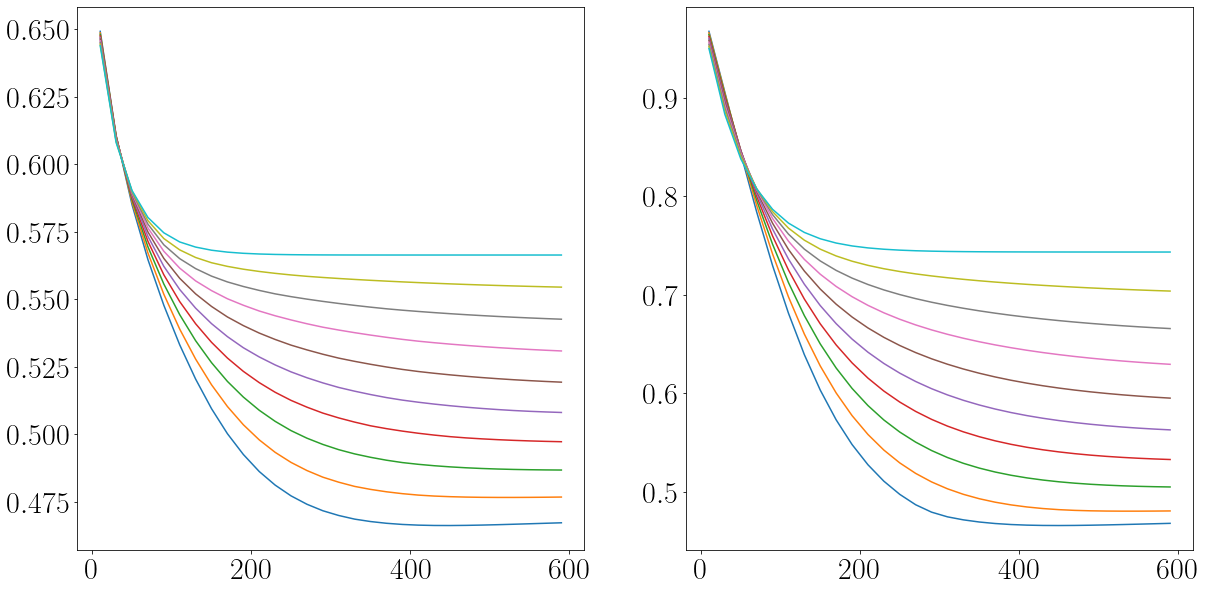

In [116]:
first_ons, slider, all_c_ratios, all_Gstar_ratios = pickle.load(open('data/plot_data/slider_first_bath_length_changed_ratios', 'rb'))

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for mod in slider:
    ax[0].plot(first_ons, all_c_ratios[mod])
    ax[1].plot(first_ons, all_Gstar_ratios[mod])

In [117]:
slider

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

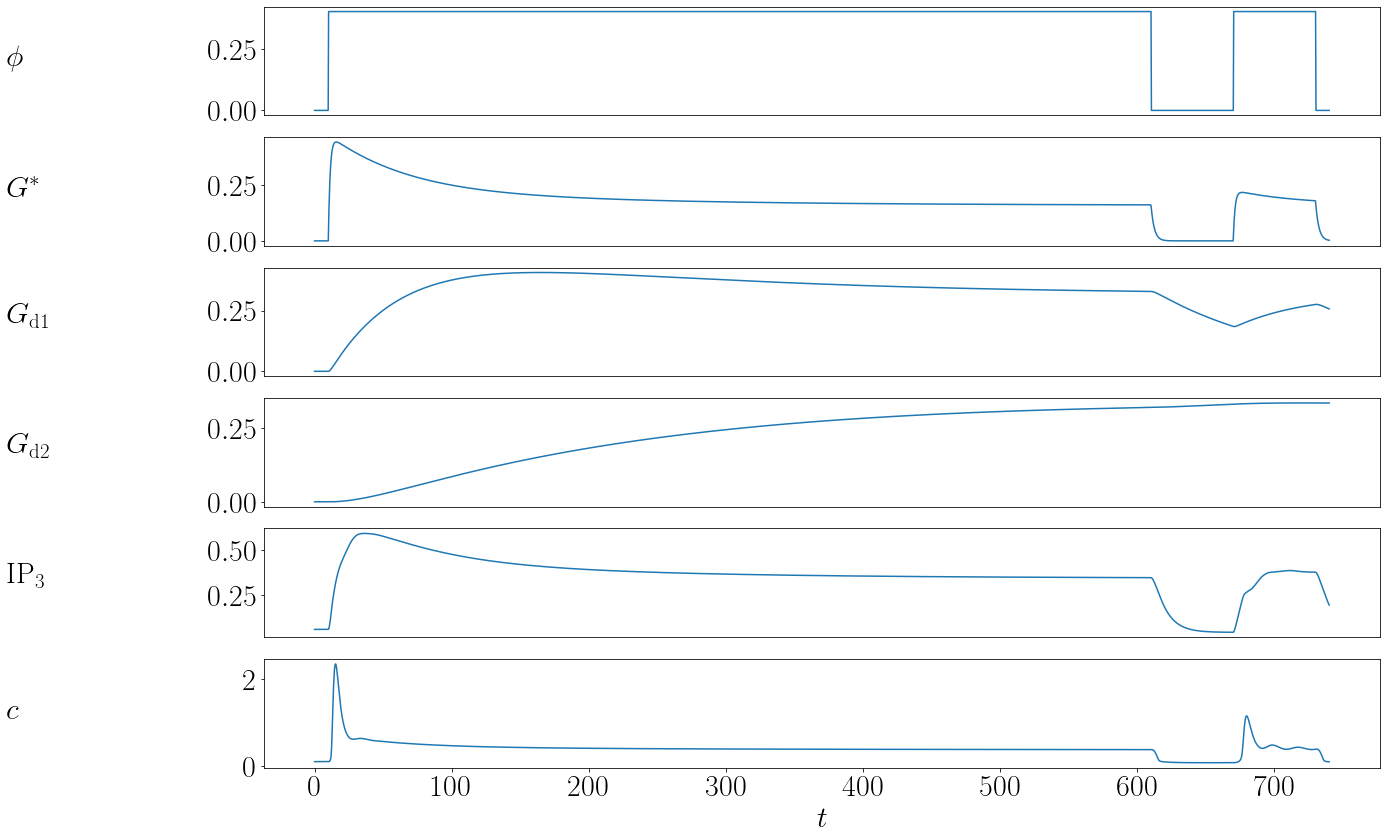

In [118]:
cfg.custom_input_times = [0, 10, 610, 670, 730]
cfg.custom_input_vals = [0, 0.4, 0, 0.4, 0]
sol = run_experiment('custom', t_f=740, max_step=0.3)
fig, ax = plt.subplots(6, 1, figsize=(20, 14))
plot_experiment_plots(['glut', 'Gstar', 'Gd1', 'Gd2', 'p', 'c'], ax)

### Double bath protocols

Here we run double baths with a first bath of 60s (only Gd1 has time to form) or 600s (Gd2 can saturate), followed by a rest of 60s, 240s, or 600s (both Gd1/Gd2 not recovered, Gd1 recovered, both recovered), followed by finally a bath of 60s to test desensitization (as measured by change in calcium peak ratio). The idea is to try to distinguish what desensitization is present (Gd1/Gd2) depending on the bath and rest protocol.

Ideally there is a combination of protocols that allows for the greatest distinction between Gd1 and Gd2

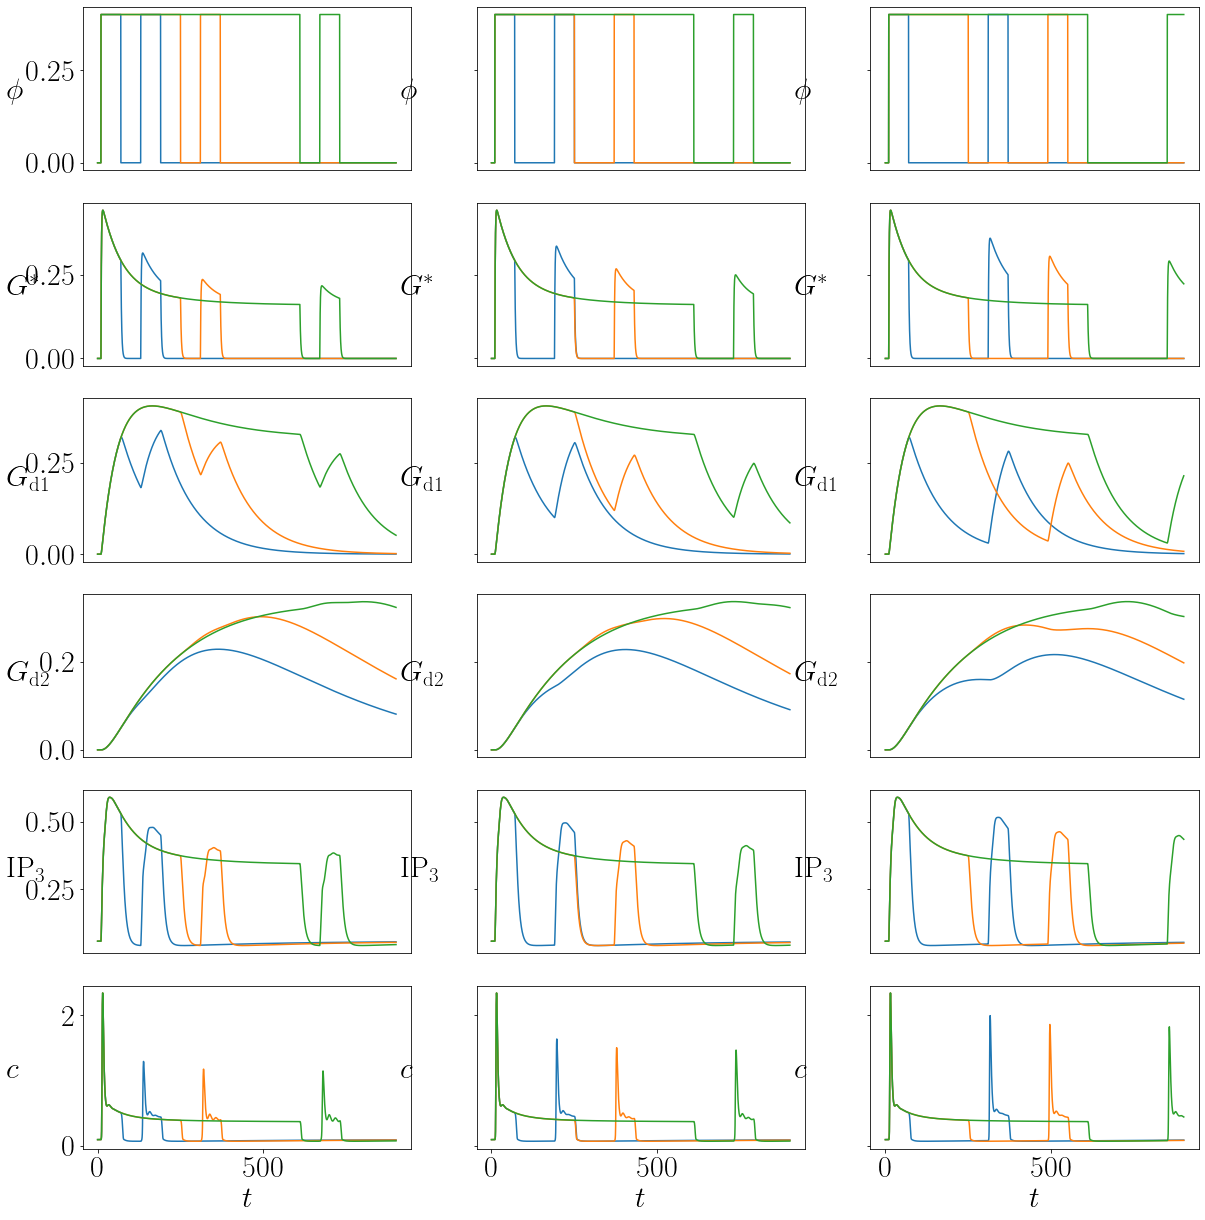

In [119]:
ons = [60, 240, 600]
offs = [60, 120, 240]
fig, ax = plt.subplots(6, 3, sharey='row', figsize=(20, 21))
for on in ons:
    for i, off in enumerate(offs):
        cfg.custom_input_times = [0, 10, 10+on, 10+on+off, 70+on+off]
        cfg.custom_input_vals = [0, 0.4, 0, 0.4, 0]
        sol = run_experiment('custom', max_step=0.2, t_f=900)
        plot_experiment_plots(['glut', 'Gstar', 'Gd1', 'Gd2', 'p', 'c'], ax[:, i])
        

C:\Users\Andy\Desktop\Work\Utah\Projects\Epilepsy Astrocytes\ip3_ca_ode_cfg.py:240: RuntimeWarning: invalid value encountered in double_scalars
  J_serca = cfg.v_serca * (c**1.75) / (c**1.75 + cfg.k_serca**1.75)
C:\Users\Andy\Desktop\Work\Utah\Projects\Epilepsy Astrocytes\ip3_ca_ode_cfg.py:240: RuntimeWarning: invalid value encountered in double_scalars
  J_serca = cfg.v_serca * (c**1.75) / (c**1.75 + cfg.k_serca**1.75)
C:\Users\Andy\Desktop\Work\Utah\Projects\Epilepsy Astrocytes\ip3_ca_ode_cfg.py:240: RuntimeWarning: invalid value encountered in double_scalars
  J_serca = cfg.v_serca * (c**1.75) / (c**1.75 + cfg.k_serca**1.75)
C:\Users\Andy\Desktop\Work\Utah\Projects\Epilepsy Astrocytes\ip3_ca_ode_cfg.py:240: RuntimeWarning: invalid value encountered in double_scalars
  J_serca = cfg.v_serca * (c**1.75) / (c**1.75 + cfg.k_serca**1.75)
C:\Users\Andy\Desktop\Work\Utah\Projects\Epilepsy Astrocytes\ip3_ca_ode_cfg.py:240: RuntimeWarning: invalid value encountered in double_scalars
  J_serc

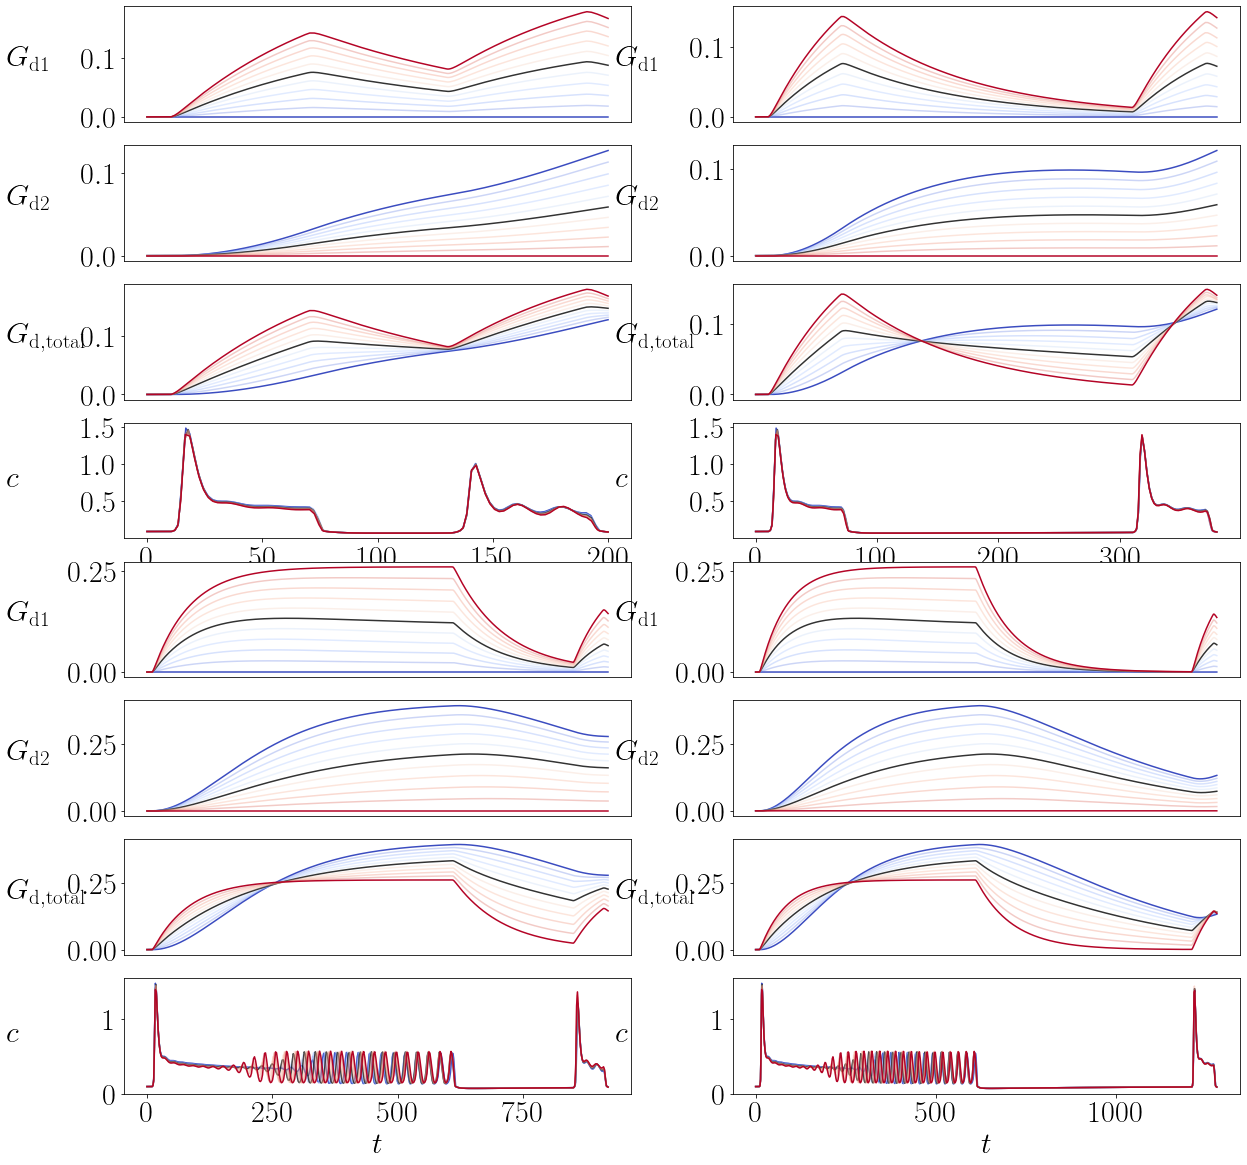

In [12]:
protocols = [
    [60, 60], #short first bath, short rest should still see heavy desensitization
    [60, 240], #short first bath, medium rest should see Gd1 recovered
    [600, 240], #long first bath, medium rest should see Gd1 recovered, but Gd2 still strong
    [600, 600], #long first bath, long rest should see full recovery
]
protocol_ratios = [[], [], [], []]
cmap = matplotlib.cm.get_cmap('coolwarm')

fig, ax = plt.subplots(8, 2, figsize=(20, 20))
slider = np.linspace(0, 1, 11)

labels = ['Gd2', 'Both', 'Gd1']
label_count = 0

for i, protocol in enumerate(protocols):
    x = i % 2
    y = int(np.floor(i / 2))
    
    for mod in slider:
        if mod == 0 or mod == 0.5 or mod == 1:
            alpha = 1
#             label = labels[label_count]
#             label_count += 1
        else:
            alpha = 0.3
            label = None

        if mod == 0.5:
            alpha = 0.8
            color = 'k'
        else:
            color = cmap(mod)
        cfg.kd1 = cfg.kd1 * mod
        cfg.kd2 = cfg.kd2 * (1 - mod)
        
        first = protocol[0]
        rest = protocol[1]
        cfg.custom_input_times = [0, 10, 10+first, 10+first+rest, 70+first+rest]
        cfg.custom_input_vals = [0, 0.1, 0, 0.1, 0]
        ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]

        sol = run_experiment('custom', t_f=80+first+rest, max_step=2)
        plot_experiment_plots(['Gd1', 'Gd2', 'Gd', 'c'], axs=ax[(y*4):(y*4+4), x], plot_input=False, color=color, alpha=alpha)
        
        cfg.kd1 = 0.02
        cfg.kd2 = 0.6
        ratio, _, _ = report_max_ratios(ratio_times)
        protocol_ratios[i].append(ratio)


In [30]:
protocols = [
    [60, 60], #short first bath, short rest should still see heavy desensitization
    [60, 240], #short first bath, medium rest should see Gd1 recovered
    [600, 240], #long first bath, medium rest should see Gd1 recovered, but Gd2 still strong
    [600, 600], #long first bath, long rest should see full recovery
]
protocol_ratios = [[], [], [], []]
gs_breaks_lr = [[0.05, 0.45], [0.55, 0.95]] #left right
gs_breaks_tb = [[0.95, 0.55], [0.45, 0.05]] #top bottom
gs_points = []
for i in range(4):
    x = i % 2
    y = int(np.floor(i / 2))
    left_right = gs_breaks_lr[x]
    up_down = gs_breaks_tb[y]
    gs_points.append([left_right[0], left_right[1], up_down[0], up_down[1]])

cmap = matplotlib.cm.get_cmap('coolwarm')

# fig, ax = plt.subplots(8, 2, figsize=(20, 20))
fig = plt.figure(constrained_layout=False, figsize=(20, 20))
slider = np.linspace(0, 1, 11)

labels = ['Gd2', 'Both', 'Gd1']
label_count = 0

for glut in [0.1, 0.2, 0.4]:
    for i, protocol in enumerate(protocols):
        gs_point = gs_points[i]
#         gs = fig.add_gridspec(nrows=4, ncols=2, left=gs_point[0], right=gs_point[1],
#                              top=gs_point[2], bottom=gs_point[3])

        for mod in slider:
            if mod == 0 or mod == 0.5 or mod == 1:
                alpha = 1
    #             label = labels[label_count]
    #             label_count += 1
            else:
                alpha = 0.3
                label = None

            if mod == 0.5:
                alpha = 0.8
                color = 'k'
            else:
                color = cmap(mod)
            cfg.kd1 = cfg.kd1 * mod
            cfg.kd2 = cfg.kd2 * (1 - mod)

            first = protocol[0]
            rest = protocol[1]
            cfg.custom_input_times = [0, 10, 10+first, 10+first+rest, 70+first+rest]
            cfg.custom_input_vals = [0, glut, 0, glut, 0]
            ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]

            add_xlabel = int(np.floor(i / 2)) == 1
            add_ylabel = (i % 2) == 0

            sol = run_experiment('custom', t_f=80+first+rest, max_step=0.1)
#             axs = [fig.add_subplot(gs[i, 0]) for i in range(4)]
#             plot_experiment_plots(['Gd1', 'Gd2', 'Gd', 'c'], axs=axs, plot_input=False, color=color, alpha=alpha,
#                                  add_xlabel=add_xlabel, add_ylabels=add_ylabel)
#             axs[0].set_title('{}s on, {}s off'.format(protocol[0], protocol[1]))

            cfg.kd1 = 0.02
            cfg.kd2 = 0.6
            ratio, _, _ = report_max_ratios(ratio_times)
            protocol_ratios[i].append(ratio)

            save_experiment('double_bath/glut_{}_onoff_{}_{}_mod_{}'.format(glut, protocol[0], protocol[1], round(mod, 1)), verbose=False)

#         ax = fig.add_subplot(gs[0:2, 1])
#         ax.scatter(slider, protocol_ratios[i], c=slider, cmap='coolwarm')

# plt.savefig('figures/poster_plots/double_bath_protocols_glut_0.1.png', bbox_inches='tight')


<Figure size 1440x1440 with 0 Axes>

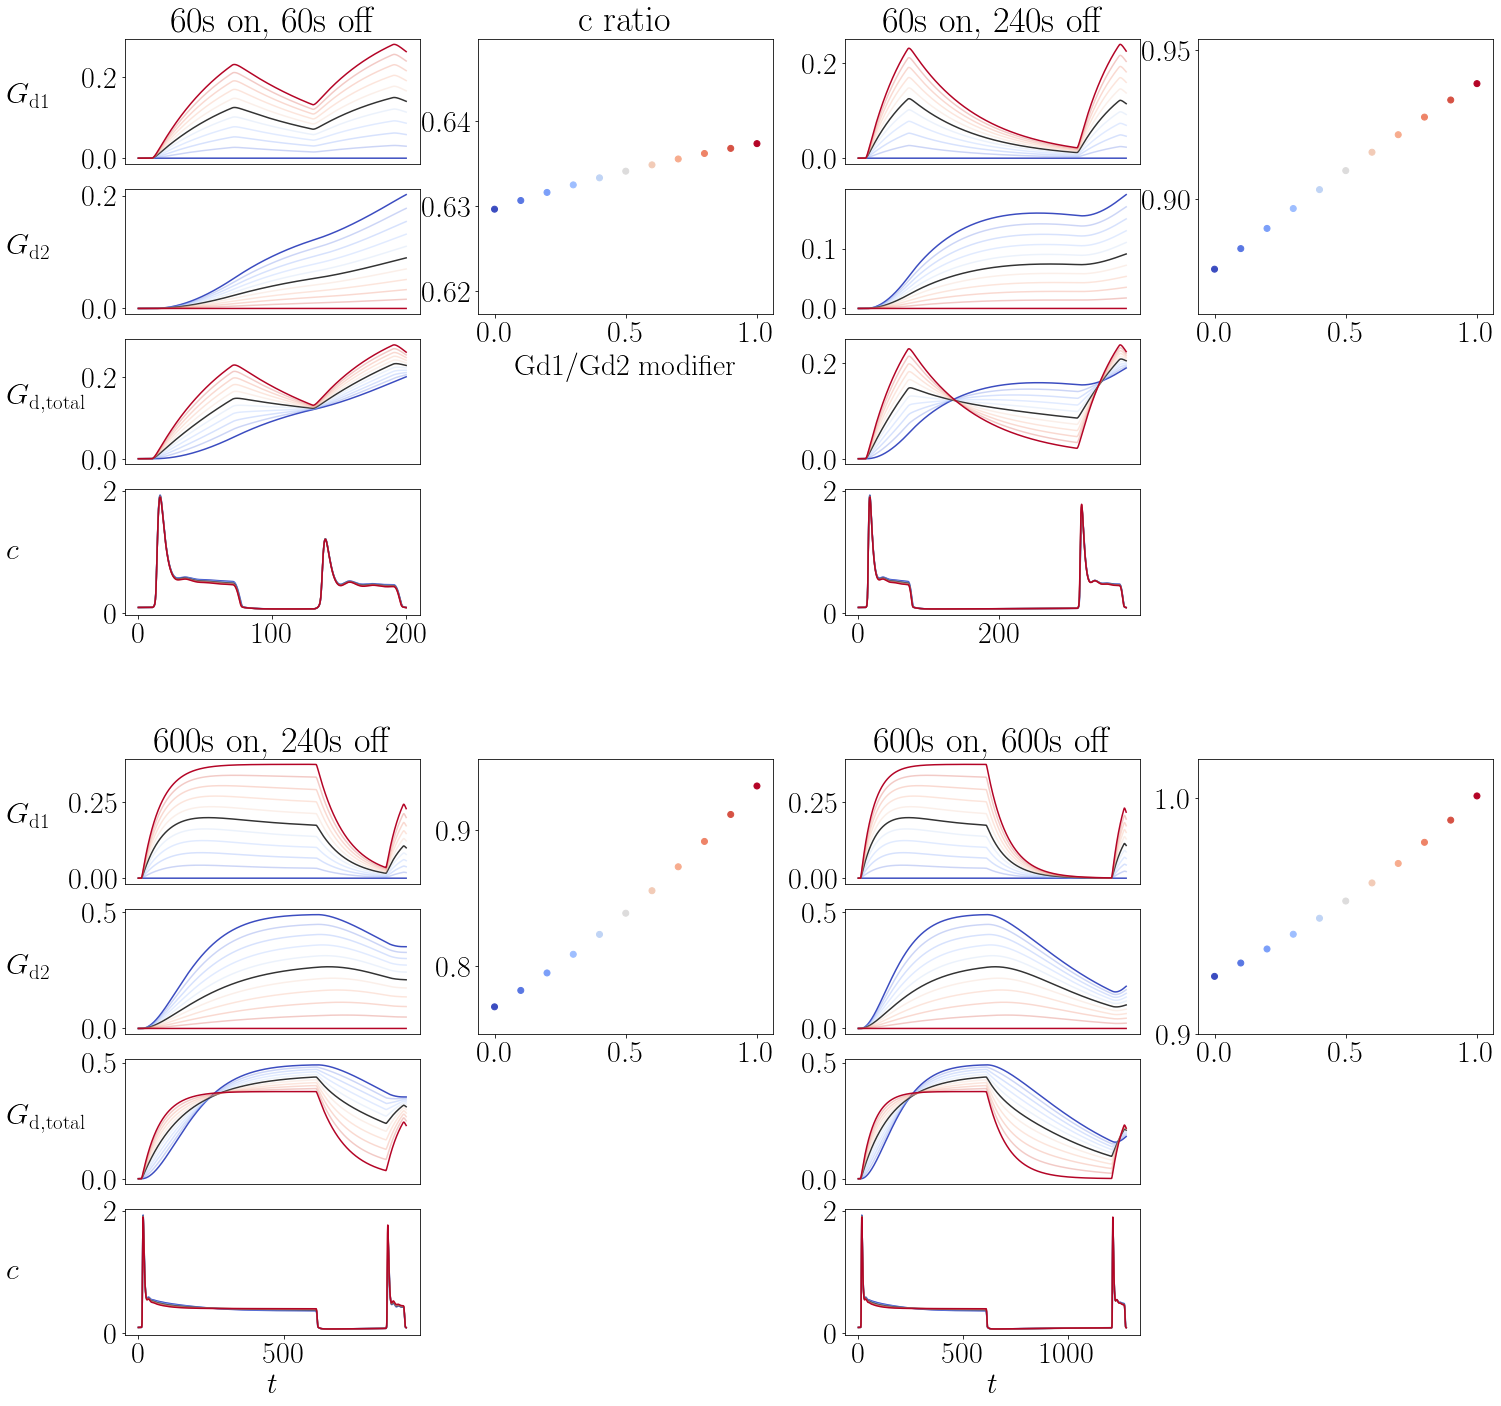

In [72]:
slider = np.linspace(0, 1, 11)
# gluts = [0.1, 0.2, 0.4]
glut = 0.2
protocols = [
    [60, 60], #short first bath, short rest should still see heavy desensitization
    [60, 240], #short first bath, medium rest should see Gd1 recovered
    [600, 240], #long first bath, medium rest should see Gd1 recovered, but Gd2 still strong
    [600, 600], #long first bath, long rest should see full recovery
]
fig = plt.figure(constrained_layout=False, figsize=(20, 20))
cmap = matplotlib.cm.get_cmap('coolwarm')
yticks = [False, [0.9, 0.95], False, [0.9, 1.0]]

#spacing for gridspec
gs_breaks_lr = [[0, 0.45], [0.5, 0.95]] #left right
gs_breaks_tb = [[0.95, 0.55], [0.45, 0.05]] #top bottom
gs_points = []
for i in range(4):
    x = i % 2
    y = int(np.floor(i / 2))
    left_right = gs_breaks_lr[x]
    up_down = gs_breaks_tb[y]
    gs_points.append([left_right[0], left_right[1], up_down[0], up_down[1]])


for i, protocol in enumerate(protocols):
# for i, protocol in enumerate([protocols[0]]):
    first = protocol[0]
    rest = protocol[1]
    ratios = []
    
    gs_point = gs_points[i]
    gs = fig.add_gridspec(nrows=4, ncols=2, left=gs_point[0], right=gs_point[1],
                         top=gs_point[2], bottom=gs_point[3], wspace=0.2)
    axs = [fig.add_subplot(gs[i, 0]) for i in range(4)]

    for mod in slider:
#         print('double_bath/glut_{}_onoff_{}_{}_mod_{}'.format(glut, protocol[0], protocol[1], round(mod, 1)))
        load_experiment('double_bath/glut_{}_onoff_{}_{}_mod_{}'.format(glut, protocol[0], protocol[1], round(mod, 1)), verbose=False)
        

        if mod == 0 or mod == 0.5 or mod == 1:
            alpha = 1
        else:
            alpha = 0.3
            label = None

        if mod == 0.5:
            alpha = 0.8
            color = 'k'
        else:
            color = cmap(mod)
        
        
        ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]

        add_xlabel = int(np.floor(i / 2)) == 1
        add_ylabel = (i % 2) == 0
        
        plot_experiment_plots(['Gd1', 'Gd2', 'Gd', 'c'], axs=axs, plot_input=False, color=color, alpha=alpha,
                             add_xlabel=add_xlabel, add_ylabels=add_ylabel, ylabel_padding=[-0.4, 0.4])
        axs[0].set_title('{}s on, {}s off'.format(protocol[0], protocol[1]))

        ratio, _, _ = report_max_ratios(ratio_times)
        ratios.append(ratio)
    
    ax = fig.add_subplot(gs[0:2, 1])
    ax.scatter(slider, ratios, c=slider, cmap='coolwarm')
    if yticks[i]:
        ax.set_yticks(yticks[i])
    if i == 0:
        ax.set_title('c ratio')
        ax.set_xlabel('Gd1/Gd2 modifier')
plt.savefig('figures/poster_plots/double_bath_protocols_glut_0.2.png', bbox_inches='tight')



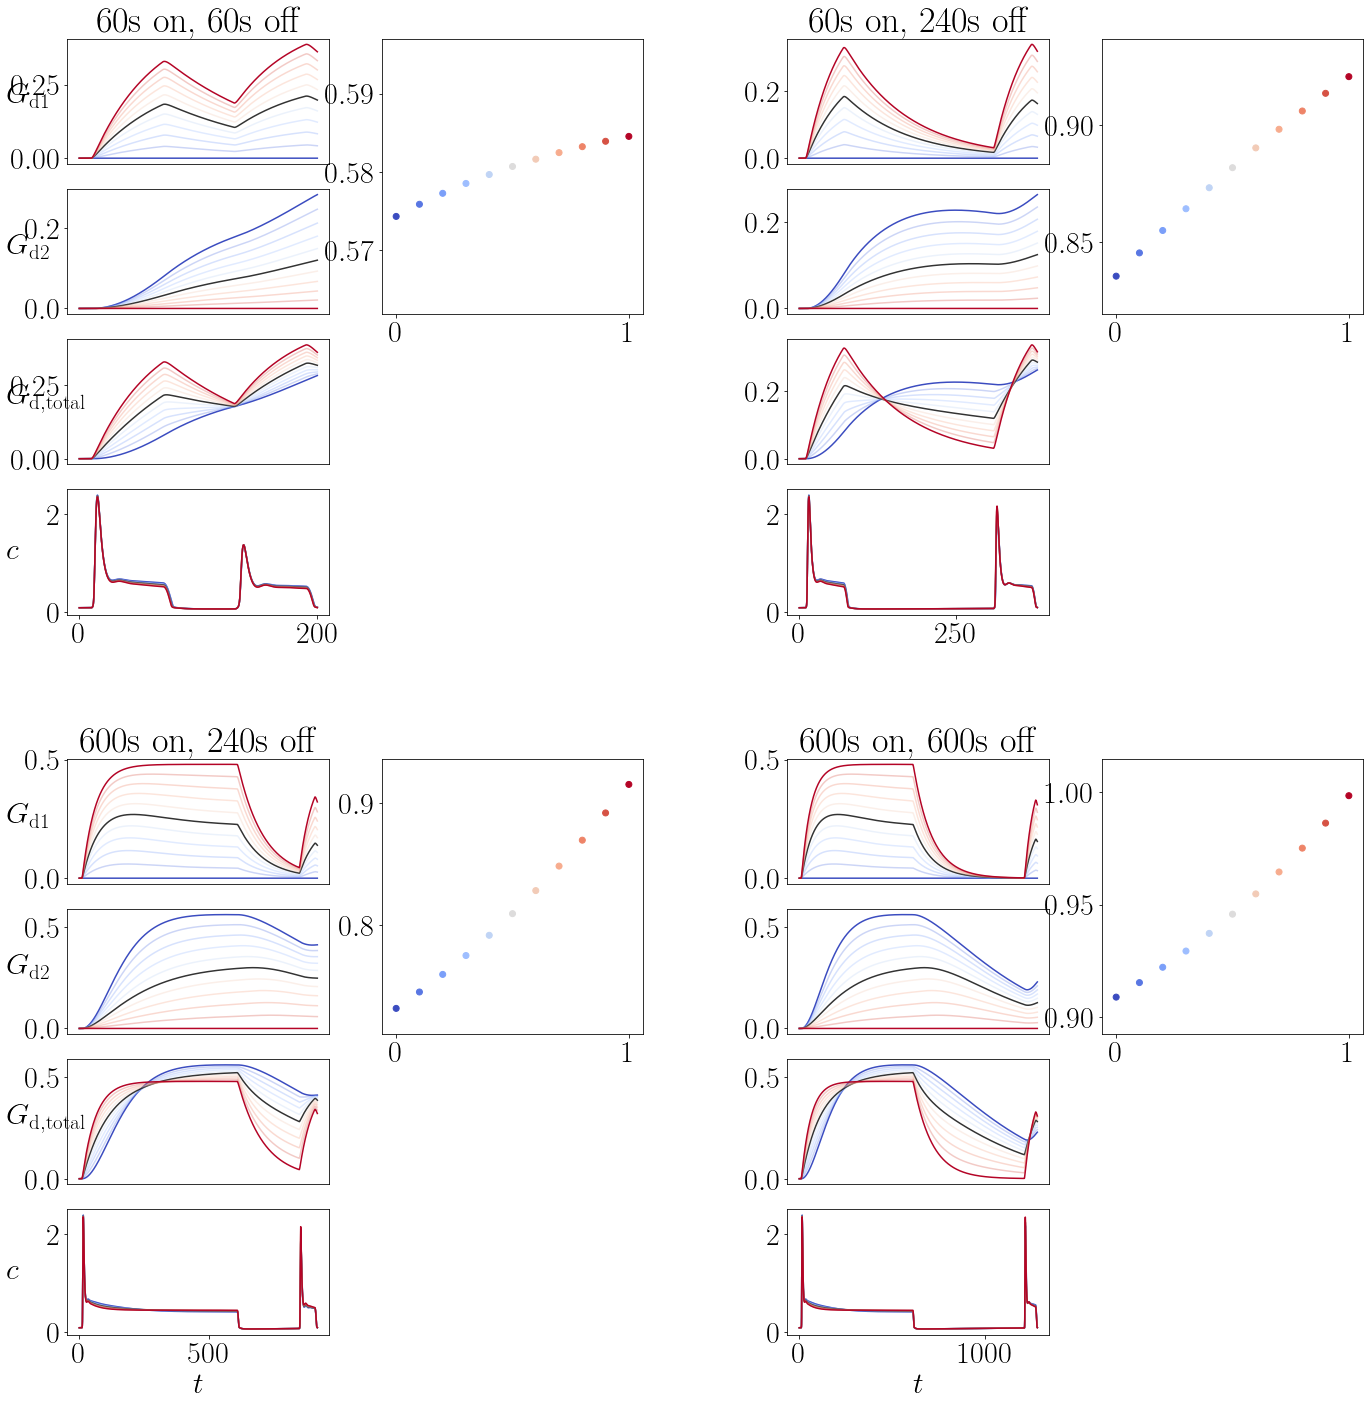

In [16]:
slider = np.linspace(0, 1, 11)
# gluts = [0.1, 0.2, 0.4]
glut = 0.4
protocols = [
    [60, 60], #short first bath, short rest should still see heavy desensitization
    [60, 240], #short first bath, medium rest should see Gd1 recovered
    [600, 240], #long first bath, medium rest should see Gd1 recovered, but Gd2 still strong
    [600, 600], #long first bath, long rest should see full recovery
]
fig = plt.figure(constrained_layout=False, figsize=(20, 20))
cmap = matplotlib.cm.get_cmap('coolwarm')

#spacing for gridspec
gs_breaks_lr = [[0.05, 0.45], [0.55, 0.95]] #left right
gs_breaks_tb = [[0.95, 0.55], [0.45, 0.05]] #top bottom
gs_points = []
for i in range(4):
    x = i % 2
    y = int(np.floor(i / 2))
    left_right = gs_breaks_lr[x]
    up_down = gs_breaks_tb[y]
    gs_points.append([left_right[0], left_right[1], up_down[0], up_down[1]])


for i, protocol in enumerate(protocols):
# for i, protocol in enumerate([protocols[0]]):
    first = protocol[0]
    rest = protocol[1]
    ratios = []
    
    gs_point = gs_points[i]
    gs = fig.add_gridspec(nrows=4, ncols=2, left=gs_point[0], right=gs_point[1],
                         top=gs_point[2], bottom=gs_point[3])
    axs = [fig.add_subplot(gs[i, 0]) for i in range(4)]

    for mod in slider:
#         print('double_bath/glut_{}_onoff_{}_{}_mod_{}'.format(glut, protocol[0], protocol[1], round(mod, 1)))
        load_experiment('double_bath/glut_{}_onoff_{}_{}_mod_{}'.format(glut, protocol[0], protocol[1], round(mod, 1)), verbose=False)
        

        if mod == 0 or mod == 0.5 or mod == 1:
            alpha = 1
        else:
            alpha = 0.3
            label = None

        if mod == 0.5:
            alpha = 0.8
            color = 'k'
        else:
            color = cmap(mod)
        
        
        ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]

        add_xlabel = int(np.floor(i / 2)) == 1
        add_ylabel = (i % 2) == 0
        
        plot_experiment_plots(['Gd1', 'Gd2', 'Gd', 'c'], axs=axs, plot_input=False, color=color, alpha=alpha,
                             add_xlabel=add_xlabel, add_ylabels=add_ylabel)
        axs[0].set_title('{}s on, {}s off'.format(protocol[0], protocol[1]))

        ratio, _, _ = report_max_ratios(ratio_times)
        ratios.append(ratio)
        
    ax = fig.add_subplot(gs[0:2, 1])
    ax.scatter(slider, ratios, c=slider, cmap='coolwarm')

plt.savefig('figures/poster_plots/double_bath_protocols_glut_0.4.png', bbox_inches='tight')



### Changing rest times

In [20]:
first_ons = np.arange(10, 620, 100)
rests = np.arange(10, 620, 100)
slider = [0, 0.5, 1]

In [29]:
'glut_0.1_onoff_600_240_mod_0.0' in os.listdir('data/experiments/double_bath')

True

In [30]:
first_ons = np.arange(10, 620, 100)
rests = np.arange(10, 620, 100)
slider = [0, 0.5, 1]

protocols = []
for first_on in first_ons:
    for rest in rests:
        protocols.append([first_on, rest])

for glut in [0.1, 0.2, 0.4]:
    for i, protocol in tqdm(enumerate(protocols)):

        for mod in slider:
            experiment_name = 'glut_{}_onoff_{}_{}_mod_{}'.format(glut, protocol[0], protocol[1], round(mod, 1))
            file_name = 'double_bath/' + experiment_name
            if not experiment_name in os.listdir('data/experiments/double_bath'):
            
                cfg.kd1 = cfg.kd1 * mod
                cfg.kd2 = cfg.kd2 * (1 - mod)

                first = protocol[0]
                rest = protocol[1]
                cfg.custom_input_times = [0, 10, 10+first, 10+first+rest, 70+first+rest]
                cfg.custom_input_vals = [0, glut, 0, glut, 0]
                ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]


                sol = run_experiment('custom', t_f=80+first+rest, max_step=0.1)

            cfg.kd1 = 0.02
            cfg.kd2 = 0.6

            save_experiment(file_name, verbose=False)


49it [14:21, 17.57s/it]
49it [14:36, 17.89s/it]
49it [14:21, 17.58s/it]


In [75]:
first_ons = np.arange(10, 620, 100)
rests = [110]
slider = [0, 0.5, 1]
set_init('default')
protocols = []
for first_on in first_ons:
    for rest in rests:
        protocols.append([first_on, rest])

for glut in [0.2]:
    for i, protocol in tqdm(enumerate(protocols)):

        for mod in slider:
            experiment_name = 'glut_{}_onoff_{}_{}_mod_{}'.format(glut, protocol[0], protocol[1], round(mod, 1))
            file_name = 'double_bath/' + experiment_name
#             if not experiment_name in os.listdir('data/experiments/double_bath'):
            
            cfg.kd1 = cfg.kd1 * mod
            cfg.kd2 = cfg.kd2 * (1 - mod)

            first = protocol[0]
            rest = protocol[1]
            cfg.custom_input_times = [0, 10, 10+first, 10+first+rest, 70+first+rest]
            cfg.custom_input_vals = [0, glut, 0, glut, 0]
            ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]


            sol = run_experiment('custom', t_f=80+first+rest, max_step=0.1)

            cfg.kd1 = 0.02
            cfg.kd2 = 0.6

            save_experiment(file_name, verbose=False)


7it [01:12, 10.32s/it]


In [33]:
t = 0.2
color = cmap(t) if t != 0.5 else 'k'
print(color)

(0.48385432959999997, 0.6220498496, 0.9748082026, 1.0)


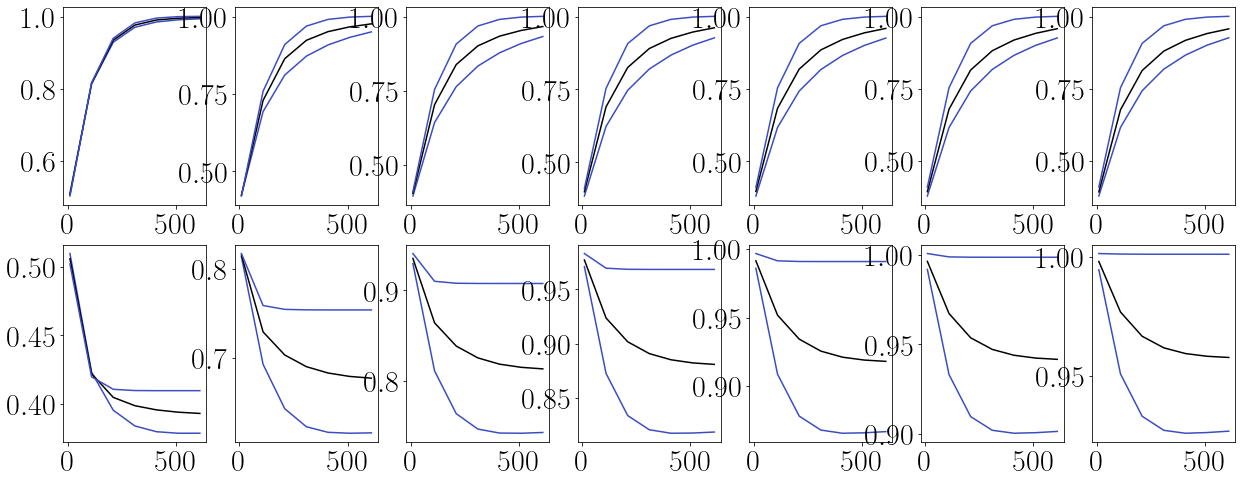

In [34]:
first_ons = np.arange(10, 620, 100)
rests = np.arange(10, 620, 100)
slider = [0, 0.5, 1]
cmap = matplotlib.cm.get_cmap('coolwarm')

fig, ax = plt.subplots(2, 7, figsize=(21, 8))
glut = 0.2

for i, first in enumerate(first_ons):
    for mod in slider:
        color = cmap(mod) if mod != 0.5 else 'k'
        ratios = []
        
        for rest in rests:
            experiment_name = 'glut_{}_onoff_{}_{}_mod_{}'.format(glut, first, rest, round(mod, 1))
            file_name = 'double_bath/' + experiment_name
            load_experiment(file_name, verbose=False)
            ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]
            
            ratio, _, _ = report_max_ratios(times=ratio_times)
            ratios.append(ratio)
        ax[0, i].plot(rests, ratios, c=color)
            
for i, rest in enumerate(rests):
    for mod in slider:
        color = cmap(mod) if mod != 0.5 else 'k'
        ratios = []
        
        for first in first_ons:
            experiment_name = 'glut_{}_onoff_{}_{}_mod_{}'.format(glut, first, rest, round(mod, 1))
            file_name = 'double_bath/' + experiment_name
            load_experiment(file_name, verbose=False)
            ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]
            
            ratio, _, _ = report_max_ratios(times=ratio_times)
            ratios.append(ratio)
        ax[1, i].plot(rests, ratios, c=color)


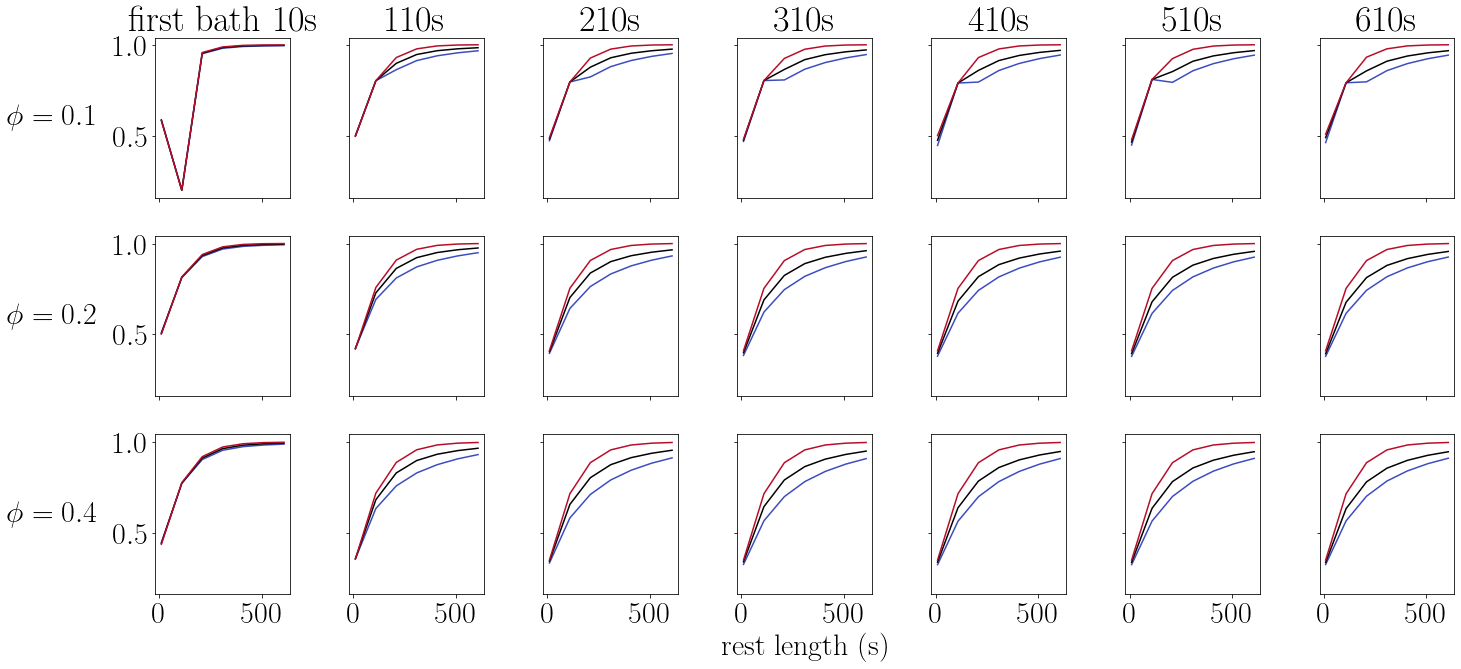

In [76]:
first_ons = np.arange(10, 620, 100)
rests = np.arange(10, 620, 100)
slider = [0, 0.5, 1]
cmap = matplotlib.cm.get_cmap('coolwarm')

fig, ax = plt.subplots(3, 7, figsize=(21, 10), sharey=True, sharex=True)
# glut = 0.2
gluts = [0.1, 0.2, 0.4]

for j, glut in enumerate(gluts):
    for i, first in enumerate(first_ons):
        for mod in slider:
            color = cmap(mod - 0.01) if mod != 0.5 else 'k'
            ratios = []

            for rest in rests:
                experiment_name = 'glut_{}_onoff_{}_{}_mod_{}'.format(glut, first, rest, round(mod, 1))
                file_name = 'double_bath/' + experiment_name
                load_experiment(file_name, verbose=False)
                ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]

                ratio, _, _ = report_max_ratios(times=ratio_times)
                ratios.append(ratio)
            ax[j, i].plot(rests, ratios, c=color)
            
for i, first in enumerate(first_ons):
    if i == 0:
        ax[0, i].set_title('first bath {}s'.format(first))
    else:
        ax[0, i].set_title('{}s'.format(first))

for j, glut in enumerate(gluts):
    ax[j, 0].set_ylabel('$\phi={}$'.format(glut), rotation=0, va='center', labelpad=60)
    
ax[2, 3].set_xlabel('rest length (s)')
# ax[1, 0].set_ylabel('c ratio')

plt.tight_layout()
plt.savefig('figures/poster_plots/double_bath_rest_length.png', bbox_inches='tight')
            


IndexError: too many indices for array

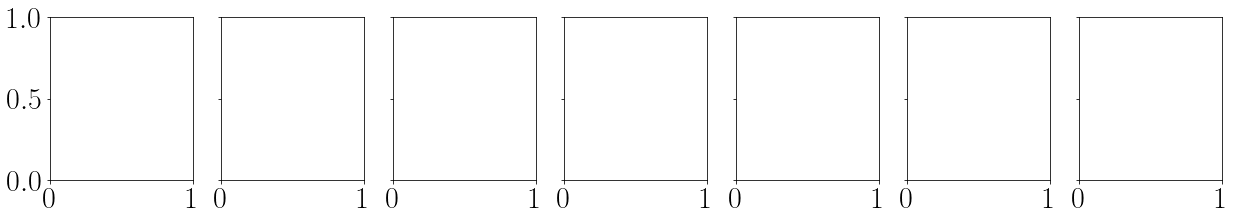

In [78]:
first_ons = np.arange(10, 620, 100)
rests = np.arange(10, 620, 100)
slider = [0, 0.5, 1]
cmap = matplotlib.cm.get_cmap('coolwarm')

fig, ax = plt.subplots(1, 7, figsize=(21, 3), sharey=True, sharex=True)
# glut = 0.2
# gluts = [0.1, 0.2, 0.4]
gluts = [0.2]

for j, glut in enumerate(gluts):
    for i, rest in enumerate(rests):
        for mod in slider:
            color = cmap(mod - 0.01) if mod != 0.5 else 'k'
            ratios = []

            for first in first_ons:
                experiment_name = 'glut_{}_onoff_{}_{}_mod_{}'.format(glut, first, rest, round(mod, 1))
                file_name = 'double_bath/' + experiment_name
                load_experiment(file_name, verbose=False)
                ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]

                ratio, _, _ = report_max_ratios(times=ratio_times)
                ratios.append(ratio)
            ax[j, i].plot(rests, ratios, c=color)
            
for i, rest in enumerate(rests):
    if i == 0:
        ax[0, i].set_title('rest {}s'.format(rest))
    else:
        ax[0, i].set_title('{}s'.format(rest))

for j, glut in enumerate(gluts):
    ax[j, 0].set_ylabel('$\phi={}$'.format(glut), rotation=0, va='center', labelpad=60)
    
ax[2, 3].set_xlabel('first bath length (s)')

    
plt.tight_layout()
plt.savefig('figures/poster_plots/double_bath_first_length.png', bbox_inches='tight')



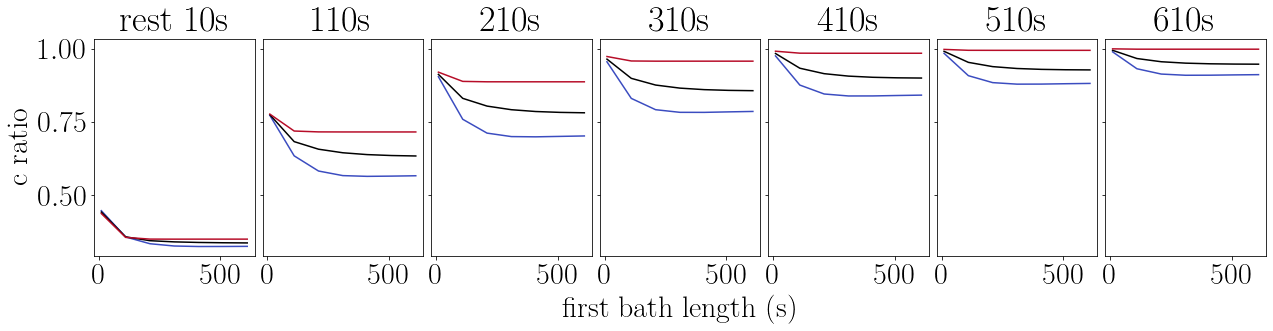

In [7]:
first_ons = np.arange(10, 620, 100)
rests = np.arange(10, 620, 100)
slider = [0, 0.5, 1]
cmap = matplotlib.cm.get_cmap('coolwarm')

fig, ax = plt.subplots(1, 7, figsize=(21, 4), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.05)
# glut = 0.2
# gluts = [0.1, 0.2, 0.4]
glut = 0.4

for i, rest in enumerate(rests):
    for mod in slider:
        color = cmap(mod - 0.01) if mod != 0.5 else 'k'
        ratios = []

        for first in first_ons:
            experiment_name = 'glut_{}_onoff_{}_{}_mod_{}'.format(glut, first, rest, round(mod, 1))
            file_name = 'double_bath/' + experiment_name
            load_experiment(file_name, verbose=False)
            ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]

            ratio, _, _ = report_max_ratios(times=ratio_times)
            ratios.append(ratio)
        ax[i].plot(rests, ratios, c=color)
            
for i, rest in enumerate(rests):
    if i == 0:
        ax[i].set_title('rest {}s'.format(rest))
    else:
        ax[i].set_title('{}s'.format(rest))

ax[0].set_ylabel('c ratio') 
ax[3].set_xlabel('first bath length (s)')

    
# plt.tight_layout()
plt.savefig('figures/poster_plots/double_bath_first_length.png', bbox_inches='tight')



In [108]:
cfg.all_init

[0.144095, 30.29647, 0.63921, 0.118324, 0.019922, 0.046037, 0.012016, 0.001115]

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.83it/s]


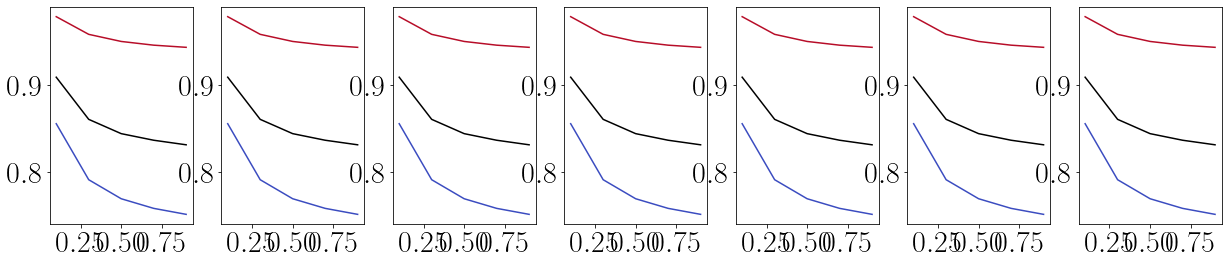

In [111]:
first_ons = np.arange(10, 620, 100)
gluts = np.arange(0.1, 1, 0.2)
slider = [0, 0.5, 1]
rest = 300
set_init()
cfg.kd1 = 0.02
cfg.kd2 = 0.6
cmap = matplotlib.cm.get_cmap('coolwarm')
fig, ax = plt.subplots(1, len(first_ons), figsize=(21, 4))

for i, first in enumerate(tqdm(first_ons)):
    for mod in slider:
        cfg.kd1 = cfg.kd1 * mod
        cfg.kd2 = cfg.kd2 * (1 - mod)
        
        ratios = []
        color = cmap(mod-0.01) if mod != 0.5 else 'k'
        for glut in gluts:
            experiment_name = 'glut_{}_onoff_{}_{}_mod_{}'.format(glut, protocol[0], protocol[1], round(mod, 1))
            file_name = 'double_bath/' + experiment_name
            if not experiment_name in os.listdir('data/experiments/double_bath'):

                ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]
                cfg.custom_input_times = [0, 10, 10+first, 10+first+rest, 70+first+rest]
                cfg.custom_input_vals = [0, glut, 0, glut, 0]

                sol = run_experiment('custom', t_f=80+first+rest, max_step=0.2)
                save_experiment(file_name, verbose=False)
            else:
                load_experiment(file_name, verbose=False)
            ratio, _, _ = report_max_ratios(times=ratio_times)
            ratios.append(ratio)
        
        ax[i].plot(gluts, ratios, c=color)
        
        cfg.kd1 = 0.02
        cfg.kd2 = 0.6
            

In [113]:
protocol

[610, 300]

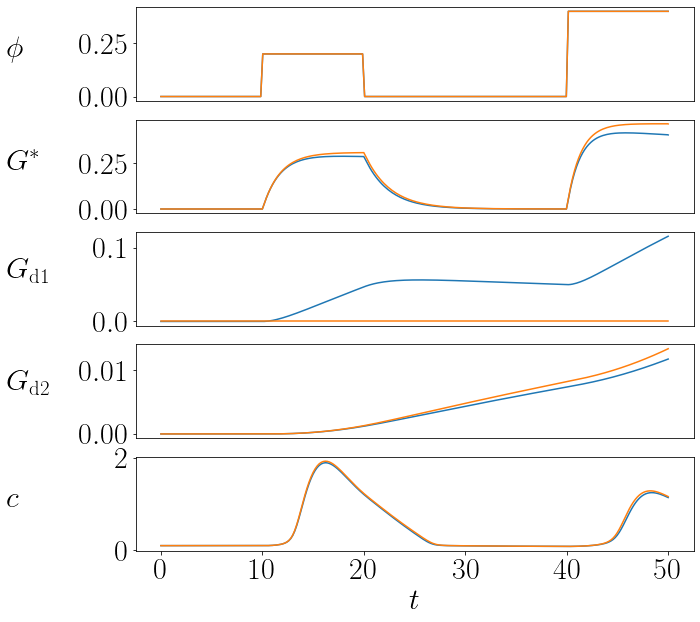

In [127]:
glut = 1
cfg.custom_input_times = [0, 10, 20, 40, 50]
cfg.custom_input_vals = [0, 0.2, 0, 0.4, 0]
cfg.kd1 = 0.02
cfg.kd2 = 0.6
fig, ax = plt.subplots(5, 1, figsize=(10, 10))
run_experiment('custom', t_f=50, max_step=0.2)
plot_experiment_plots(['glut', 'Gstar', 'Gd1', 'Gd2', 'c'], ax)

cfg.kd1 = 0
run_experiment('custom', t_f=50, max_step=0.2)
plot_experiment_plots(['glut', 'Gstar', 'Gd1', 'Gd2', 'c'], ax)
cfg.kd1 = 0.02

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]


ValueError: zero-size array to reduction operation maximum which has no identity

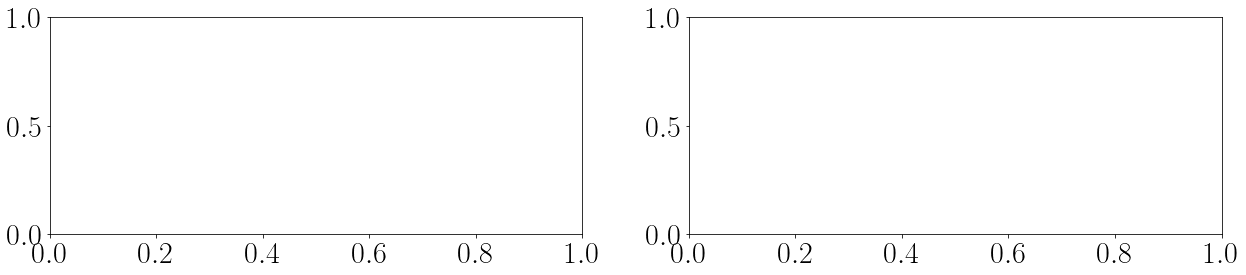

In [118]:
first_ons = np.arange(10, 120, 100)
gluts = np.arange(0.1, 1, 0.2)
slider = [0, 0.5, 1]
rest = 20
set_init()
cfg.kd1 = 0.02
cfg.kd2 = 0.6
cmap = matplotlib.cm.get_cmap('coolwarm')
fig, ax = plt.subplots(1, len(first_ons), figsize=(21, 4))

for i, first in enumerate(tqdm(first_ons)):
    for mod in slider:
        cfg.kd1 = cfg.kd1 * mod
        cfg.kd2 = cfg.kd2 * (1 - mod)
        
        ratios = []
        color = cmap(mod-0.01) if mod != 0.5 else 'k'
        for glut in gluts:
            experiment_name = 'glut_{}_onoff_{}_{}_mod_{}'.format(glut, first, rest, round(mod, 1))
            file_name = 'double_bath/' + experiment_name
            if not experiment_name in os.listdir('data/experiments/double_bath'):

                ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]
                cfg.custom_input_times = [0, 10, 10+first, 10+first+rest, 70+first+rest]
                cfg.custom_input_vals = [0, glut, 0, glut, 0]

                sol = run_experiment('custom', t_f=80+first+rest, max_step=0.2)
                save_experiment(file_name, verbose=False)
            else:
                load_experiment(file_name, verbose=False)
            ratio, _, _ = report_max_ratios(times=ratio_times)
            ratios.append(ratio)
        
        ax[i].plot(gluts, ratios, c=color)
        
        cfg.kd1 = 0.02
        cfg.kd2 = 0.6
            

In [ ]:
# first_ons = np.arange(10, 620, 100)
first = 300
# gluts = np.arange(0.1, 1, 0.2)
glut = [0.4]
slider = [0, 1]
rest = 300
set_init()
cfg.kd1 = 0.02
cfg.kd2 = 0.6
cmap = matplotlib.cm.get_cmap('coolwarm')
fig, ax = plt.subplots(1, len(first_ons), figsize=(21, 4), sharey=True)

for i, glut in gluts:        
    ratios = []
    color = cmap(mod) if mod != 0.5 else 'k'
    for glut in gluts:
        experiment_name = 'glut_{}_onoff_{}_{}_mod_{}'.format(glut, protocol[0], protocol[1], round(mod, 1))
        file_name = 'double_bath/' + experiment_name
        if not experiment_name in os.listdir('data/experiments/double_bath'):

            ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]
            cfg.custom_input_times = [0, 10, 10+first, 10+first+rest, 70+first+rest]
            cfg.custom_input_vals = [0, glut, 0, glut, 0]

            sol = run_experiment('custom', t_f=80+first+rest, max_step=0.2)
            save_experiment(file_name, verbose=False)
        else:
            load_experiment(file_name, verbose=False)
        ratio, _, _ = report_max_ratios(times=ratio_times)
        ratios.append(ratio)
        
#     ax[i].plot(cfg.t, cfg.c, c=color)
                    

 71%|████████████████████████████████████████████████████████████                        | 5/7 [01:43<00:43, 21.56s/it]

In [20]:
# first_ons = np.arange(10, 620, 100)
first = 300
# gluts = np.arange(0.1, 1, 0.2)
gluts = [0.4]
slider = [0, 1]
rests = np.arange(10, 620, 20)
set_init()
cfg.kd1 = 0.02
kd1 = cfg.kd1
cfg.kd2 = 0.6
kd2 = cfg.kd2
cmap = matplotlib.cm.get_cmap('coolwarm')
# fig, ax = plt.subplots(1, len(first_ons), figsize=(21, 4), sharey=True)

for i, mod in tqdm(enumerate(slider)):
    ratios = []
    color = cmap(mod) if mod != 0.5 else 'k'
    
    cfg.kd1 = kd1 * mod
    cfg.kd2 = kd2 * (1 - mod)
    for glut in gluts:
        for rest in rests:
            
            experiment_name = 'glut_{}_onoff_{}_{}_mod_{}'.format(glut, first, rest, round(mod, 1))
            file_name = 'double_bath/' + experiment_name
#             if not experiment_name in os.listdir('data/experiments/double_bath'):

            ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]
            cfg.custom_input_times = [0, 10, 10+first, 10+first+rest, 70+first+rest]
            cfg.custom_input_vals = [0, glut, 0, glut, 0]

            sol = run_experiment('custom', t_f=80+first+rest, max_step=0.2)
            save_experiment(file_name, verbose=False)
#             else:
#                 load_experiment(file_name, verbose=False)
            ratio, _, _ = report_max_ratios(times=ratio_times)
            ratios.append(ratio)
        
#     ax[i].plot(cfg.t, cfg.c, c=color)
                    

2it [02:25, 72.84s/it]


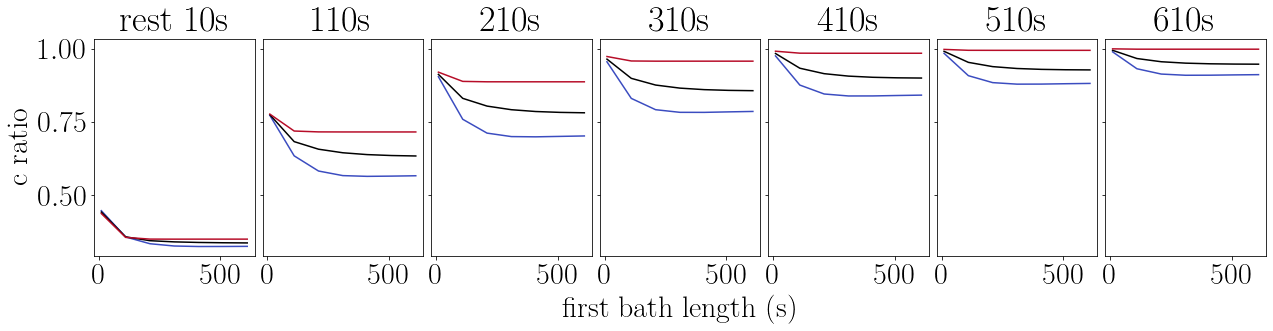

In [7]:
first_ons = np.arange(10, 620, 100)
rest = 300
slider = [0, 0.5, 1]
cmap = matplotlib.cm.get_cmap('coolwarm')

fig, ax = plt.subplots(1, 7, figsize=(21, 4), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.05)
# glut = 0.2
# gluts = [0.1, 0.2, 0.4]
glut = 0.4

for i, rest in enumerate(rests):
    for mod in slider:
        color = cmap(mod - 0.01) if mod != 0.5 else 'k'
        ratios = []

        for first in first_ons:
            experiment_name = 'glut_{}_onoff_{}_{}_mod_{}'.format(glut, first, rest, round(mod, 1))
            file_name = 'double_bath/' + experiment_name
            load_experiment(file_name, verbose=False)
            ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]

            ratio, _, _ = report_max_ratios(times=ratio_times)
            ratios.append(ratio)
        ax[i].plot(rests, ratios, c=color)
            
for i, rest in enumerate(rests):
    if i == 0:
        ax[i].set_title('rest {}s'.format(rest))
    else:
        ax[i].set_title('{}s'.format(rest))

ax[0].set_ylabel('c ratio') 
ax[3].set_xlabel('first bath length (s)')

    
# plt.tight_layout()
plt.savefig('figures/poster_plots/double_bath_first_length.png', bbox_inches='tight')



In [10]:
first_ons = np.arange(10, 620, 100)
rests = [300]
slider = [0, 0.5, 1]
set_init('noise')
protocols = []
for first_on in first_ons:
    for rest in rests:
        protocols.append([first_on, rest])

cfg.kd2 = 0.24
cfg.r_rise = 0.2
cfg.r_decay = 0.2
cfg.d_decay = 20
cfg.A = 0.4

glut = 0.4
for i, protocol in enumerate(tqdm(protocols)):

    for mod in slider:
        experiment_name = 'glut_{}_onoff_{}_{}_mod_{}_noise_kd24'.format(glut, protocol[0], protocol[1], round(mod, 1))
        file_name = 'double_bath/' + experiment_name
        if not experiment_name in os.listdir('data/experiments/double_bath'):

            cfg.kd1 = cfg.kd1 * mod
            cfg.kd2 = cfg.kd2 * (1 - mod)

            first = protocol[0]
            rest = protocol[1]
            cfg.custom_input_times = [0, 10, 10+first, 10+first+rest, 70+first+rest]
            cfg.custom_input_vals = [0, glut, 0, glut, 0]
            ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]


            sol = run_experiment('custom', t_f=80+first+rest, max_step=1, noise=0.03)

            cfg.kd1 = 0.02
            cfg.kd2 = 0.24

            save_experiment(file_name, verbose=False)


 14%|████████████                                                                        | 1/7 [00:03<00:23,  3.98s/it]


KeyboardInterrupt: 

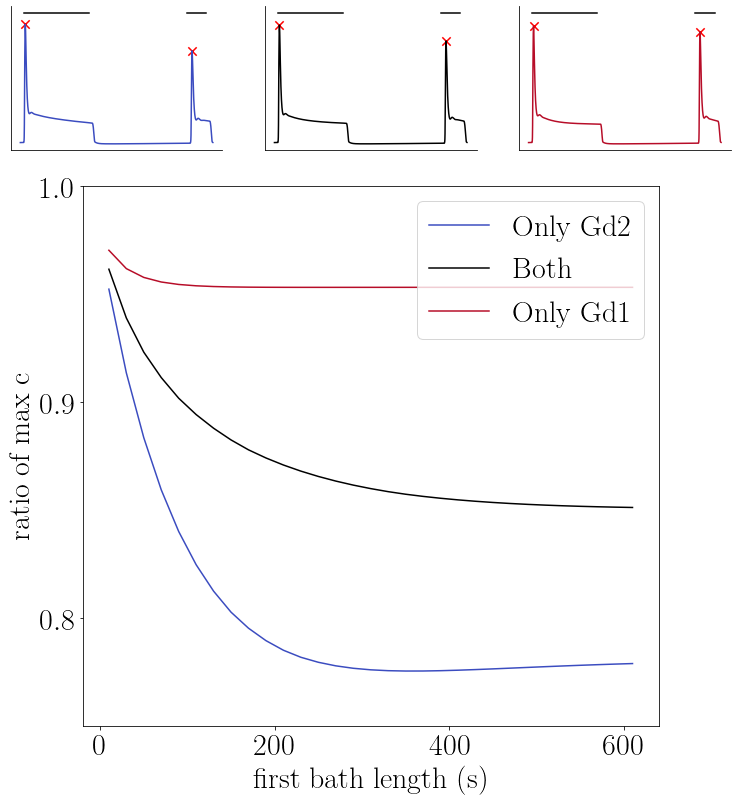

In [107]:
first_ons = np.arange(10, 620, 20)
rests = [300]
slider = [0, 0.5, 1]
glut = 0.4
rest = 300
labels = ['Only Gd2', 'Both', 'Only Gd1']

cmap = matplotlib.cm.get_cmap('coolwarm')
fig = plt.figure(constrained_layout=False, figsize=(10, 10))
gs = fig.add_gridspec(1, 3, left=0, right=1, top=1, bottom=0.8) #calcium trace plots
gs2 = fig.add_gridspec(1, 1, left=0.1, right=0.9, top=0.75, bottom=0)
ax = fig.add_subplot(gs2[0])

#Plot summary ratios
for i, mod in enumerate(slider):
    color = cmap(mod - 0.01) if mod != 0.5 else 'k'
    ratios = []

    for first in first_ons:
        experiment_name = 'glut_{}_onoff_{}_{}_mod_{}'.format(glut, first, rest, round(mod, 1))
        file_name = 'double_bath/' + experiment_name
        load_experiment(file_name, verbose=False)
        ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]

        ratio, _, _ = report_max_ratios(times=ratio_times)
        ratios.append(ratio)
    ax.plot(first_ons, ratios, c=color, label=labels[i])
            
ax.set_xlabel('first bath length (s)')
ax.set_ylabel('ratio of max c')
ax.set_yticks([0.8, 0.9, 1.0])
ax.set_ylim([0.75, 1.0])
ax.legend(loc='upper right')
#Plot example plots for specific first bath lengths
first_on_examples = [30, 210, 410]
axs = []
for i, mod in enumerate(slider):
    first = 210
    ax = fig.add_subplot(gs[i])
    axs.append(ax)
    
    color = cmap(mod - 0.01) if mod != 0.5 else 'k'
    experiment_name = 'glut_{}_onoff_{}_{}_mod_{}'.format(glut, first, rest, round(mod, 1))
    file_name = 'double_bath/' + experiment_name
    load_experiment(file_name, verbose=False)
    
    ax.plot(cfg.t, cfg.c, c=color)
    ax.plot([10, 210], [2.6, 2.6], 'k')
    ax.plot([510, 570], [2.6, 2.6], 'k')
    
    ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]
    _, maxes, pos = report_max_ratios(ratio_times)
    ax.scatter(cfg.t[pos], maxes, c='red', marker='x', s=70)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.savefig('figures/poster_plots/double_bath_ratios_summary', bbox_inches='tight')


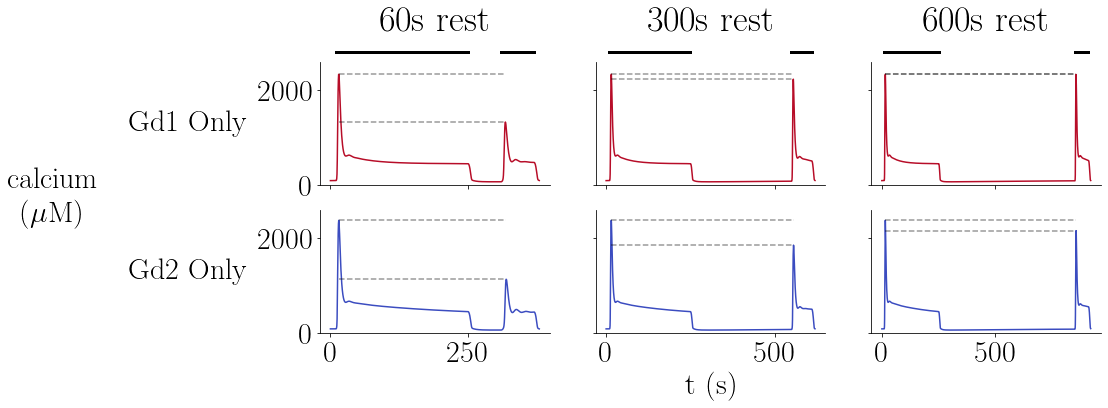

In [128]:
rests = [60, 300, 600]
first = 240
fig, ax = plt.subplots(2, 3, figsize=(14, 5), sharey=True, sharex='col')

kd1 = 0.02
kd2 = 0.6

cmap = matplotlib.cm.get_cmap('coolwarm')
blue = cmap(0)
red = cmap(0.99)

for i, rest in enumerate(rests):
    ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]
    cfg.custom_input_times = [0] + ratio_times
    cfg.custom_input_vals = [0, 0.4, 0, 0.4, 0]
    
    cfg.kd1 = kd1
    cfg.kd2 = 0
    run_experiment('custom', t_f=80+first+rest, max_step=0.5)
    ax[0, i].plot(cfg.t, cfg.c * 1000, c=red)
    _, maxes, pos = report_max_ratios(ratio_times)
    ax[0, i].plot([cfg.t[pos[0]], cfg.t[pos[1]]], [maxes[0]*1000, maxes[0]*1000], '--k', alpha=0.4)
    ax[0, i].plot([cfg.t[pos[0]], cfg.t[pos[1]]], [maxes[1]*1000, maxes[1]*1000], '--k', alpha=0.4)
    
    cfg.kd1 = 0
    cfg.kd2 = kd2
    run_experiment('custom', t_f=80+first+rest, max_step=0.5)
    _, maxes, pos = report_max_ratios(ratio_times)
    ax[1, i].plot(cfg.t, cfg.c * 1000, c=blue)
    ax[1, i].plot([cfg.t[pos[0]], cfg.t[pos[1]]], [maxes[0]*1000, maxes[0]*1000], '--k', alpha=0.4)
    ax[1, i].plot([cfg.t[pos[0]], cfg.t[pos[1]]], [maxes[1]*1000, maxes[1]*1000], '--k', alpha=0.4)
    
    ax[0, i].plot([ratio_times[0], ratio_times[1]], [2800, 2800], 'k', linewidth=3, clip_on=False)
    ax[0, i].plot([ratio_times[2], ratio_times[3]], [2800, 2800], 'k', linewidth=3, clip_on=False)

    ax[0, i].spines['top'].set_visible(False)
    ax[0, i].spines['right'].set_visible(False)
    ax[1, i].spines['top'].set_visible(False)
    ax[1, i].spines['right'].set_visible(False)
    
    ax[0, i].set_title('{}s rest'.format(rest), pad=30)
    
cfg.kd1 = kd1
cfg.kd2 = kd2

ax[1, 1].set_xlabel('t (s)')
ax[0, 0].set_ylabel('Gd1 \n Only', rotation=0, ha='center', va='center', labelpad=70)
ax[1, 0].set_ylabel('Gd2 \n Only', rotation=0, ha='center', va='center', labelpad=70)

ax[0, 0].set_ylim([0, 2600])
plt.text(-0, 1, 'Ca$^{2+}$ \n ($\mu$M)', ha='center', va='center', transform=plt.gcf().transFigure)
# plt.tight_layout()
plt.savefig('figures/poster_plots/double_bath_rest_times', bbox_inches='tight')

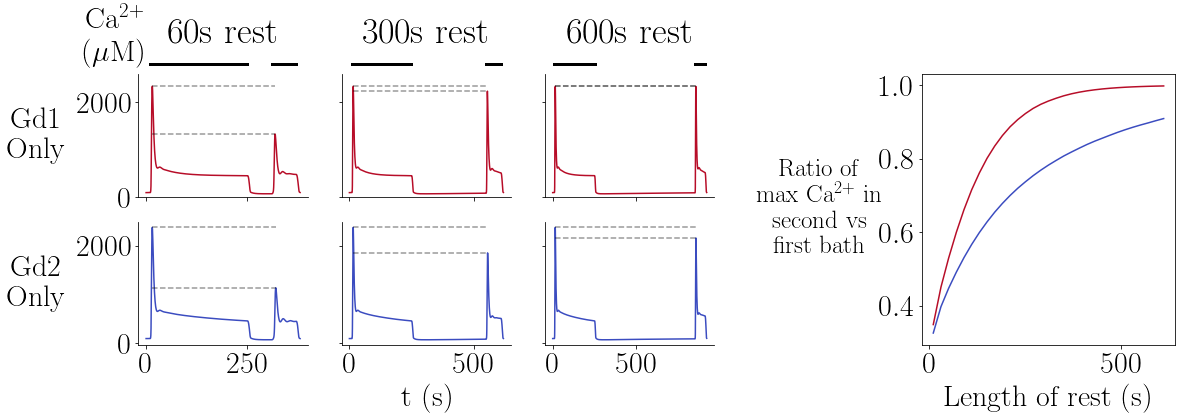

In [28]:
rests = [60, 300, 600]
first = 240
fig = plt.figure(constrained_layout=False, figsize=(16, 5))
gs = fig.add_gridspec(nrows=2, ncols=3, left=0, right=0.5)
gs2 = fig.add_gridspec(1, 1, left=0.68)
ax = []
for i in range(2):
    ax.append([])
    for j in range(3):
        sharex = ax[0][j] if i > 0 else None #share col x
        sharey = ax[i][0] if j > 0 else None #share row y
        ax[i].append(fig.add_subplot(gs[i, j], sharex=sharex, sharey=sharey))
ax = np.array(ax)

# fig, ax = plt.subplots(2, 3, figsize=(14, 5), sharey=True, sharex='col')

kd1 = 0.02
kd2 = 0.6

cmap = matplotlib.cm.get_cmap('coolwarm')
blue = cmap(0)
red = cmap(0.99)

for i, rest in enumerate(rests):    
    ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]
    cfg.custom_input_times = [0] + ratio_times
    cfg.custom_input_vals = [0, 0.4, 0, 0.4, 0]
    
    cfg.kd1 = kd1
    cfg.kd2 = 0
    run_experiment('custom', t_f=80+first+rest, max_step=0.5)
    ax[0, i].plot(cfg.t, cfg.c * 1000, c=red)
    _, maxes, pos = report_max_ratios(ratio_times)
    ax[0, i].plot([cfg.t[pos[0]], cfg.t[pos[1]]], [maxes[0]*1000, maxes[0]*1000], '--k', alpha=0.4)
    ax[0, i].plot([cfg.t[pos[0]], cfg.t[pos[1]]], [maxes[1]*1000, maxes[1]*1000], '--k', alpha=0.4)
    
    cfg.kd1 = 0
    cfg.kd2 = kd2
    run_experiment('custom', t_f=80+first+rest, max_step=0.5)
    _, maxes, pos = report_max_ratios(ratio_times)
    ax[1, i].plot(cfg.t, cfg.c * 1000, c=blue)
    ax[1, i].plot([cfg.t[pos[0]], cfg.t[pos[1]]], [maxes[0]*1000, maxes[0]*1000], '--k', alpha=0.4)
    ax[1, i].plot([cfg.t[pos[0]], cfg.t[pos[1]]], [maxes[1]*1000, maxes[1]*1000], '--k', alpha=0.4)
    
    ax[0, i].plot([ratio_times[0], ratio_times[1]], [2800, 2800], 'k', linewidth=3, clip_on=False)
    ax[0, i].plot([ratio_times[2], ratio_times[3]], [2800, 2800], 'k', linewidth=3, clip_on=False)

    ax[0, i].spines['top'].set_visible(False)
    ax[0, i].spines['right'].set_visible(False)
    ax[1, i].spines['top'].set_visible(False)
    ax[1, i].spines['right'].set_visible(False)
    
    ax[0, i].set_title('{}s rest'.format(rest), pad=30)
    
    if i > 0:
        plt.setp(ax[0, i].get_yticklabels(), visible=False)
        plt.setp(ax[1, i].get_yticklabels(), visible=False)
#         ax[0, i].set_yticks([])
#         ax[1, i].set_yticks([])
    plt.setp(ax[0, i].get_xticklabels(), visible=False)
cfg.kd1 = kd1
cfg.kd2 = kd2

ax[1, 1].set_xlabel('t (s)')
ax[0, 0].set_ylabel('Gd1 \n Only', rotation=0, ha='center', va='center', labelpad=40)
ax[1, 0].set_ylabel('Gd2 \n Only', rotation=0, ha='center', va='center', labelpad=40)

ax[0, 0].set_ylim([0, 2600])
plt.text(-0.02, 0.98, 'Ca$^{2+}$ \n ($\mu$M)', ha='center', va='center', transform=plt.gcf().transFigure)
# plt.tight_layout()

ax2 = fig.add_subplot(gs2[0])
rests = np.arange(10, 620, 20)
first = 300
# labels = ['Gd1 \']
slider = [0, 1]
glut = 0.4
rest = 300
for i, mod in enumerate(slider):
    color = cmap(mod - 0.01) if mod != 0.5 else 'k'
    ratios = []

    for rest in rests:
        experiment_name = 'glut_{}_onoff_{}_{}_mod_{}'.format(glut, first, rest, round(mod, 1))
        file_name = 'double_bath/' + experiment_name
        load_experiment(file_name, verbose=False)
        ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]

        ratio, _, _ = report_max_ratios(times=ratio_times)
        ratios.append(ratio)
    ax2.plot(first_ons, ratios, c=color)
ax2.set_ylabel('Ratio of \n max Ca$^{2+}$ in \n second vs \n first bath', rotation=0, ha='center', va='center', labelpad=60,
              fontsize=25)
ax2.set_xlabel('Length of rest (s)')



plt.savefig('figures/poster_plots/double_bath_rest_times', bbox_inches='tight')

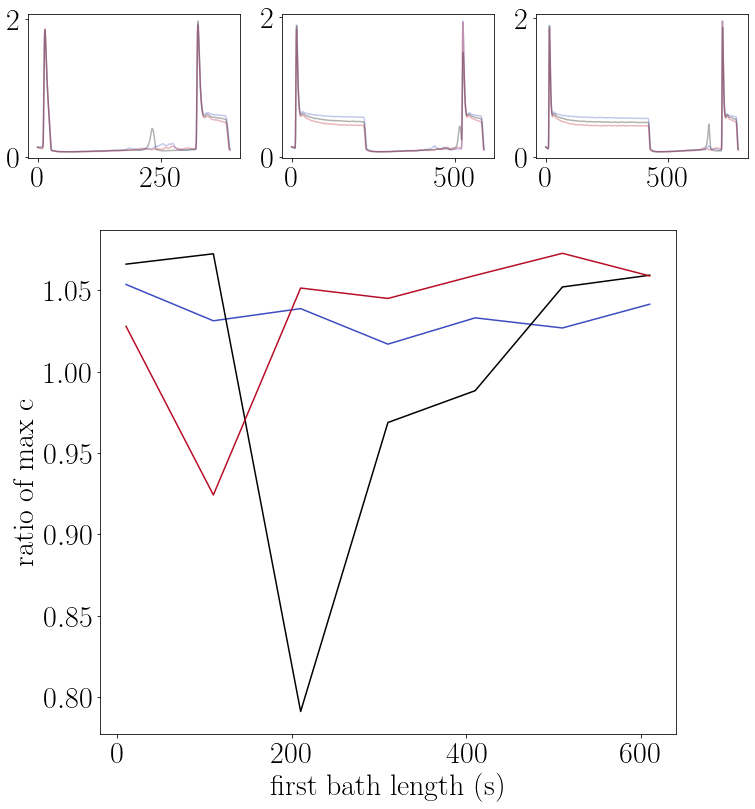

In [7]:
first_ons = np.arange(10, 620, 100)
rests = [300]
slider = [0, 0.5, 1]
glut = 0.4
rest = 300

cmap = matplotlib.cm.get_cmap('coolwarm')
fig = plt.figure(constrained_layout=False, figsize=(10, 10))
gs = fig.add_gridspec(1, 3, left=0, right=1, top=1, bottom=0.8) #calcium trace plots
gs2 = fig.add_gridspec(1, 1, left=0.1, right=0.9, top=0.7, bottom=0)
ax = fig.add_subplot(gs2[0])

#Plot summary ratios
for mod in slider:
    color = cmap(mod - 0.01) if mod != 0.5 else 'k'
    ratios = []

    for first in first_ons:
        experiment_name = 'glut_{}_onoff_{}_{}_mod_{}_noise'.format(glut, first, rest, round(mod, 1))
        file_name = 'double_bath/' + experiment_name
        load_experiment(file_name, verbose=False)
        ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]

        ratio, _, _ = report_max_ratios(times=ratio_times)
        ratios.append(ratio)
    ax.plot(first_ons, ratios, c=color)
            
ax.set_xlabel('first bath length (s)')
ax.set_ylabel('ratio of max c')

#Plot example plots for specific first bath lengths
first_on_examples = [10, 210, 410]
for i, first in enumerate(first_on_examples):
    ax = fig.add_subplot(gs[i])
    for mod in slider:
        color = cmap(mod - 0.01) if mod != 0.5 else 'k'
        experiment_name = 'glut_{}_onoff_{}_{}_mod_{}_noise'.format(glut, first, rest, round(mod, 1))
        file_name = 'double_bath/' + experiment_name
        load_experiment(file_name, verbose=False)
        
        ax.plot(cfg.t, cfg.c, c=color, alpha=0.3)


In [94]:
first_ons = np.arange(10, 620, 200)
rests = [300]
slider = [0, 0.5, 1, 2]
# slider = [2]
set_init('noise')
# set_init('default')
protocols = []
for first_on in first_ons:
    for rest in rests:
        protocols.append([first_on, rest])

cfg.kd2 = 2.4
cfg.kd1 = 0.02

glut = 1
all_ratios = {
    0: {},
    0.5: {},
    1: {},
    2: {}
}
num_trials = 5
for mod in slider:
    for first_on in first_ons:
        all_ratios[mod][first_on] = []


for i, protocol in enumerate(tqdm(protocols)):
    for mod in slider:
        ratios = []
        for trial in range(num_trials):
            if mod != 2:
                cfg.kd1 = cfg.kd1 * mod
                cfg.kd2 = cfg.kd2 * (1 - mod)

            first = protocol[0]
            rest = protocol[1]
            cfg.custom_input_times = [0, 10, 10+first, 10+first+rest, 70+first+rest]
            cfg.custom_input_vals = [0, glut, 0, glut, 0]
            ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]


            sol = run_experiment('custom', t_f=80+first+rest, max_step=1, noise=0.03)
            ratio, _, _ = report_max_ratios(times=ratio_times)
            ratios.append(ratio)
            
            cfg.kd1 = 0.02
            cfg.kd2 = 2.4
            all_ratios[mod][first].append(ratio)
#         all_ratios[mod].append(np.mean(ratios))



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:53<00:00, 28.41s/it]


In [56]:
pickle.dump(all_ratios, open('data/plot_data/noisy_double_baths_300rest', 'wb'))

In [95]:
# all_ratios = pickle.load(open('data/plot_data/noisy_double_baths_300rest', 'rb'))
slider = [0, 0.5, 1, 2]
first_ons = np.arange(10, 620, 100)
#calculate error bars based on total range
error_bars = {}
means = {}
for mod in slider:
    means[mod] = []
    error_bars[mod] = []
    for first in first_ons:
        ratios = all_ratios[mod][first]
        mean = np.mean(ratios)
        upper = np.max(ratios) - mean
        lower = mean - np.min(ratios)
#         error_bars[mod].append([upper, lower])
#         error_bars[mod].append(np.std(ratios))
        error_bars[mod].append(scipy.stats.sem(ratios))
        means[mod].append(mean)


fig = plt.figure(figsize=(7,7))
for mod in slider:
    color = cmap(mod - 0.01) if mod != 0.5 else 'k'
#     plt.scatter(first_ons, means[mod], c=color)
    
    plt.errorbar(first_ons, means[mod], yerr=np.array(error_bars[mod]).T, c=color, fmt='-o')


KeyError: 110

In [148]:
pickle.dump(all_ratios, open('data/plot_data/noisy_double_baths_300rest_1glut', 'wb'))

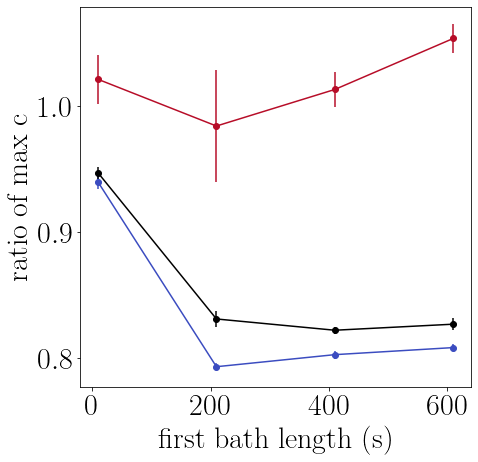

In [149]:
all_ratios = pickle.load(open('data/plot_data/noisy_double_baths_300rest_1glut', 'rb'))
slider = [0, 1, 2]
first_ons = np.arange(10, 620, 200)
#calculate error bars based on total range
error_bars = {}
means = {}
for mod in slider:
    means[mod] = []
    error_bars[mod] = []
    for first in first_ons:
        ratios = all_ratios[mod][first]
        mean = np.mean(ratios)
        upper = np.max(ratios) - mean
        lower = mean - np.min(ratios)
#         error_bars[mod].append([upper, lower])
#         error_bars[mod].append(np.std(ratios))
        error_bars[mod].append(scipy.stats.sem(ratios))
        means[mod].append(mean)


fig = plt.figure(figsize=(7,7))
for mod in slider:
    color = cmap(mod - 0.01) if mod != 2 else 'k'
#     plt.scatter(first_ons, means[mod], c=color)
    
    plt.errorbar(first_ons, means[mod], yerr=np.array(error_bars[mod]).T, c=color, fmt='-o')
plt.ylabel('ratio of max c')
plt.xlabel('first bath length (s)')
plt.savefig('figures/poster_plots/noisy_double_bath_ratios', bbox_inches='tight')

In [ ]:
cfg.oscillation_on_duration = 10
cfg.oscillation_off_duration = 60
cfg.num_oscillations = 10
fig, ax = plt.subplots(6, 3, figsize=(21, 7))

cfg.kd1 = 0.02
cfg.kd2 = 0.6

for i, mod in enumerate(slider):
    run_experiment()

In [20]:
cfg.input_max

0.3

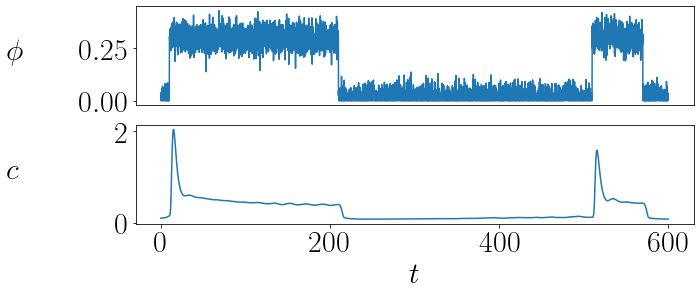

In [133]:
cfg.custom_input_times = [0, 10, 210, 510, 570]
cfg.custom_input_vals = [0, 0.3, 0, 0.3, 0]
run_experiment('custom', noise=0.04, t_f=600)
fig, ax = plt.subplots(2, 1, figsize=(10, 4))
# plt.plot(cfg.t_input, cfg.glut)
plot_experiment_plots(['glut', 'c'], ax)
plt.savefig('figures/poster_plots/noise_double_bath_example', bbox_inches='tight')

In [142]:
red = cmap(0.99)

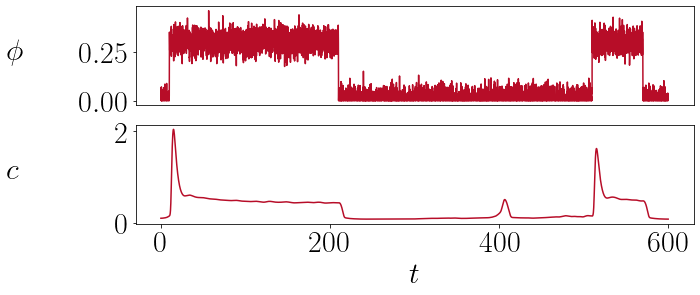

In [146]:
np.random.seed(1)
cfg.custom_input_times = [0, 10, 210, 510, 570]
cfg.custom_input_vals = [0, 0.3, 0, 0.3, 0]

cfg.kd2 = 0

run_experiment('custom', noise=0.04, t_f=600)
fig, ax = plt.subplots(2, 1, figsize=(10, 4))

# plt.plot(cfg.t_input, cfg.glut)
plot_experiment_plots(['glut', 'c'], ax, color=red)
plt.savefig('figures/poster_plots/noise_double_bath_example_gd1', bbox_inches='tight')
cfg.kd2 = 0.6

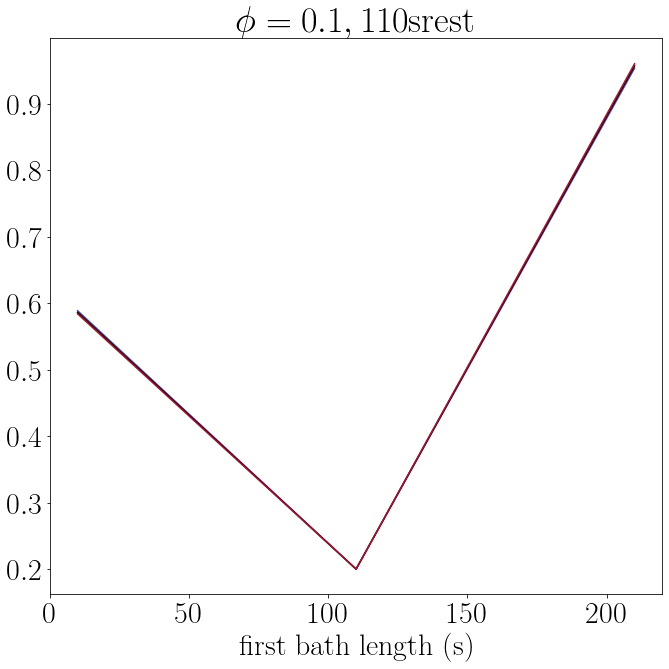

In [61]:
first_ons = np.arange(10, 620, 10)
# rests = [110]
slider = [0, 0.5, 1]
cmap = matplotlib.cm.get_cmap('coolwarm')

plt.figure(figsize=(10, 10))
# fig, ax = plt.subplots(3, 7, figsize=(21, 10), sharey=True, sharex=True)
# glut = 0.2
glut = 0.1
rests = [10, 110, 210]
first = 10
for mod in slider:
    color = cmap(mod - 0.01) if mod != 0.5 else 'k'
    ratios = []

    for rest in rests:
        experiment_name = 'glut_{}_onoff_{}_{}_mod_{}'.format(glut, first, rest, round(mod, 1))
        file_name = 'double_bath/' + experiment_name
        load_experiment(file_name, verbose=False)
        ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]

        ratio, _, _ = report_max_ratios(times=ratio_times)
        ratios.append(ratio)
    plt.plot(rests, ratios, c=color)
            
plt.title('$\phi=0.1, \mathrm{110s rest}$')
plt.xlabel('first bath length (s)')
plt.tight_layout()



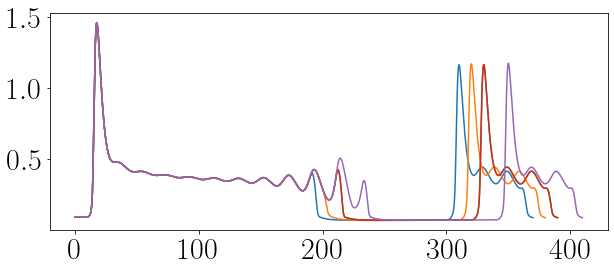

In [59]:
rest = 110
glut = 0.1
first_ons = [180, 190, 200, 210, 220]

plt.figure(figsize=(10, 4))

for first in first_ons:
    experiment_name = 'glut_{}_onoff_{}_{}_mod_{}'.format(glut, first, rest, round(mod, 1))
    file_name = 'double_bath/' + experiment_name
    load_experiment(file_name, verbose=False)
    plt.plot(cfg.t, cfg.c)

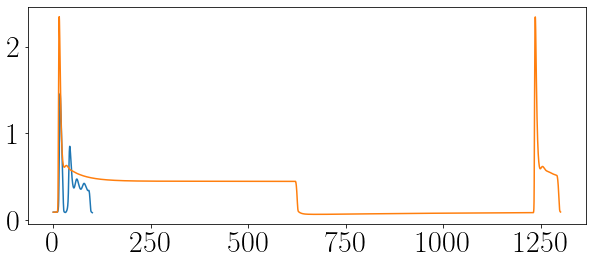

In [64]:
rest = 110
glut = 0.1
first_ons = [180, 190, 200, 210, 220]
first_on = 110
# rests = [10, 110, 210]
rests = [10, 110]
plt.figure(figsize=(10, 4))

for rest in rests:
    experiment_name = 'glut_{}_onoff_{}_{}_mod_{}'.format(glut, first, rest, round(mod, 1))
    file_name = 'double_bath/' + experiment_name
    load_experiment(file_name, verbose=False)
    plt.plot(cfg.t, cfg.c)

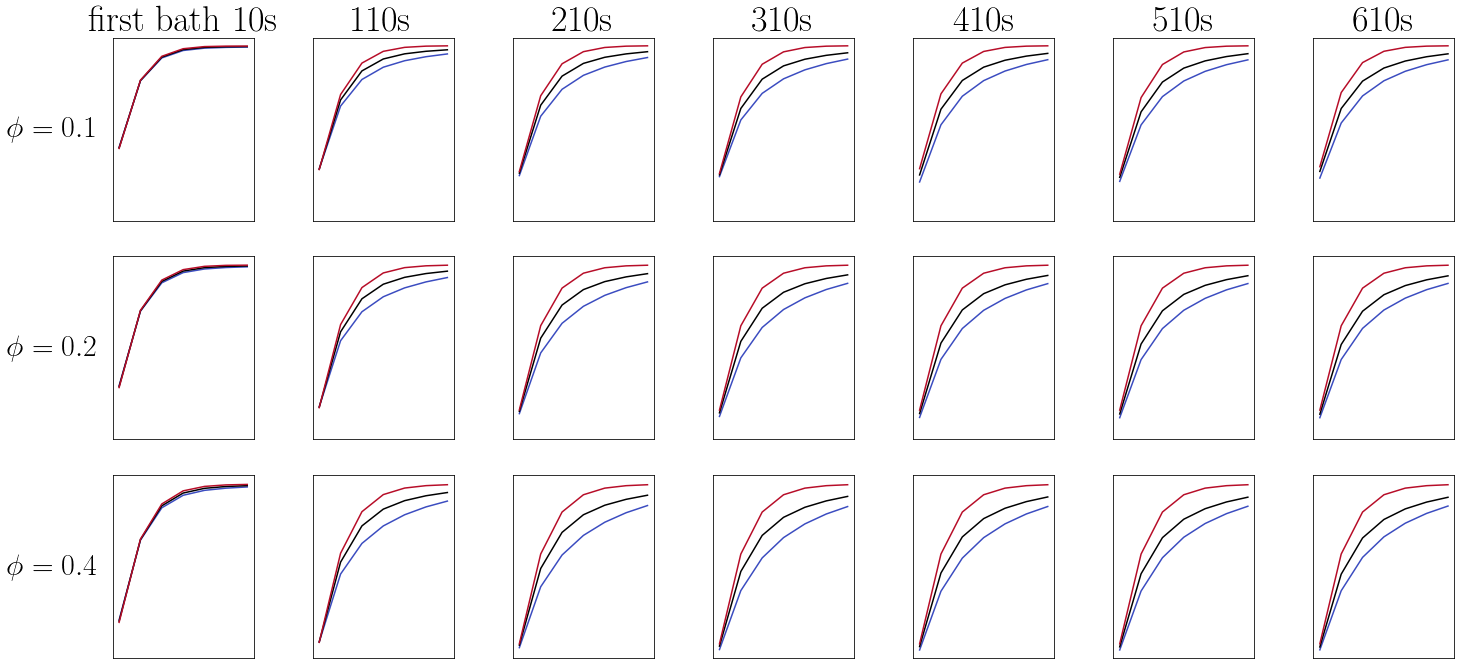

In [47]:
first_ons = np.arange(10, 620, 100)
rests = np.arange(10, 620, 100)
slider = [0, 0.5, 1]
cmap = matplotlib.cm.get_cmap('coolwarm')

fig, ax = plt.subplots(3, 7, figsize=(21, 10), sharey=True, sharex=True)
# glut = 0.2
gluts = [0.1, 0.2, 0.4]

for j, glut in enumerate(gluts):
    for i, first in enumerate(first_ons):
        for mod in slider:
            color = cmap(mod - 0.01) if mod != 0.5 else 'k'
            ratios = []

            for rest in rests:
                experiment_name = 'glut_{}_onoff_{}_{}_mod_{}'.format(glut, first, rest, round(mod, 1))
                file_name = 'double_bath/' + experiment_name
                load_experiment(file_name, verbose=False)
                ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]

                ratio, _, _ = report_max_ratios(times=ratio_times)
                ratios.append(ratio)
            ax[j, i].plot(rests, ratios, c=color)
            
for i, first in enumerate(first_ons):
    if i == 0:
        ax[0, i].set_title('first bath {}s'.format(first))
    else:
        ax[0, i].set_title('{}s'.format(first))

for j, glut in enumerate(gluts):
    ax[j, 0].set_ylabel('$\phi={}$'.format(glut), rotation=0, va='center', labelpad=60)
    
for j in range(3):
    for i in range(7):
        if i != 0:
            ax[j, i].set_yticks([])
        if j != 2:
            ax[j, i].set_xticks([])
    
plt.tight_layout()
            


In [45]:
cmap(0.99)

(0.717434544917647, 0.05111754842352939, 0.15873660770196077, 1.0)

In [ ]:
plt.plot()

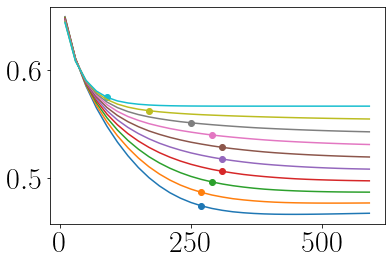

In [62]:
for mod in slider:
    high = np.min(all_c_ratios[mod])
    idx = np.argmax(np.array(all_c_ratios[mod]) < (high + (1 - high) * 0.02))
    plt.plot(first_ons, all_c_ratios[mod])
    plt.scatter(first_ons[idx], all_c_ratios[mod][idx])

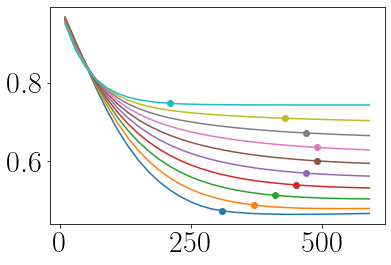

In [63]:
for mod in slider:
    high = np.min(all_Gstar_ratios[mod])
    idx = np.argmax(np.array(all_Gstar_ratios[mod]) < (high + (1 - high)*0.02))
    plt.plot(first_ons, all_Gstar_ratios[mod])
    plt.scatter(first_ons[idx], all_Gstar_ratios[mod][idx])

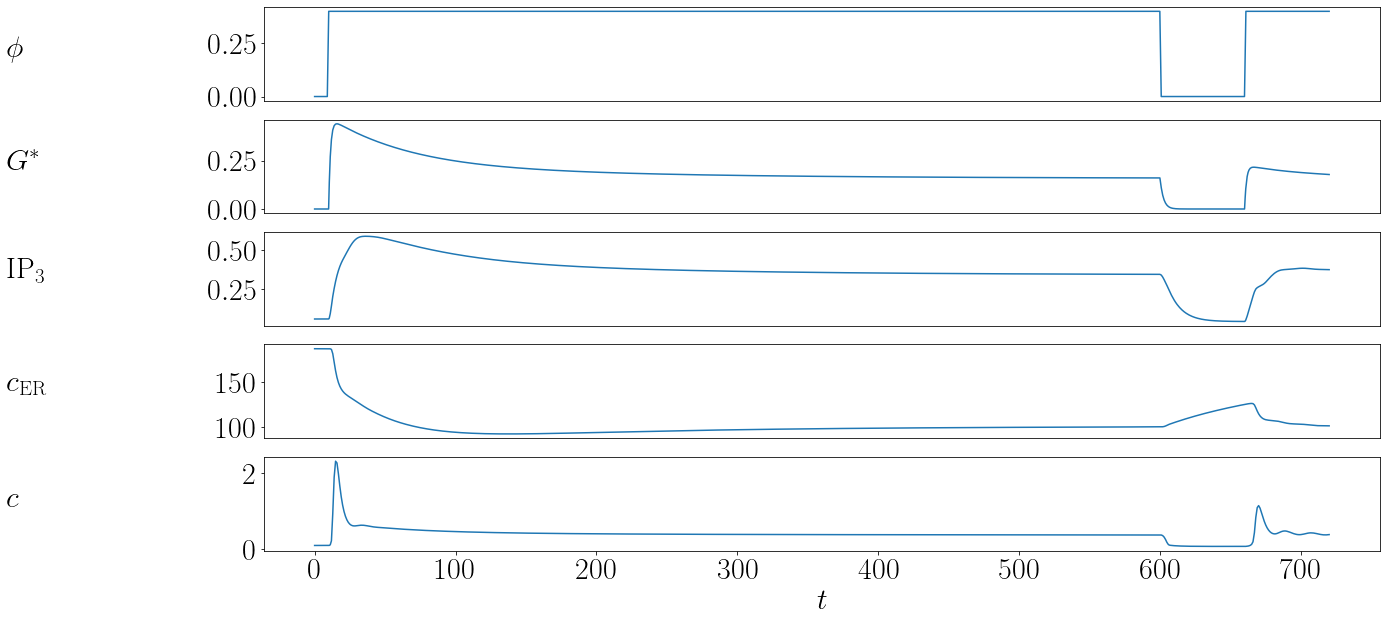

In [25]:
fig, ax = plt.subplots(5, 1, figsize=(20,10))
plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)


### Track desensitization over time with Gd1, Gd2, or both

Here we are trying to see how the total amount of desensitization changes over the course of a bath application of glutamate. Note that with purely Gd1 or purely Gd2, the shapes of the desensitization curve changes. This is also reflected in the relative strength of Gd1 and Gd2.

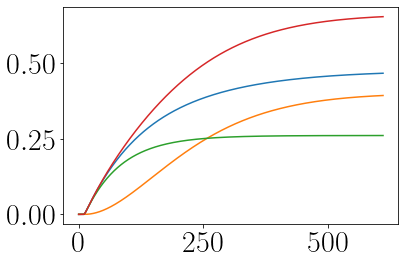

In [67]:
cfg.input_max = 0.1
slider = np.linspace(0, 1, 10)
cfg.input_duration = 600
sol = run_experiment('pulse', t_f=610, max_step=1)
Gd = cfg.Gd1 + cfg.Gd2
plt.plot(cfg.t, Gd)

cfg.kd1 = 0
sol = run_experiment('pulse', t_f=610, max_step=1)
Gd2 = cfg.Gd2
Gd = cfg.Gd1 + cfg.Gd2
cfg.kd1 = 0.02
plt.plot(cfg.t, Gd)

cfg.kd2 = 0
sol = run_experiment('pulse', t_f=610, max_step=1)
Gd = cfg.Gd1 + cfg.Gd2
Gd1 = cfg.Gd1
cfg.kd2 = 0.6
plt.plot(cfg.t, Gd)

plt.plot(cfg.t, Gd1+Gd2)

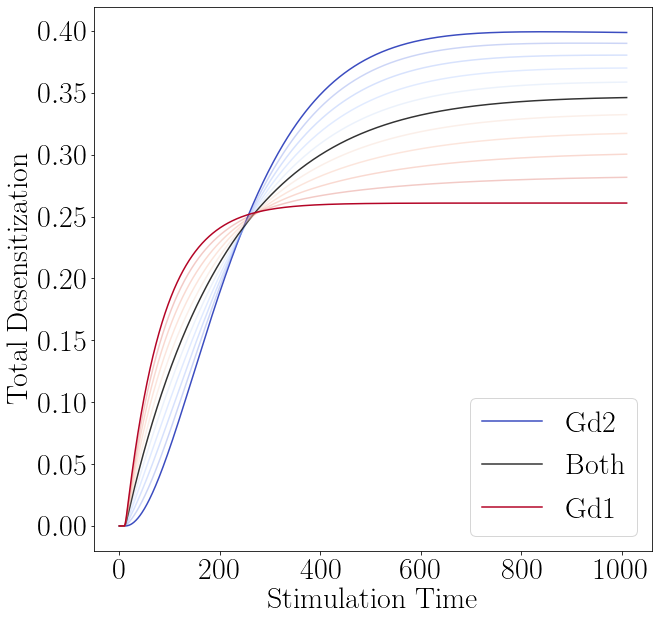

In [86]:
cfg.input_max = 0.1
slider = np.linspace(0, 1, 11)
cmap = matplotlib.cm.get_cmap('coolwarm')
cfg.input_duration = 1000
fig = plt.figure(figsize=(10, 10))
labels = ['Gd2', 'Both', 'Gd1']
label_count = 0

for mod in slider:
    if mod == 0 or mod == 0.5 or mod == 1:
        alpha = 1
        label = labels[label_count]
        label_count += 1
    else:
        alpha = 0.3
        label = None
        
    if mod == 0.5:
        alpha = 0.8
        color = 'k'
    else:
        color = cmap(mod)
    cfg.kd1 = cfg.kd1 * mod
    cfg.kd2 = cfg.kd2 * (1 - mod)
    sol = run_experiment('pulse', t_f=1010, max_step=1)
    Gd = cfg.Gd1 + cfg.Gd2
    
    plt.plot(cfg.t, Gd, c=color, alpha=alpha, label=label)
    
    cfg.kd1 = 0.02
    cfg.kd2 = 0.6
    
    
plt.xlabel('Stimulation Time')
plt.ylabel('Total Desensitization')
plt.legend()
plt.savefig('figures/poster_plots/Gd1Gd2_desensitization_curves.png', bbox_inches='tight')


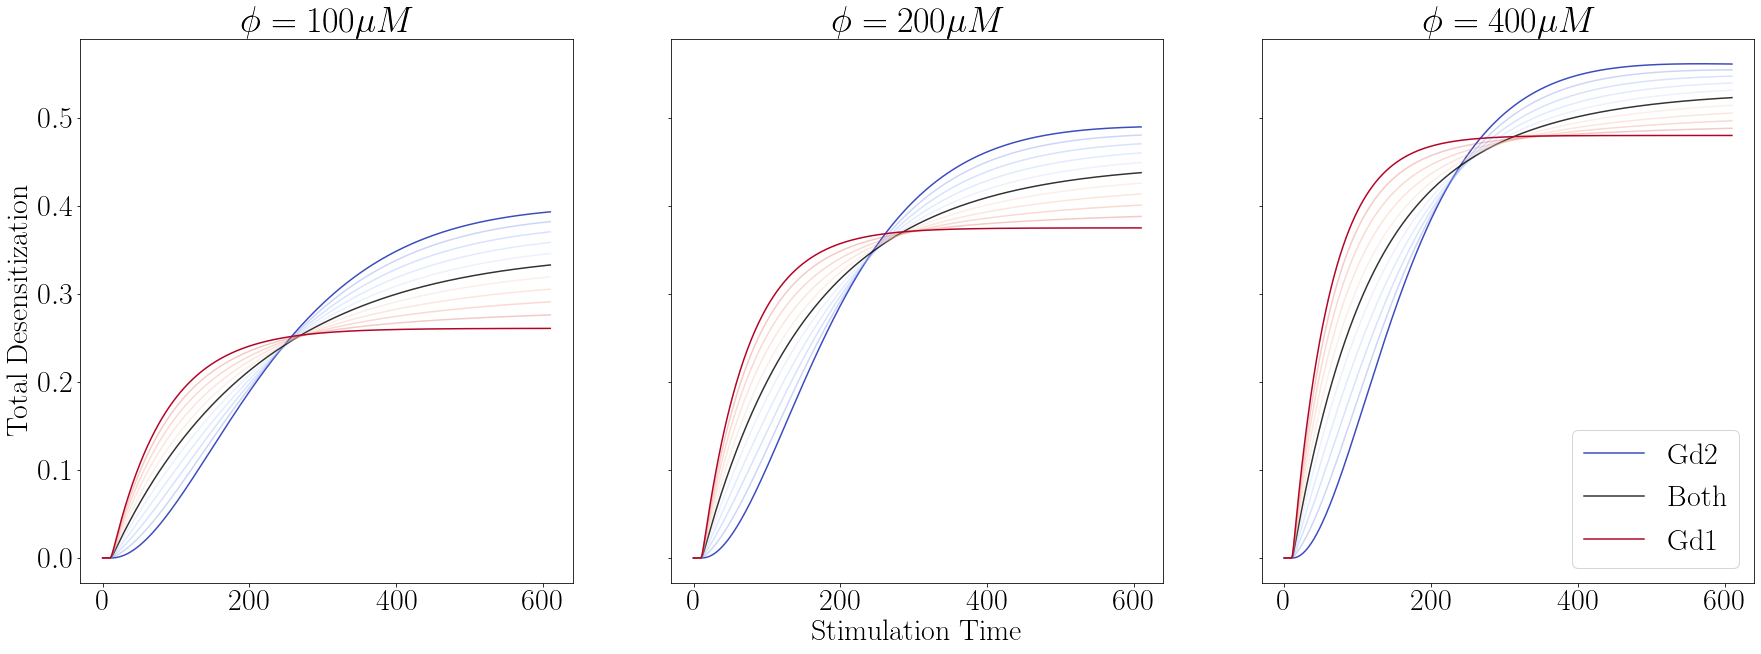

In [99]:
cfg.input_max = 0.1
cfg.input_duration = 600
slider = np.linspace(0, 1, 11)
cmap = matplotlib.cm.get_cmap('coolwarm')

fig, ax = plt.subplots(1, 3, figsize=(30, 10), sharey=True)
labels = ['Gd2', 'Both', 'Gd1']

for i, glut in enumerate([0.1, 0.2, 0.4]):
    label_count = 0
    cfg.input_max = glut
    for mod in slider:
        if mod == 0 or mod == 0.5 or mod == 1:
            alpha = 1
            label = labels[label_count]
            label_count += 1
        else:
            alpha = 0.3
            label = None

        if mod == 0.5:
            alpha = 0.8
            color = 'k'
        else:
            color = cmap(mod)
        cfg.kd1 = cfg.kd1 * mod
        cfg.kd2 = cfg.kd2 * (1 - mod)
        sol = run_experiment('pulse', t_f=610, max_step=1)
        Gd = cfg.Gd1 + cfg.Gd2

        ax[i].plot(cfg.t, Gd, c=color, alpha=alpha, label=label)

        cfg.kd1 = 0.02
        cfg.kd2 = 0.6
    ax[i].set_title(r'$\phi={} \mu M$'.format(int(glut * 1000)))
    
    
ax[1].set_xlabel('Stimulation Time')
ax[0].set_ylabel('Total Desensitization')
ax[2].legend()


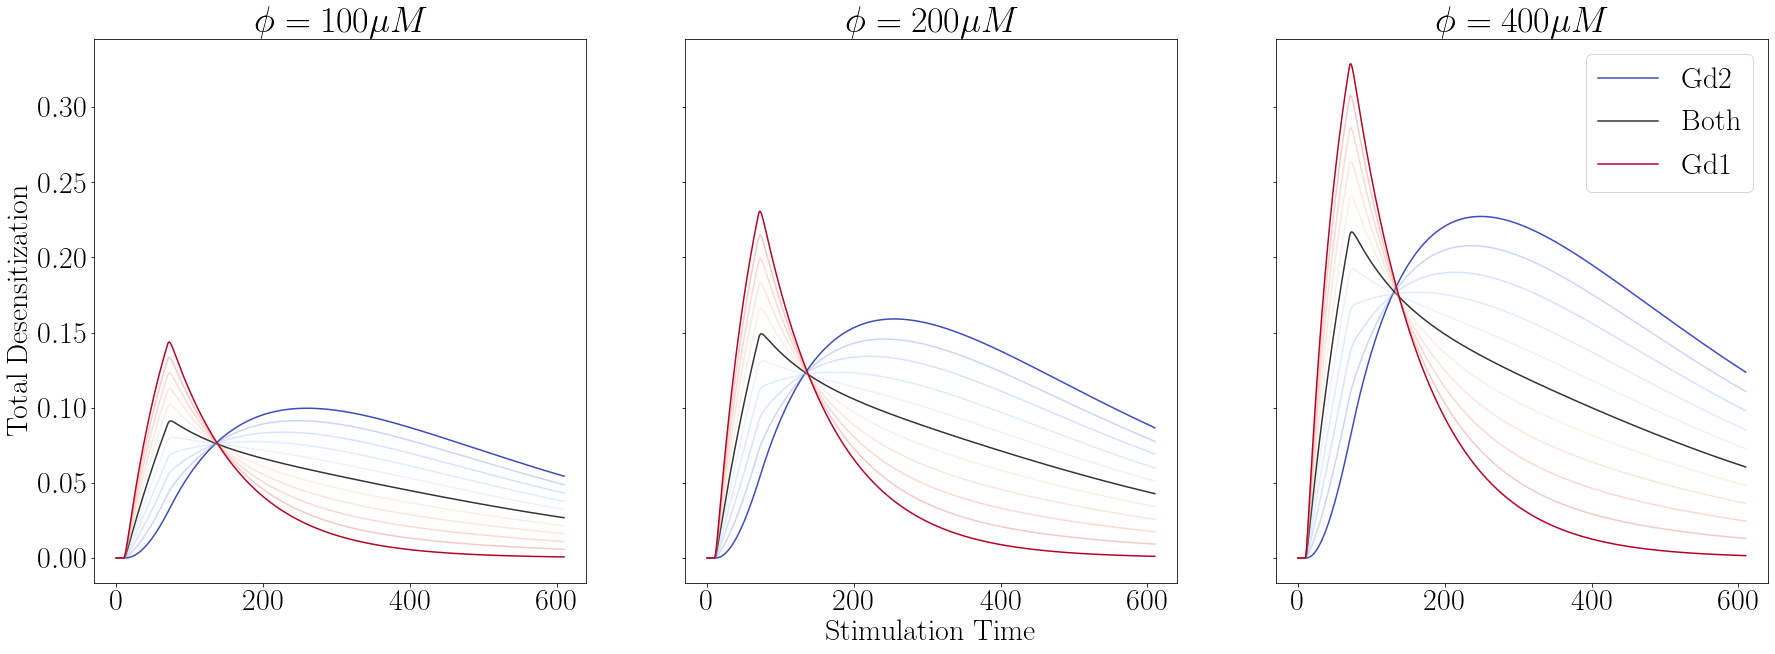

In [100]:
cfg.input_max = 0.1
cfg.input_duration = 60
slider = np.linspace(0, 1, 11)
cmap = matplotlib.cm.get_cmap('coolwarm')

fig, ax = plt.subplots(1, 3, figsize=(30, 10), sharey=True)
labels = ['Gd2', 'Both', 'Gd1']

for i, glut in enumerate([0.1, 0.2, 0.4]):
    label_count = 0
    cfg.input_max = glut
    for mod in slider:
        if mod == 0 or mod == 0.5 or mod == 1:
            alpha = 1
            label = labels[label_count]
            label_count += 1
        else:
            alpha = 0.3
            label = None

        if mod == 0.5:
            alpha = 0.8
            color = 'k'
        else:
            color = cmap(mod)
        cfg.kd1 = cfg.kd1 * mod
        cfg.kd2 = cfg.kd2 * (1 - mod)
        sol = run_experiment('pulse', t_f=610, max_step=1)
        Gd = cfg.Gd1 + cfg.Gd2

        ax[i].plot(cfg.t, Gd, c=color, alpha=alpha, label=label)

        cfg.kd1 = 0.02
        cfg.kd2 = 0.6
    ax[i].set_title(r'$\phi={} \mu M$'.format(int(glut * 1000)))
    
    
ax[1].set_xlabel('Stimulation Time')
ax[0].set_ylabel('Total Desensitization')
ax[2].legend()


### Check how Gd1 Gd2 presence affect the opposite dynamics

345.4823059842482
412.7168441253876
197.48231733630635


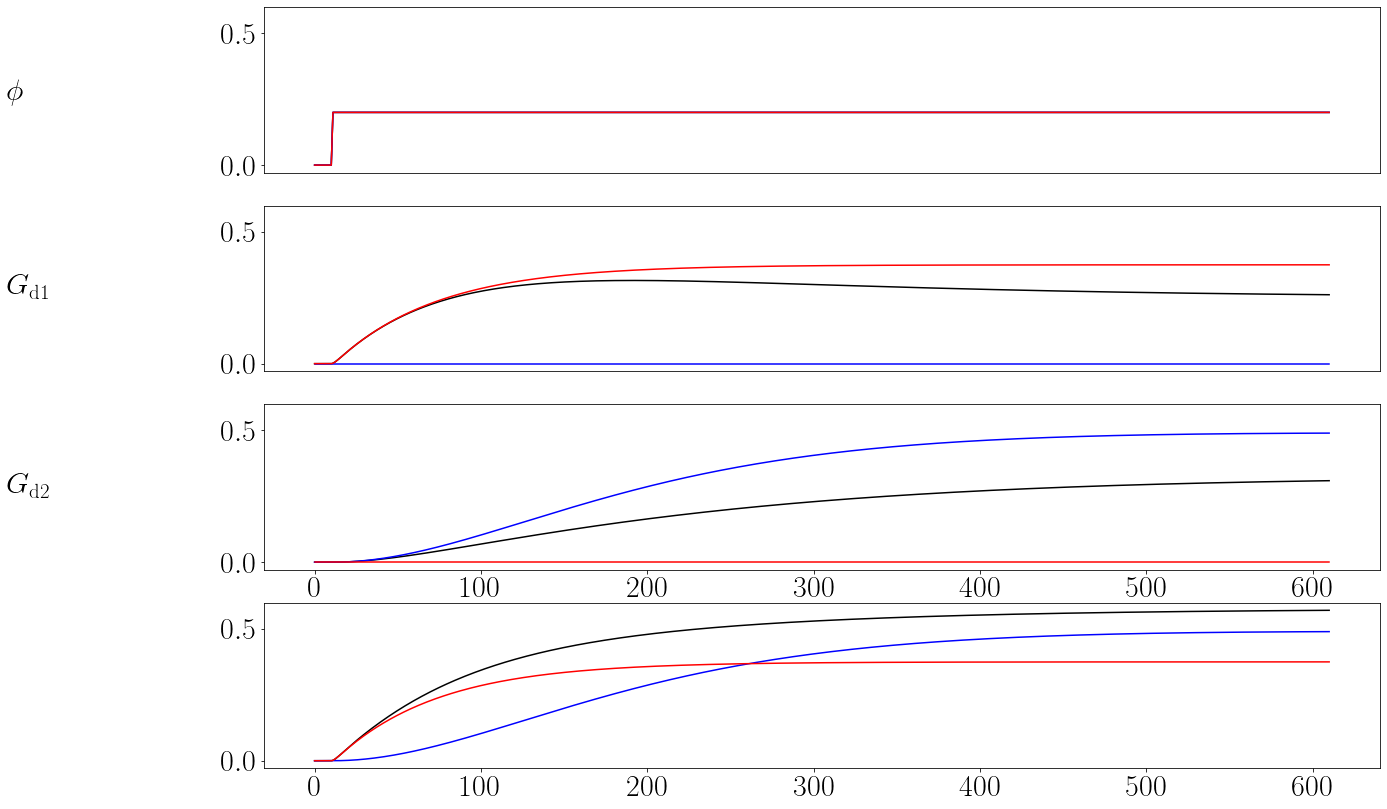

In [4]:
cfg.input_max = 0.2
cfg.input_duration = 600
cmap = matplotlib.cm.get_cmap('coolwarm')

fig, ax = plt.subplots(4, 1, figsize=(20, 14), sharey=True)
sol = run_experiment('pulse', max_step=1, t_f=610)
plot_experiment_plots(['glut', 'Gd1', 'Gd2'], ax, color='k')
Gd = cfg.Gd1 + cfg.Gd2
maxGd = np.max(Gd)
ax[3].plot(cfg.t, cfg.Gd1+cfg.Gd2, color='k')
print(cfg.t[np.argmax(Gd > maxGd * 0.95)])

cfg.kd1 = 0
sol = run_experiment('pulse', max_step=1, t_f=610)
plot_experiment_plots(['glut', 'Gd1', 'Gd2'], ax, color='blue')
Gd = cfg.Gd1 + cfg.Gd2
maxGd = np.max(Gd)
ax[3].plot(cfg.t, cfg.Gd1+cfg.Gd2, color='blue')
print(cfg.t[np.argmax(Gd > maxGd * 0.95)])
cfg.kd1 = 0.02

cfg.kd2 = 0
sol = run_experiment('pulse', max_step=1, t_f=610)
plot_experiment_plots(['glut', 'Gd1', 'Gd2'], ax, color='red')
Gd = cfg.Gd1 + cfg.Gd2
maxGd = np.max(Gd)
ax[3].plot(cfg.t, cfg.Gd1+cfg.Gd2, color='red')
print(cfg.t[np.argmax(Gd > maxGd * 0.95)])
cfg.kd2 = 0.6


### Relationship between input strength and maximum calcium

Text(0, 0.5, '$c_\\mathrm{max} (\\mu M)$')

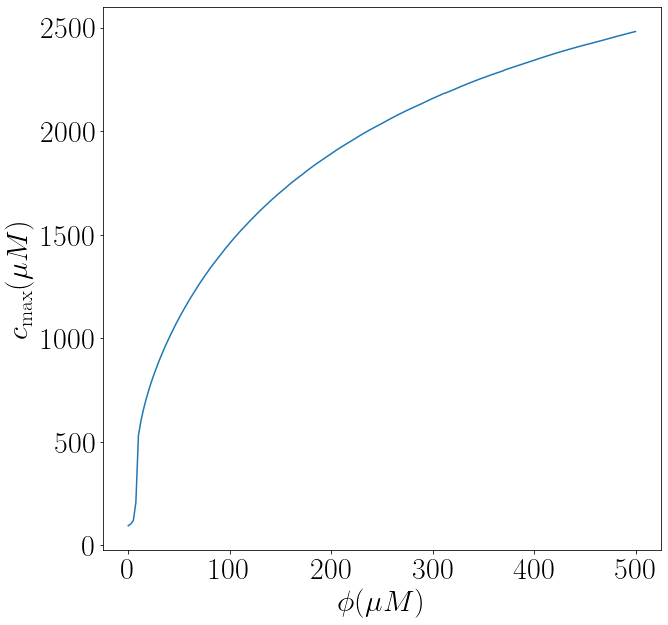

In [95]:
plt.figure(figsize=(10,10))
# glut_maxes = np.linspace(0, 0.5, 200)
# cfg.input_duration = 30
# c_maxes = []
# for glut in tqdm(glut_maxes):
#     cfg.input_max = glut
#     sol = run_experiment('pulse', t_f=50, max_step=0.2)
#     c_maxes.append(np.max(cfg.c))

glut_maxes, c_maxes = pickle.load(open('data/plot_data/relationship_between_glut_cmax', 'rb'))
    
plt.plot(glut_maxes * 1000, np.array(c_maxes) * 1000)
plt.xlabel(r'$\phi (\mu M)$')
plt.ylabel(r'$c_\mathrm{max} (\mu M)$')

In [92]:
pickle.dump([glut_maxes, c_maxes], open('data/plot_data/relationship_between_glut_cmax', 'wb'))

In [144]:
def set_new_initial_conditions():
    '''
    set the initial conditions based on the last run experiment
    returns the previous initial condition
    '''
    all_init = cfg.all_init.copy()
    
    cfg.all_init = [cfg.c[-1], cfg.c_tot[-1], cfg.h[-1], cfg.p[-1], cfg.Gstar[-1], cfg.Gd1[-1], cfg.Gd2[-1], cfg.lamb[-1]]
    
    return all_init

# Calcium response falloffs

Trying to record calcium traces similar to experimental ones which show falloff over time

Running into a problem with the oscillation amplitudes - the system always spikes "as soon as possible"

Note that there is a range of "expressable" amplitudes and frequencies - shown in 3.7 in plots.ipynb, that are dependent on level of negative feedback. Positive feedback does not meaningfully affect the range of amplitudes and frequencies that can be oscillated at, but negative feedback does. Decreasing negative feedback enhances amplitude expressability, but decreases frequency expressability.

In [92]:
cfg.Gstar.max()

0.17040065924501674

In [96]:
cfg.kd2

0.6

## Effects of Gd1/Gd2 on Plateau Response

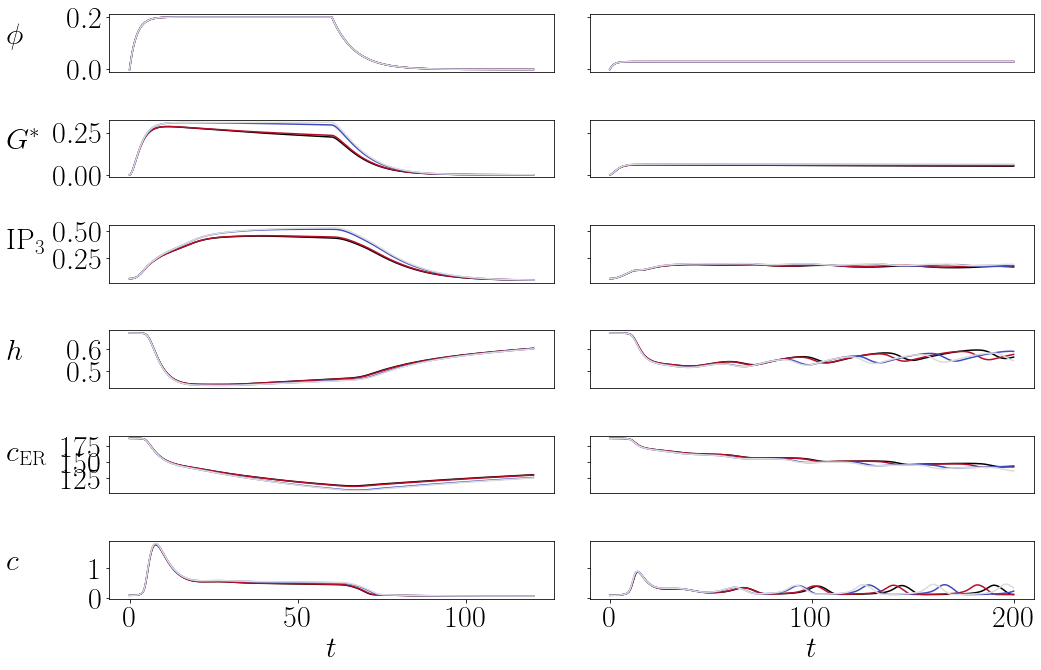

In [25]:
cfg.d_rise = 60
cfg.d_decay = 20
cfg.r_rise = 0.5
cfg.r_decay = compute_r_decay(0.1, 20)
cfg.A = 0.2
cfg.input_max = 0.2
cfg.input_duration = 60
cmap = matplotlib.cm.get_cmap('coolwarm')

configs = [[0.02, 0.6], [0.02, 0], [0, 0.6], [0,0]] #configs for kd1, kd2
# configs = [[0.02, 0.6]]
labels = ['G$_\mathrm{d1}$ and G$_\mathrm{d2}$', 'Only G$_\mathrm{d1}$', 'Only G$_\mathrm{d2}$', 'No GPCR Desensitization']
colors = ['k', cmap(0.99), cmap(0.001), cmap(0.5)]

fig, ax = plt.subplots(6, 2, figsize=(15,10), sharey='row')

for i, config in enumerate(configs):
    cfg.kd1 = config[0]
    cfg.kd2 = config[1]
    cfg.d_rise = 60
    cfg.A = 0.2
    sol = run_experiment('curve', t_f=120, max_step=0.2)
    plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], ax[:,0], legend_label=labels[i], color=colors[i])
    cfg.d_rise = 200
    cfg.A = 0.03
    sol = run_experiment('curve', t_f=200, max_step=0.2)
    plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], ax[:,1], legend_label=labels[i], color=colors[i], add_ylabels=False)

cfg.kd1 = 0.02
cfg.kd2 = 0.6
plt.tight_layout()
plt.savefig('figures/poster_plots/plateau', bbox_inches='tight')

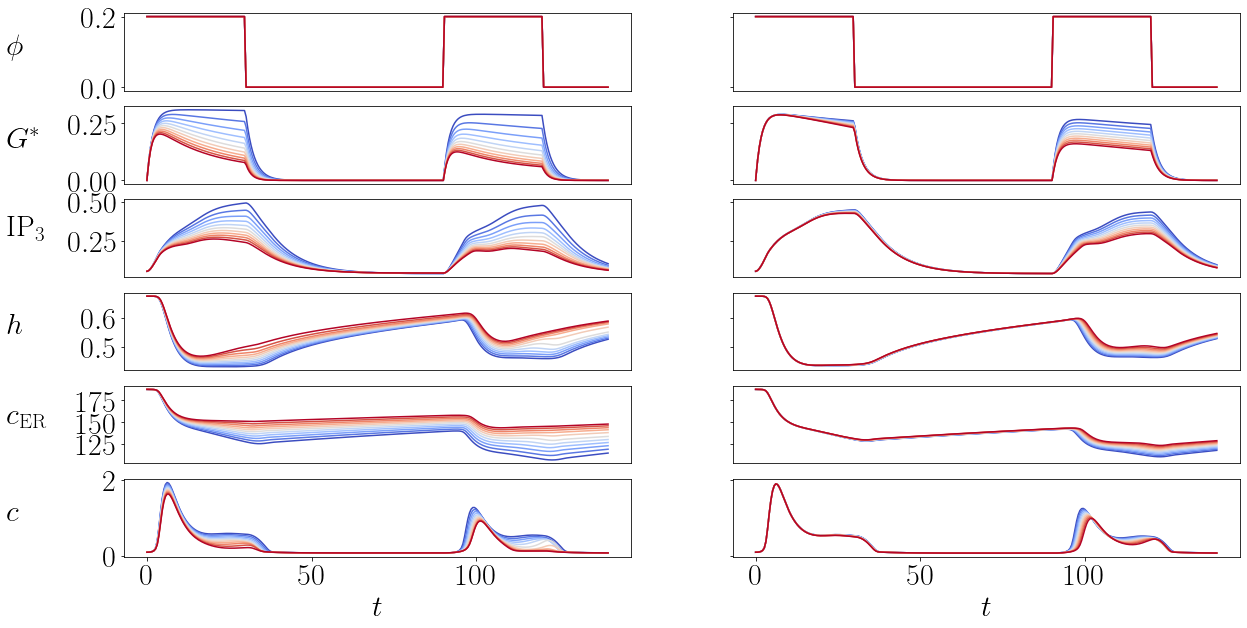

In [20]:
cfg.input_max = 0.2
cfg.input_duration = 30
fig, ax = plt.subplots(6, 2, figsize=(20,10), sharey='row')

slider = np.linspace(0, 10, 11)
cmap = matplotlib.cm.get_cmap('coolwarm')
# sol = run_experiment('curve', t_f=80, max_step=0.5, fix_c_er=160)
# plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)
cfg.num_oscillations = 2
cfg.oscillation_on_duration = 30
cfg.oscillation_off_duration = 60
kd1 = 0.02
kd2 = 0.6
for mod in slider:
    cfg.kd1 = mod * kd1
    sol = run_experiment('oscillation', t_f=140, max_step=0.5)
    plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], ax[:, 0], color=cmap(mod/10))
    cfg.kd1 = kd1
    cfg.kd2 = mod * kd2
    sol = run_experiment('oscillation', t_f=140, max_step=0.5)
    plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], ax[:, 1], color=cmap(mod/10), add_ylabels=False)
    cfg.kd2 = kd2

    
# cfg.kd1 = 0.2
# cfg.kd2 = 6
# cfg.kd1 = 0.02
# cfg.kd2 = 0.6

In [201]:
gs2[0]

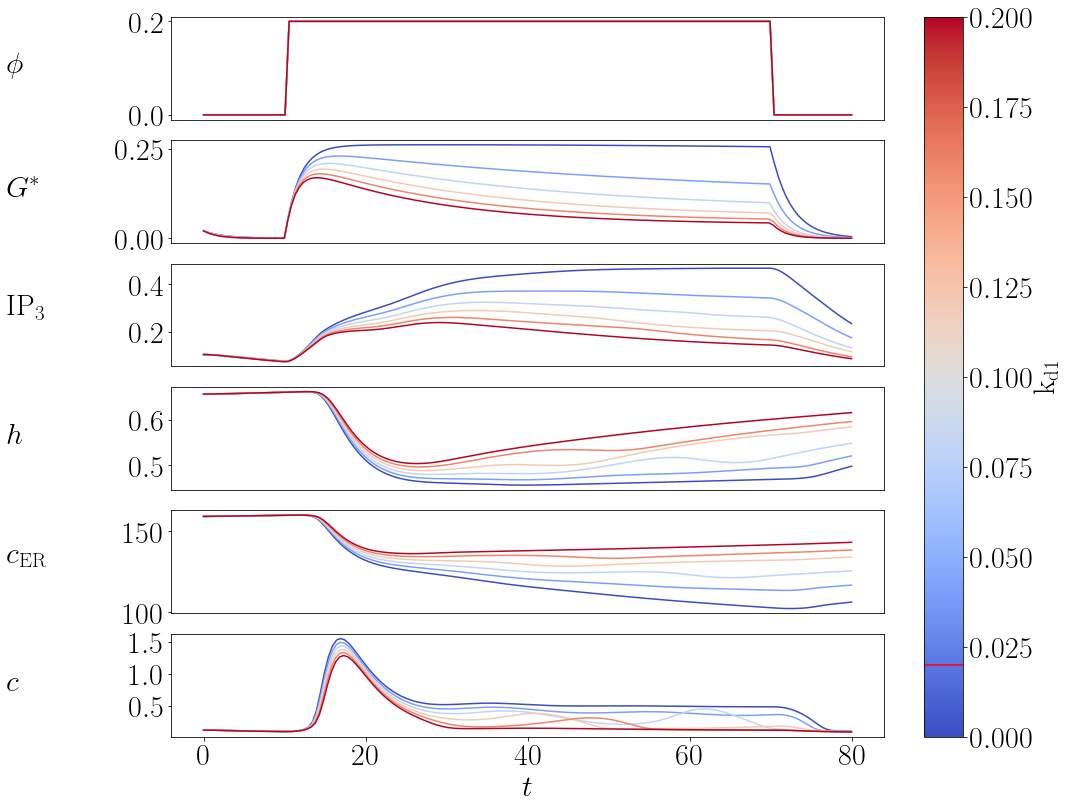

In [15]:
cfg.input_max = 0.2
cfg.input_duration = 60
sol = run_experiment('pulse', t_f=80, max_step=0.5)
# fig, ax = plt.subplots(6, 1, figsize=(10,10))
fig = plt.figure(constrained_layout=False, figsize=(11, 10))
gs = fig.add_gridspec(nrows=6, ncols=1, left=0, right=0.9, top=1, bottom=0)
ax = [fig.add_subplot(gs[i]) for i in range(6)]

gs2 = fig.add_gridspec(1, 1, left=0.95, right=1, top=1, bottom=0)
ax2 = fig.add_subplot(gs2[0])

slider = np.linspace(0, 10, 6)
cmap = matplotlib.cm.get_cmap('coolwarm')
# sol = run_experiment('curve', t_f=80, max_step=0.5, fix_c_er=160)
# plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)

kd1 = 0.02
cfg.kd2 = 0.6
for mod in slider:
#     print(cfg.kd1, cfg.kd2)
    cfg.kd1 = mod * kd1
#     cfg.kd2 = mod * kd2
    sol = run_experiment('pulse', t_f=80, max_step=0.5)
    plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], ax, color=cmap(mod/10))
    
norm = matplotlib.colors.Normalize(vmin=0, vmax=0.2)
cb1 = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='vertical')
cb1.set_label('k$_\mathrm{d1}$')
ax2.plot([0, 1], [0.02, 0.02], c='red')

# plt.savefig('figures/poster_plots/kd1_plateau', bbox_inches='tight')

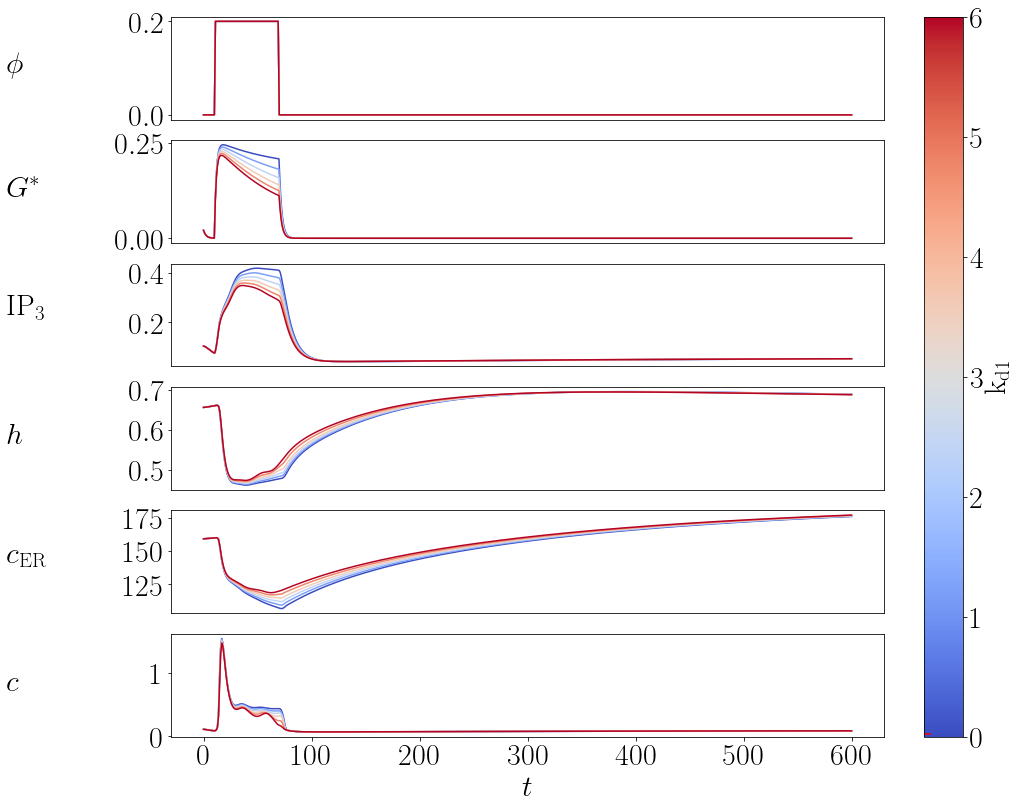

In [18]:
cfg.input_max = 0.2
cfg.input_duration = 60
sol = run_experiment('pulse', t_f=80, max_step=0.5)
# fig, ax = plt.subplots(6, 1, figsize=(10,10))
fig = plt.figure(constrained_layout=False, figsize=(11, 10))
gs = fig.add_gridspec(nrows=6, ncols=1, left=0, right=0.9, top=1, bottom=0)
ax = [fig.add_subplot(gs[i]) for i in range(6)]

gs2 = fig.add_gridspec(1, 1, left=0.95, right=1, top=1, bottom=0)
ax2 = fig.add_subplot(gs2[0])

slider = np.linspace(0, 10, 6)
cmap = matplotlib.cm.get_cmap('coolwarm')
# sol = run_experiment('curve', t_f=80, max_step=0.5, fix_c_er=160)
# plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)

cfg.kd1 = 0.02
cfg.kd2 = 0.6
for mod in slider:
#     print(cfg.kd1, cfg.kd2)
#     cfg.kd1 = mod * kd1
    cfg.kd2 = mod * kd2
    sol = run_experiment('pulse', t_f=600, max_step=1)
    plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], ax, color=cmap(mod/10))
    
norm = matplotlib.colors.Normalize(vmin=0, vmax=6)
cb1 = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='vertical')
cb1.set_label('k$_\mathrm{d1}$')
ax2.plot([0, 1], [0.02, 0.02], c='red')

# plt.savefig('figures/poster_plots/kd1_plateau', bbox_inches='tight')

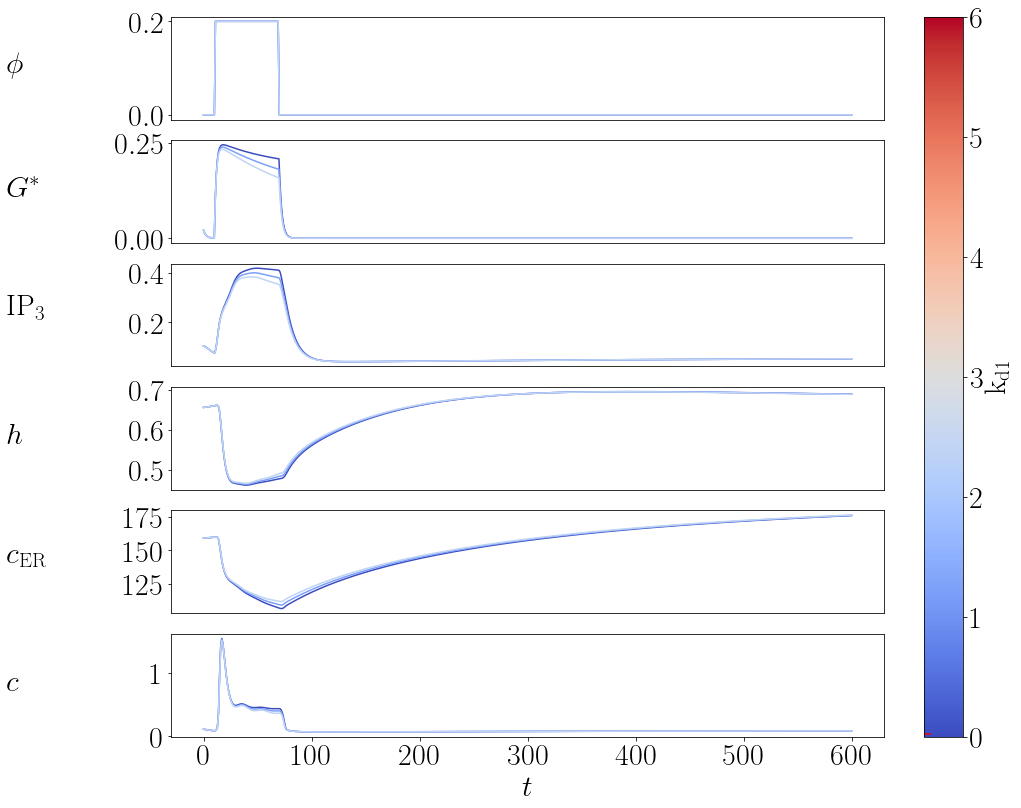

In [19]:
cfg.input_max = 0.2
cfg.input_duration = 60
sol = run_experiment('pulse', t_f=80, max_step=0.5)
# fig, ax = plt.subplots(6, 1, figsize=(10,10))
fig = plt.figure(constrained_layout=False, figsize=(11, 10))
gs = fig.add_gridspec(nrows=6, ncols=1, left=0, right=0.9, top=1, bottom=0)
ax = [fig.add_subplot(gs[i]) for i in range(6)]

gs2 = fig.add_gridspec(1, 1, left=0.95, right=1, top=1, bottom=0)
ax2 = fig.add_subplot(gs2[0])

slider = np.linspace(0, 4, 3)
cmap = matplotlib.cm.get_cmap('coolwarm')
# sol = run_experiment('curve', t_f=80, max_step=0.5, fix_c_er=160)
# plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)

cfg.kd1 = 0.02
cfg.kd2 = 0.6
for mod in slider:
#     print(cfg.kd1, cfg.kd2)
#     cfg.kd1 = mod * kd1
    cfg.kd2 = mod * kd2
    sol = run_experiment('pulse', t_f=600, max_step=1)
    plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], ax, color=cmap(mod/10))
    
norm = matplotlib.colors.Normalize(vmin=0, vmax=6)
cb1 = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='vertical')
cb1.set_label('k$_\mathrm{d1}$')
ax2.plot([0, 1], [0.02, 0.02], c='red')

# plt.savefig('figures/poster_plots/kd1_plateau', bbox_inches='tight')

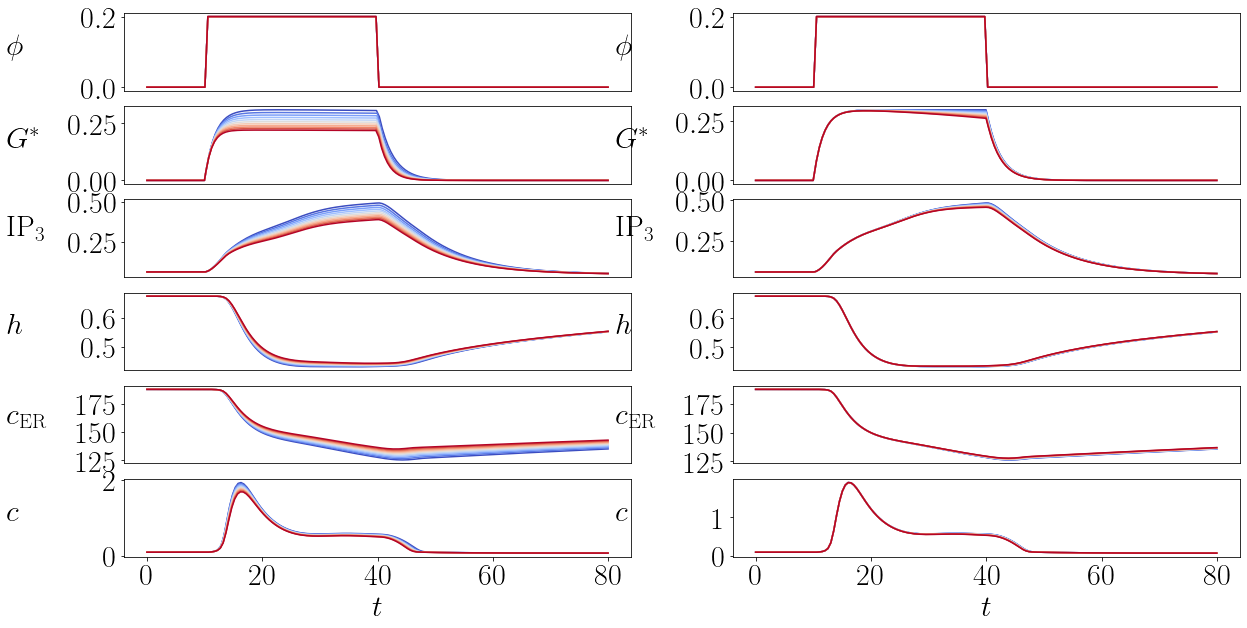

In [215]:
cfg.input_max = 0.2
cfg.input_duration = 30
sol = run_experiment('pulse', t_f=80, max_step=0.5)
fig, ax = plt.subplots(6, 2, figsize=(20,10))

slider = np.linspace(0, 10, 11)
cmap = matplotlib.cm.get_cmap('coolwarm')
# sol = run_experiment('curve', t_f=80, max_step=0.5, fix_c_er=160)
# plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)

kd1 = 0.02
kd2 = 0.6
for mod in slider:
    cfg.kd1 = mod * kd1
    sol = run_experiment('pulse', t_f=80, max_step=0.5)
    plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], ax[:, 0], color=cmap(mod/10))
    cfg.kd1 = kd1
    cfg.kd2 = mod * kd2
    sol = run_experiment('pulse', t_f=80, max_step=0.5)
    plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], ax[:, 1], color=cmap(mod/10))
    cfg.kd2 = kd2

    
# cfg.kd1 = 0.2
# cfg.kd2 = 6
# cfg.kd1 = 0.02
# cfg.kd2 = 0.6

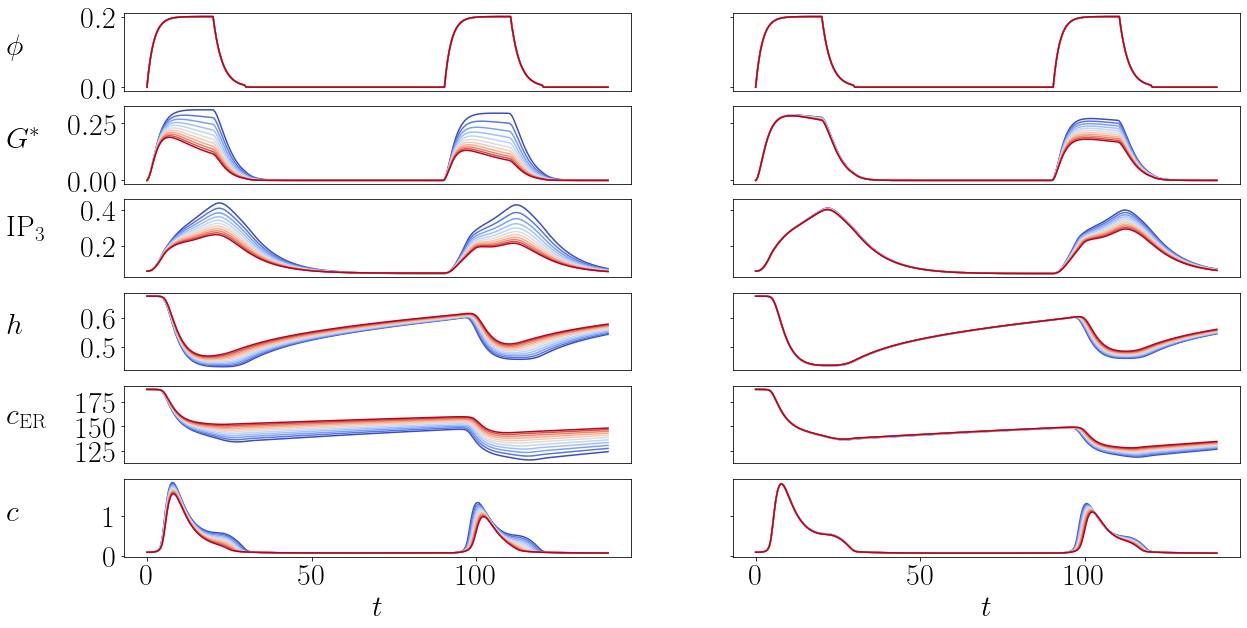

In [8]:
cfg.input_max = 0.2
cfg.input_duration = 30
cfg.r_rise = 0.5
cfg.d_rise = 20
cfg.d_decay = 10
cfg.A = 0.2
cfg.r_decay = compute_r_decay(cfg.A, cfg.d_decay)
cfg.oscillation_off_duration = 60
fig, ax = plt.subplots(6, 2, figsize=(20,10), sharey='row')

slider = np.linspace(0, 10, 11)
cmap = matplotlib.cm.get_cmap('coolwarm')
# sol = run_experiment('curve', t_f=80, max_step=0.5, fix_c_er=160)
# plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)
cfg.num_oscillations = 2
kd1 = 0.02
kd2 = 0.6
for mod in slider:
    cfg.kd1 = mod * kd1
    sol = run_experiment('exponential_oscillation', t_f=140, max_step=0.5)
    plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], ax[:, 0], color=cmap(mod/10))
    cfg.kd1 = kd1
    cfg.kd2 = mod * kd2
    sol = run_experiment('exponential_oscillation', t_f=140, max_step=0.5)
    plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], ax[:, 1], color=cmap(mod/10), add_ylabels=False)
    cfg.kd2 = kd2

    
# cfg.kd1 = 0.02
# cfg.kd2 = 0.6

In [37]:
hs = np.linspace(0.4, 0.8, 10)
c_tots = np.linspace(20, 30, 10)
set_init('default')
all_init = cfg.all_init

cfg.input_max = 0.1
cfg.input_duration = 30

mesh = np.meshgrid(hs, c_tots)
c_maxes = np.zeros(mesh[0].shape)
for i in range(10):
    for j in range(10):
        h = mesh[0][i, j]
        c_tot = mesh[1][i,j]
        cfg.all_init[2] = h
        cfg.all_init[1] = c_tot
        run_experiment('pulse', t_f=30, max_step=0.1)
        c_maxes[i,j] = np.max(cfg.c)
        
        
plt.imshow(np.flip(c_maxes, axis=0), interpolation='bilinear', extent=(0.4, 0.8, 20, 30), aspect='auto')
plt.colorbar()
plt.xlabel('h')
plt.ylabel('c$_\mathrm{tot}$')

## Effects of Gd1/Gd2/Ca2+->IP3 positive Feedback on Oscillation Amp/Freq

### Changing initial conditions G*, h, c_tot to see effect on initial spike amplitude

Note that we find that the true oscillation amplitudes are higher than the initial spikes suggested by this procedure, so it is not an accurate measure. It's better to look at freq/amp response curves dictated experimentally or by bifurcation diagram

We do have good code here for working with np.meshgrid though

In [91]:

hs = np.linspace(0.4, 0.8, 30)
c_tots = np.linspace(20, 30, 30)
Gstars = np.linspace(0.01, 0.4, 30)
mesh = np.meshgrid(hs, c_tots, Gstars)
#can access a grid of fixed value by indexing the mesh with all variables in the wanted plot
#and setting a gixed index in the fixed variable
#e.g., mesh[0] gives the hs mesh
# and mesh[0][:, :, 0] would give the plottable hs mesh with Gstar fixed to 0.01
c_maxes = np.zeros(mesh[0].shape)
for i in range(30):
    for j in range(30):
        for k in range(30):
            h = mesh[0][i,j,k]
            c_tot = mesh[1][i,j,k]
            Gstar = mesh[2][i,j,k]
            
            set_init('default')
            cfg.all_init[1] = c_tot
            cfg.all_init[2] = h
            cfg.input_max = Gstar
            run_Gstar_controlled_experiment('pulse', t_f=30, max_step=0.3)
            c_maxes[i,j,k] = np.max(cfg.c)
            
data = [mesh, c_maxes]
pickle.dump(data, open('data/plot_data/hctgstar_spike_mesh', 'wb'))

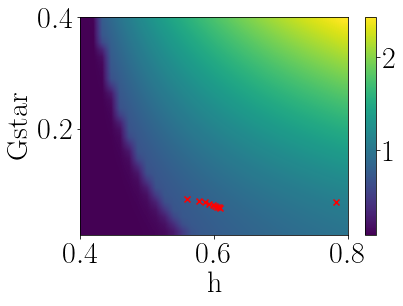

In [148]:
plt.imshow(np.flip(c_maxes[14,:,:], axis=0), extent=(0.4, 0.8, 0.01, 0.4), aspect='auto', interpolation='bilinear')
plt.xlabel('h')
plt.ylabel('Gstar')
plt.colorbar()
plt.scatter(cfg.h[peaks], cfg.Gstar[peaks], c='red', marker='x')

In [151]:
points = []
vals = []
h_mesh = mesh[0][14,:,:]
Gstar_mesh = mesh[2][14,:,:]
c_mesh = c_maxes[14,:,:]
for i in range(30):
    for j in range(30):
        points.append([h_mesh[i,j], Gstar_mesh[i,j]])
        vals.append(c_mesh[i,j])

In [154]:
targets = [[cfg.h[peak], cfg.Gstar[peak]] for peak in peaks]

scipy.interpolate.griddata(points, vals, targets)

array([0.98481992, 0.27282679, 0.39739965, 0.33455585, 0.26537033,
       0.23650921, 0.25751453, 0.26068341, 0.24208864, 0.2264093 ])

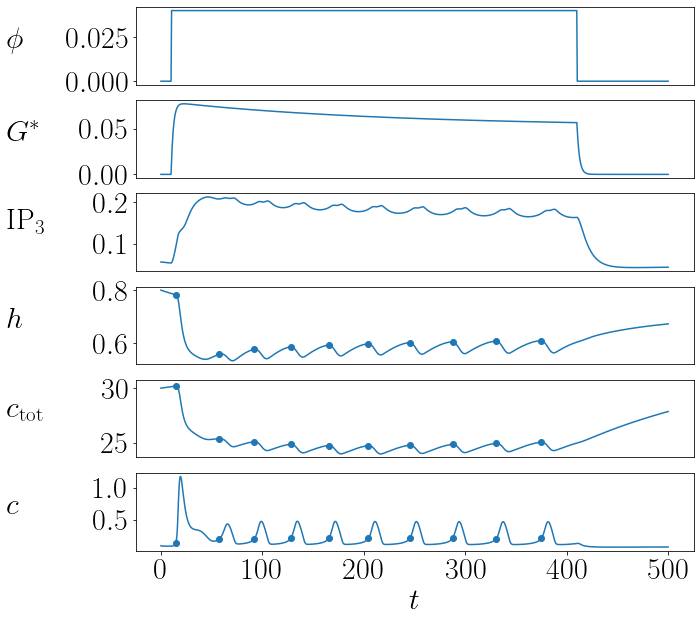

In [123]:
fig, ax = plt.subplots(6, 1, figsize=(10, 10))
plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_tot', 'c'], ax)
t, c, peaks = get_peaks('c_tot')
ax[4].scatter(t, c)
ax[5].scatter(t, cfg.c[peaks])
ax[3].scatter(t, cfg.h[peaks])

In [121]:
def get_peaks(var='c', troughs=False):
    '''
    Get the times and peaks for a variable
    '''
    data = getattr(cfg, var)
    if troughs:
        peaks = scipy.signal.find_peaks(-data)[0]
    else:
        peaks = scipy.signal.find_peaks(data)[0]
    return cfg.t[peaks], data[peaks], peaks
    
    


### Checking the oscillation amplitudes swept out by change in Gstar over desensitization

Basically looking to see what change of G* is experienced from Gd1+Gd2 and seeing what amplitudes this corresponds to. Notably, the amplitudes swept out are not large enough to be noticeable

In [37]:
data = pickle.load(open('data/plot_data/3.7_vdelta_freq_amp', 'rb'))
Gstars = data['vdelta_0.01_Gstar']
freqs = data['vdelta_0.01_freq']
amps = data['vdelta_0.01_abs_amp']


Amp low: 0.47954839864985144
Amp high: 0.5033612038433691


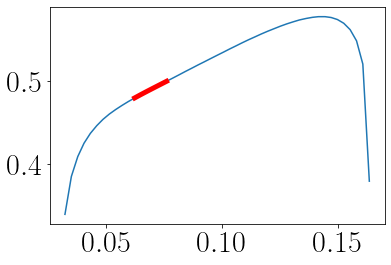

In [47]:
plt.plot(Gstars[:-1], amps[:-1])
low = np.argmax(Gstars > Gstar_low)
high = np.argmax(Gstars > Gstar_high)
plt.plot(Gstars[low:high], amps[low:high], c='red', linewidth=5)
print('Amp low: {}'.format(amps[low]))
print('Amp high: {}'.format(amps[high]))

### Testing conditions that actually influence calcium oscillation amplitude/freq changes

Basically we find that Gd1 changes the amp/freq, but not noticeably over the course of a bath

Gd2 is noticeable over the course of several spikes (as we hope to see in the data), but needs to be larger than our base parameters. With the default settings, this is only noticeable in frequency changes

Looking at freq/amp response curves with different levels of Ca2+ -> IP3 feedback (in plots.ipynb), we see that to actually get a noticeable amplitude change, we need to decrease positive feedback (vdelta 0.01 -> 0.005)

Coupling this change with an increase in Gd2 (kd2 0.06 -> 0.12) produces oscillation amplitude/freq changes similar to experimental data

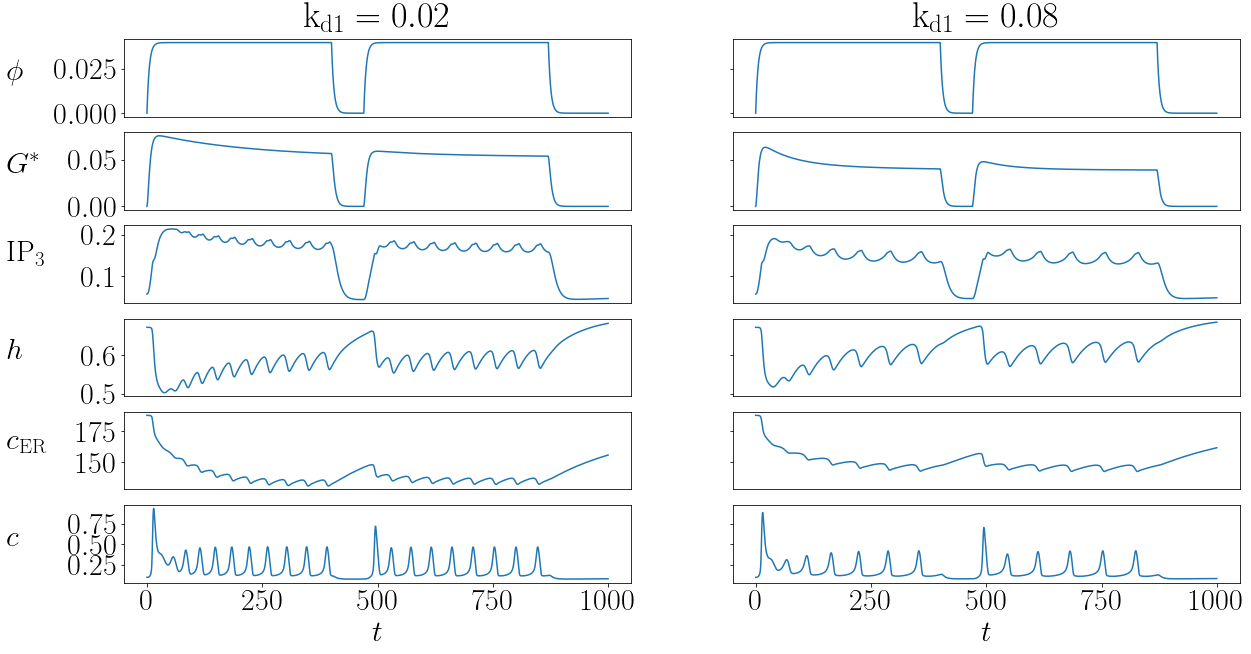

In [241]:
fig, ax = plt.subplots(6, 2, figsize=(20,10), sharey='row')
set_init('default')
# cfg.all_init[1] = cfg.all_init[1] * 0.6
cfg.input_max = 0.1
cfg.input_duration = 400
cfg.A = 0.04
cfg.d_rise = 400
cfg.r_rise = 0.2

slider = np.linspace(0, 3, 4)
cmap = matplotlib.cm.get_cmap('coolwarm')
# sol = run_experiment('curve', t_f=80, max_step=0.5, fix_c_er=160)
# plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)
cfg.num_oscillations = 2
kd1 = 0.02
kd2 = 0.6

cfg.kd1 = kd1 * 1
sol = run_experiment('exponential_oscillation', t_f=1000, max_step=0.5)
plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], ax[:, 0])
cfg.kd1 = kd1 * 4
sol = run_experiment('exponential_oscillation', t_f=1000, max_step=0.5)
plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], ax[:, 1], add_ylabels=False)

ax[0,0].set_title('k$_\mathrm{d1}=0.02$')
ax[0,1].set_title('k$_\mathrm{d1}=0.08$')

cfg.kd1 = 0.02
cfg.kd2 = 0.6

plt.savefig('figures/poster_plots/kd1_oscillation')

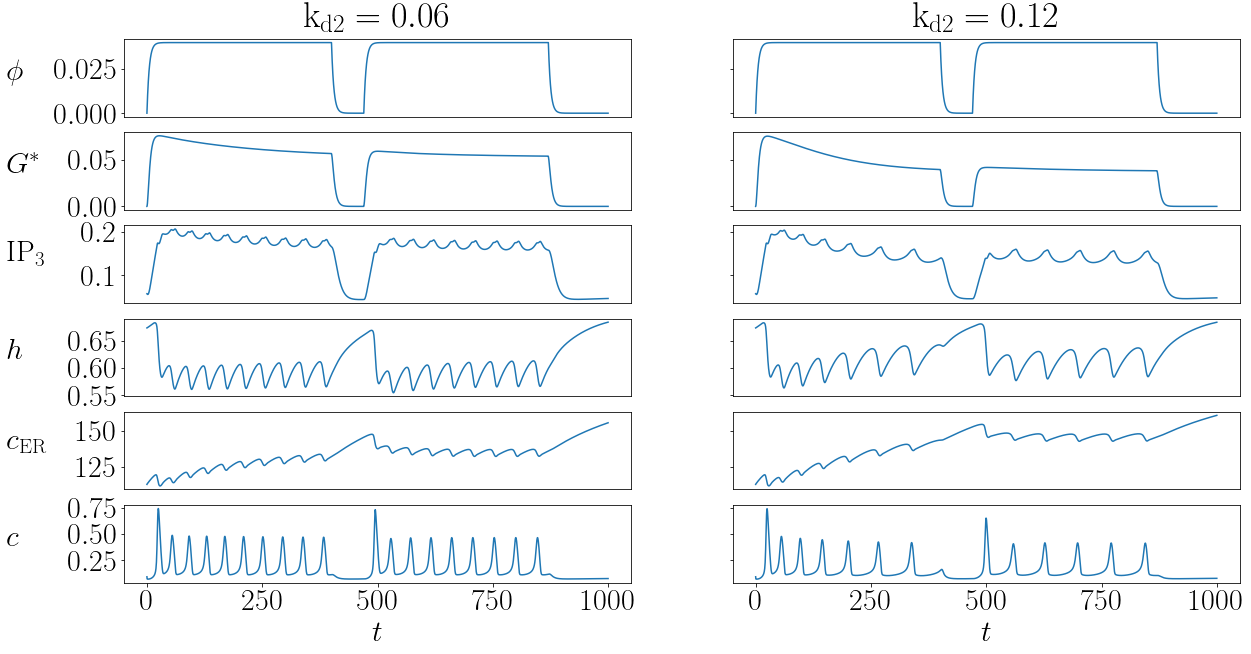

In [232]:
fig, ax = plt.subplots(6, 2, figsize=(20,10), sharey='row')
set_init('default')
cfg.all_init[1] = cfg.all_init[1] * 0.6
cfg.input_max = 0.1
cfg.input_duration = 400
cfg.A = 0.04
cfg.d_rise = 400
cfg.r_rise = 0.2

slider = np.linspace(0, 3, 4)
cmap = matplotlib.cm.get_cmap('coolwarm')
# sol = run_experiment('curve', t_f=80, max_step=0.5, fix_c_er=160)
# plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)
cfg.num_oscillations = 2
kd1 = 0.02
kd2 = 0.6

cfg.kd2 = kd2 * 1
sol = run_experiment('exponential_oscillation', t_f=1000, max_step=0.5)
plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], ax[:, 0])
cfg.kd2 = kd2 * 4
sol = run_experiment('exponential_oscillation', t_f=1000, max_step=0.5)
plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], ax[:, 1], add_ylabels=False)

ax[0,0].set_title('k$_\mathrm{d2}=0.06$')
ax[0,1].set_title('k$_\mathrm{d2}=0.12$')

cfg.kd1 = 0.02
cfg.kd2 = 0.6

plt.savefig('figures/poster_plots/kd2_oscillation')

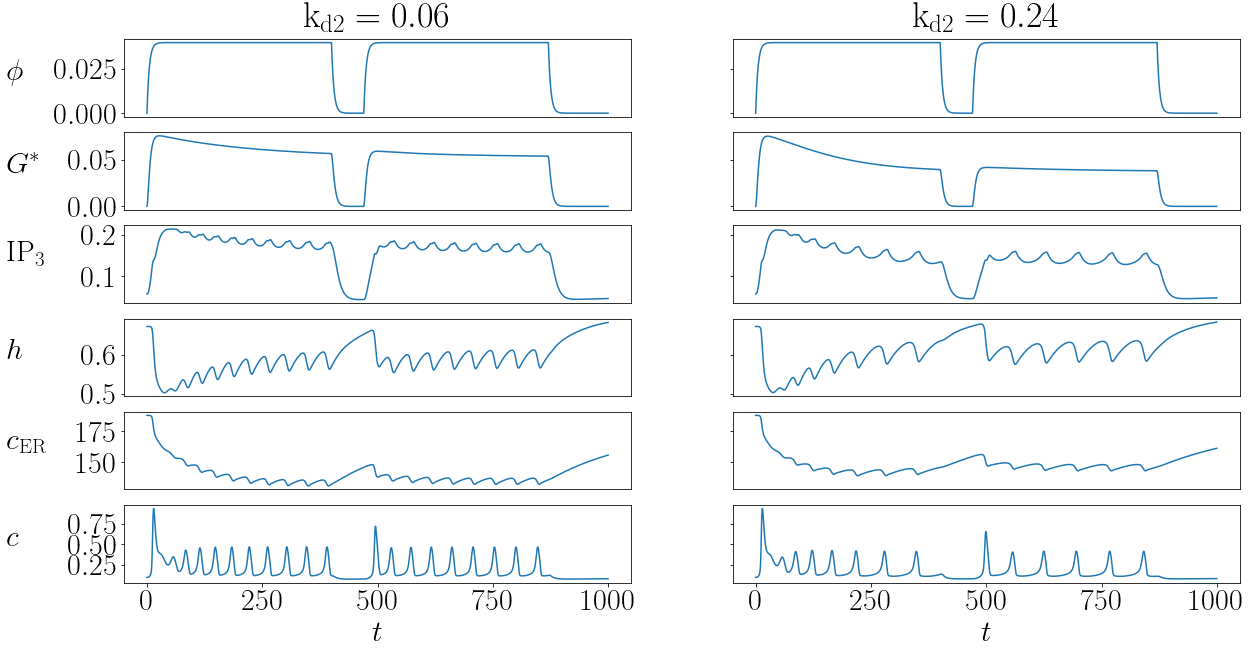

In [240]:
fig, ax = plt.subplots(6, 2, figsize=(20,10), sharey='row')
set_init('default')
# cfg.all_init[1] = cfg.all_init[1] * 0.6
cfg.input_max = 0.1
cfg.input_duration = 400
cfg.A = 0.04
cfg.d_rise = 400
cfg.r_rise = 0.2

slider = np.linspace(0, 3, 4)
cmap = matplotlib.cm.get_cmap('coolwarm')
# sol = run_experiment('curve', t_f=80, max_step=0.5, fix_c_er=160)
# plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)
cfg.num_oscillations = 2
kd1 = 0.02
kd2 = 0.6

cfg.kd2 = kd2 * 1
sol = run_experiment('exponential_oscillation', t_f=1000, max_step=0.5)
plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], ax[:, 0])
cfg.kd2 = kd2 * 4
sol = run_experiment('exponential_oscillation', t_f=1000, max_step=0.5)
plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], ax[:, 1], add_ylabels=False)

ax[0,0].set_title('k$_\mathrm{d2}=0.06$')
ax[0,1].set_title('k$_\mathrm{d2}=0.24$')

cfg.kd1 = 0.02
cfg.kd2 = 0.6

plt.savefig('figures/poster_plots/kd2_oscillation')

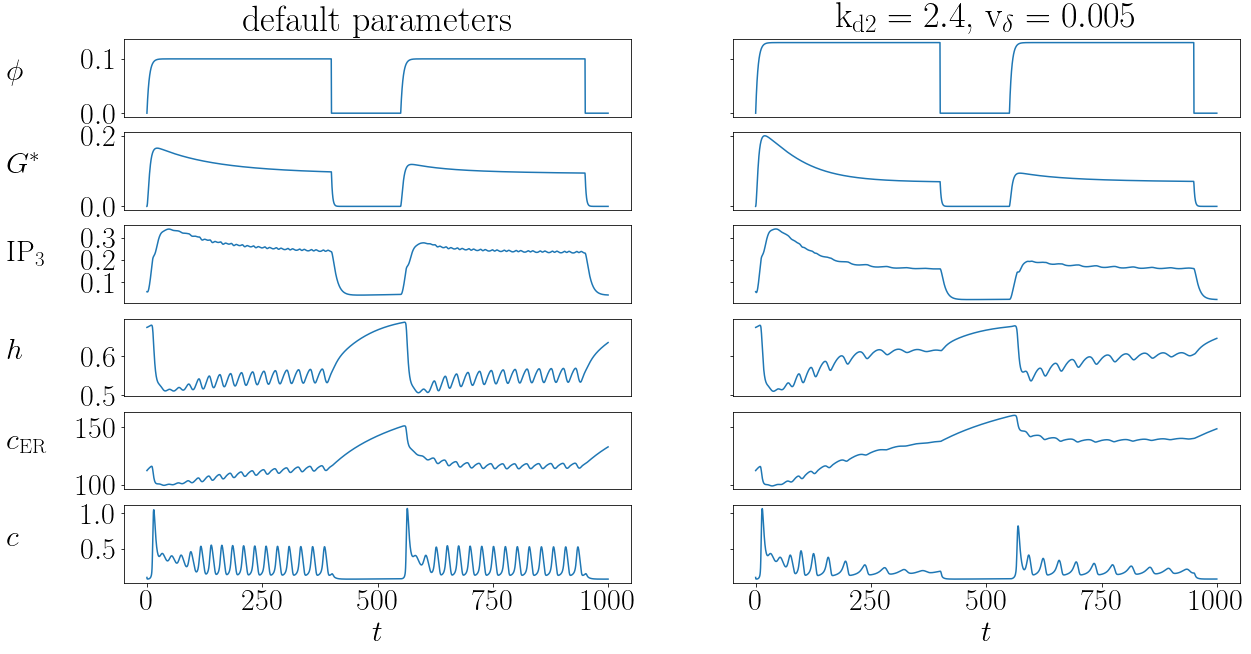

In [101]:
fig, ax = plt.subplots(6, 2, figsize=(20,10), sharey='row')
set_init('default')
cfg.all_init[1] = cfg.all_init[1] * 0.6
cfg.input_max = 0.1
cfg.input_duration = 400
cfg.A = 0.1
cfg.d_rise = 400
cfg.r_rise = 0.2

slider = np.linspace(0, 3, 4)
cmap = matplotlib.cm.get_cmap('coolwarm')
# sol = run_experiment('curve', t_f=80, max_step=0.5, fix_c_er=160)
# plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)
cfg.num_oscillations = 2
kd1 = 0.02
kd2 = 0.6

cfg.kd2 = kd2 * 1
sol = run_experiment('exponential_oscillation', t_f=1000, max_step=0.5)
plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], ax[:, 0])
cfg.A = 0.13
cfg.kd2 = kd2 * 4
cfg.v_delta = 0.005
sol = run_experiment('exponential_oscillation', t_f=1000, max_step=0.5)
plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], ax[:, 1], add_ylabels=False)

ax[0,0].set_title('default parameters')
ax[0,1].set_title('k$_\mathrm{d2}=2.4$, v$_\delta=0.005$')
cfg.v_delta = 0.01
cfg.kd1 = 0.02
cfg.kd2 = 0.6

plt.savefig('figures/poster_plots/kd2_oscillation_vdelta_0.005.png', bbox_inches='tight')

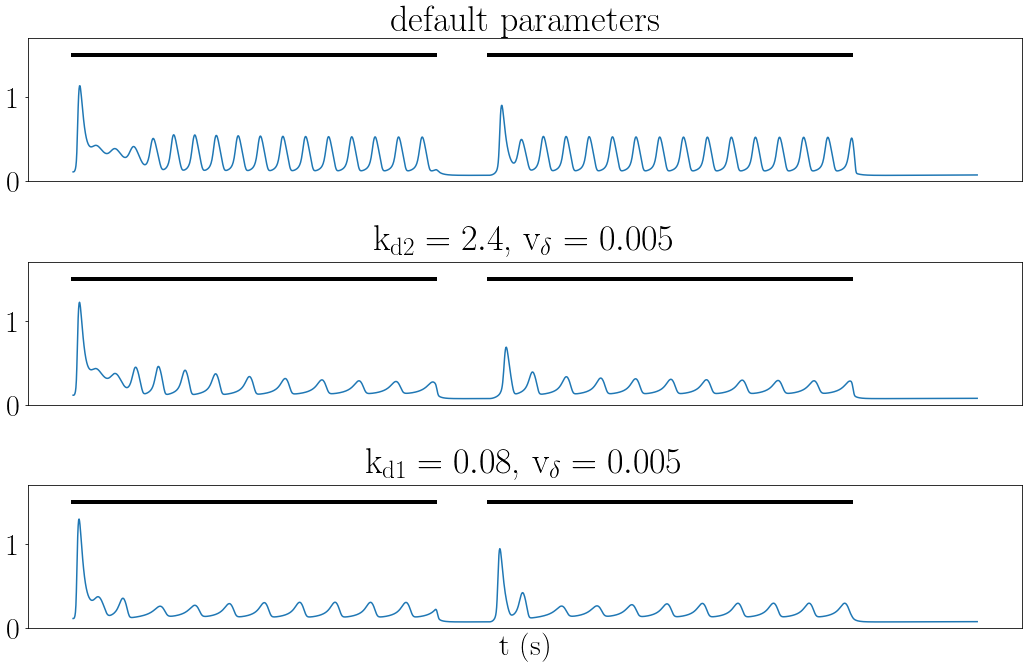

In [172]:
fig, ax = plt.subplots(3, 1, figsize=(15,10), sharey=True)
set_init('poisson')
cfg.input_max = 0.1
cfg.input_duration = 400

cmap = matplotlib.cm.get_cmap('coolwarm')
cfg.num_oscillations = 2
kd1 = 0.02
kd2 = 0.6

cfg.kd1 = kd1
cfg.kd2 = kd2
cfg.v_delta = 0.01
sol = run_experiment('oscillation', t_f=1000, max_step=0.5)
ax[0].plot(cfg.t, cfg.c)

cfg.input_max = 0.15
cfg.kd2 = kd2 * 4
cfg.v_delta = 0.005
sol = run_experiment('oscillation', t_f=1000, max_step=0.5)
ax[1].plot(cfg.t, cfg.c)

cfg.kd2 = kd2
cfg.kd1 = kd1 * 4
cfg.input_max = 0.2
sol = run_experiment('oscillation', t_f=1000, max_step=0.5)
ax[2].plot(cfg.t, cfg.c)


ax[0].set_title('default parameters')
ax[1].set_title('k$_\mathrm{d2}=2.4$, v$_\delta=0.005$')
ax[2].set_title('k$_\mathrm{d1}=0.08$, v$_\delta=0.005$')


for j in range(3):
    ax[j].plot([0, 400], [1.5, 1.5], color='k', linewidth=4)
    ax[j].plot([460, 860], [1.5, 1.5], color='k', linewidth=4)
#     ax[j].spines['top'].set_visible(False)
#     ax[j].spines['right'].set_visible(False)
    ax[j].set_ylim([0, 1.7])
    if j < 3:
        ax[j].set_xticks([])

ax[2].set_xlabel('t (s)')
cfg.v_delta = 0.01
cfg.kd1 = 0.02
cfg.kd2 = 0.6

plt.tight_layout()

plt.savefig('figures/poster_plots/oscillation_examples_vdelta_0.01_0.005.png', bbox_inches='tight')

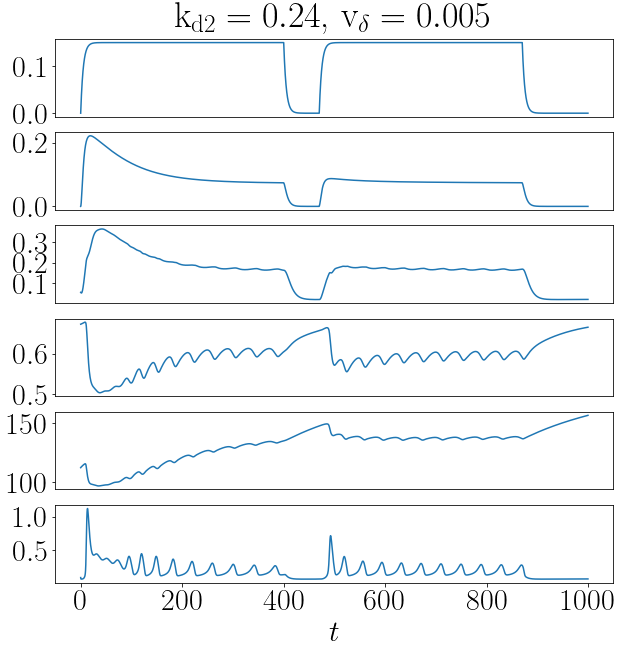

In [250]:
fig, ax = plt.subplots(6, figsize=(10,10), sharey='row')
set_init('default')
cfg.all_init[1] = cfg.all_init[1] * 0.6
cfg.input_max = 0.1
cfg.input_duration = 400
cfg.A = 0.15
cfg.d_rise = 400
cfg.r_rise = 0.2

slider = np.linspace(0, 3, 4)
cmap = matplotlib.cm.get_cmap('coolwarm')
# sol = run_experiment('curve', t_f=80, max_step=0.5, fix_c_er=160)
# plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)
cfg.num_oscillations = 2
kd1 = 0.02
kd2 = 0.6

cfg.kd2 = kd2 * 4
cfg.v_delta = 0.005
sol = run_experiment('exponential_oscillation', t_f=1000, max_step=0.5)
plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], ax[:], add_ylabels=False)

ax[0].set_title('k$_\mathrm{d2}=0.24$, v$_\delta=0.005$')
cfg.v_delta = 0.01
cfg.kd1 = 0.02
cfg.kd2 = 0.6

plt.savefig('figures/poster_plots/kd2_oscillation_vdelta_0.005.png', bbox_inches='tight')

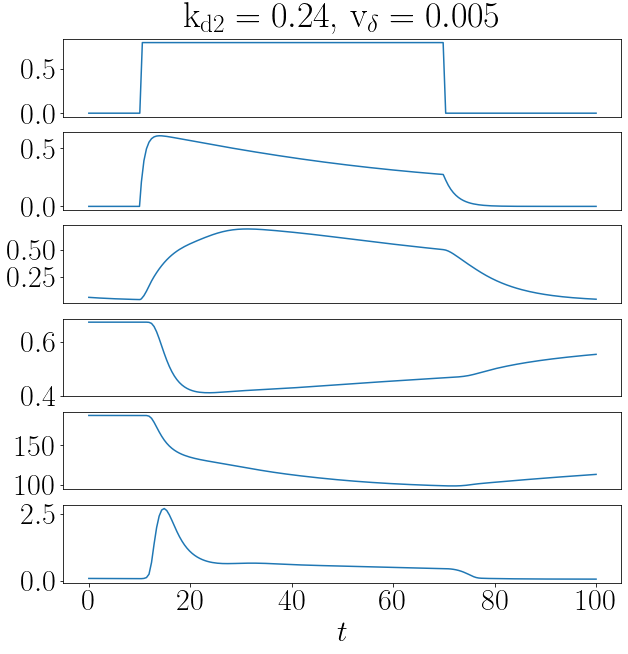

In [21]:
fig, ax = plt.subplots(6, figsize=(10,10), sharey='row')
set_init('default')
# cfg.all_init[1] = cfg.all_init[1] * 0.6
cfg.input_max = 0.8
cfg.input_duration = 60
# cfg.A = 0.8
cfg.d_rise = 60
cfg.r_rise = 0.2

slider = np.linspace(0, 3, 4)
cmap = matplotlib.cm.get_cmap('coolwarm')
# sol = run_experiment('curve', t_f=80, max_step=0.5, fix_c_er=160)
# plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)
cfg.num_oscillations = 2
kd1 = 0.02
kd2 = 0.6

cfg.kd2 = kd2 * 4
cfg.v_delta = 0.005
sol = run_experiment('pulse', t_f=100, max_step=0.5)
plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], ax[:], add_ylabels=False)

ax[0].set_title('k$_\mathrm{d2}=0.24$, v$_\delta=0.005$')
cfg.v_delta = 0.01
cfg.kd1 = 0.02
cfg.kd2 = 0.6

# plt.savefig('figures/poster_plots/kd2_oscillation_vdelta_0.005.png', bbox_inches='tight')

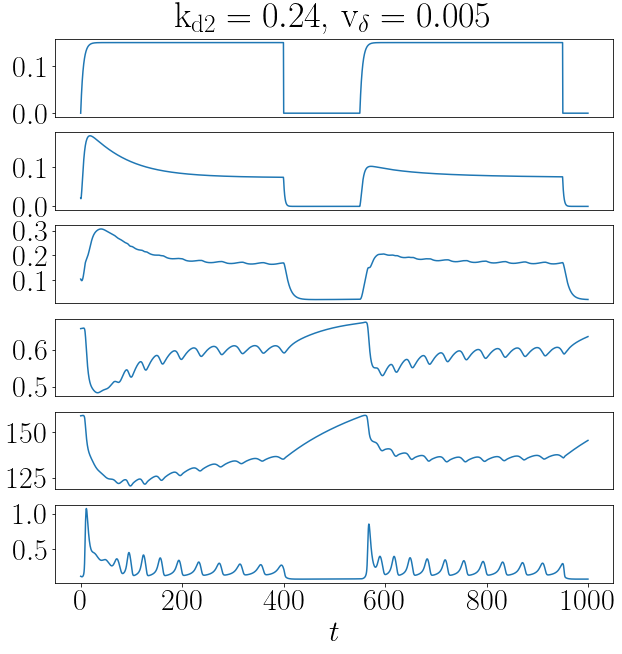

In [7]:
fig, ax = plt.subplots(6, figsize=(10,10), sharey='row')
set_init('poisson')
# cfg.all_init[1] = cfg.all_init[1] * 0.4
cfg.input_max = 0.1
cfg.input_duration = 400
cfg.A = 0.15
cfg.d_rise = 400
cfg.r_rise = 0.2

slider = np.linspace(0, 3, 4)
cmap = matplotlib.cm.get_cmap('coolwarm')
# sol = run_experiment('curve', t_f=80, max_step=0.5, fix_c_er=160)
# plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)
cfg.num_oscillations = 2
kd1 = 0.02
kd2 = 0.6

cfg.kd2 = kd2 * 4
cfg.v_delta = 0.005
sol = run_experiment('exponential_oscillation', t_f=1000, max_step=0.5)
plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], ax[:], add_ylabels=False)

ax[0].set_title('k$_\mathrm{d2}=0.24$, v$_\delta=0.005$')
cfg.v_delta = 0.01
cfg.kd1 = 0.02
cfg.kd2 = 0.6

# plt.savefig('figures/poster_plots/kd2_oscillation_vdelta_0.005.png', bbox_inches='tight')

### Summary Plots

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.23s/it]


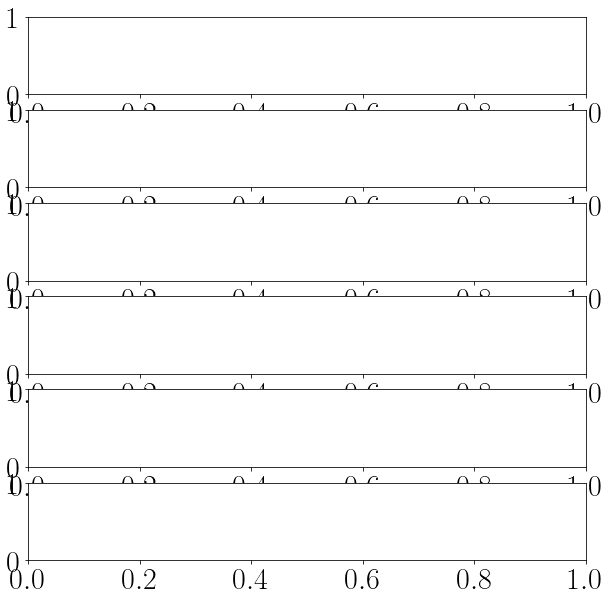

In [64]:
cfg.input_max = 0.4
cfg.input_duration = 60
# fig, ax = plt.subplots(6, 1, figsize=(10,10))

conditions = {} #list of conditions: kd1, kd2, v_delta
values = {} #list of values to collect
    #each will be [max c, slope at t20, value at t70]

cond_types = ['kd1', 'kd2', 'v_delta']
default_vals = [0.02, 0.6, 0.01]
slider1 = np.linspace(0, 4, 30)
slider2 = np.linspace(0, 1, 30)
for i, typ in enumerate(cond_types):
    conditions[typ] = []
    values[typ] = []
    for j in range(len(slider1)):
        slider = slider1 if i != 2 else slider2
        vals = default_vals.copy()
        vals[i] = vals[i] * slider[j]
        conditions[typ].append(vals)
    
    
def slope_at_index(idx, var='c'):
    y = getattr(cfg, var)
    t2 = cfg.t[idx + 1]
    t1 = cfg.t[idx - 1]
    y2 = y[idx + 1]
    y1 = y[idx - 1]
    return (y2 - y1) / (t2 - t1)


for typ in tqdm(cond_types):
    for cond in conditions[typ]:
        cfg.kd1 = cond[0]
        cfg.kd2 = cond[1]
        cfg.v_delta = cond[2]
        run_experiment(t_f=71, max_step=0.25)
#         plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], ax)

        ts = [20, 50, 70]
        max_c = np.max(cfg.c)
        idx = np.array([np.argmax(cfg.t > t) for t in ts])
        slope1 = slope_at_index(idx[0])
        slope2 = slope_at_index(idx[1])
        decayed_c = cfg.c[idx[2]]

        values[typ].append([max_c, slope1, slope2, decayed_c])
    
cfg.kd1 = 0.02
cfg.kd2 = 0.6
cfg.v_delta = 0.01

pickle.dump(values, open('data/plot_data/plateau_falloff_summary', 'wb'))


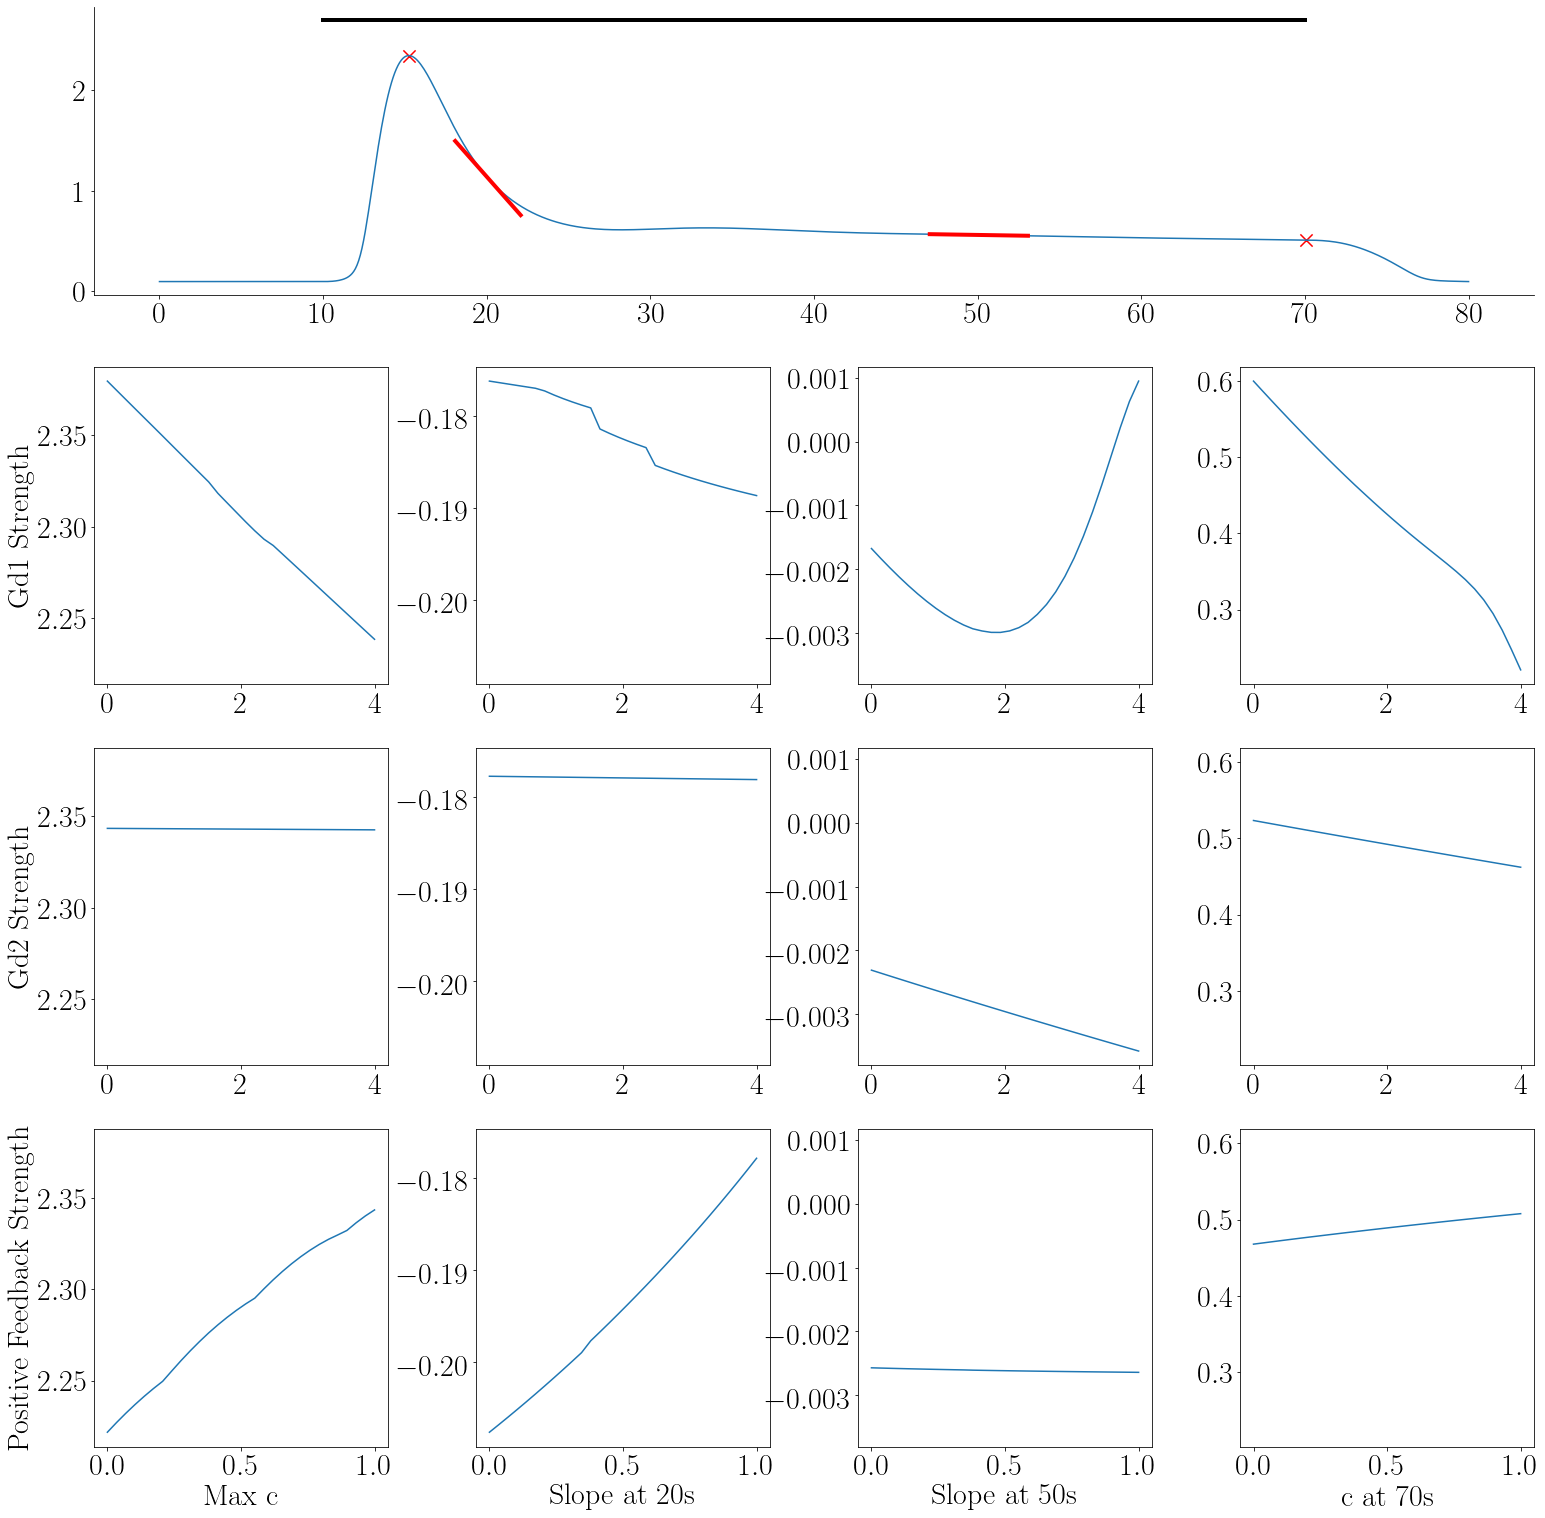

In [70]:
cmap = matplotlib.cm.get_cmap('coolwarm')
# fig, ax = plt.subplots(3, 4, figsize=(20,13), sharey='col')
cfg.input_duration = 60
cfg.kd1 = 0.02
cfg.kd2 = 0.6
cfg.v_delta = 0.01
run_experiment(t_f=80)

fig = plt.figure(constrained_layout=False, figsize=(20, 20))
gs = fig.add_gridspec(1, 1, left=0, right=1, top=1, bottom=0.8)
gs2 = fig.add_gridspec(3, 4, left=0, right=1, top=0.75, bottom=0, wspace=0.3)
ax = fig.add_subplot(gs[0])
axs = []

#summary plots
for i in range(3):
    ax_row = []
    for j in range(4):
        if i > 0:
            sharey = axs[0][j]
        else:
            sharey = None
        ax_row.append(fig.add_subplot(gs2[i, j], sharey=sharey))
    axs.append(ax_row)

for i, typ in enumerate(cond_types):
    data = np.array(values[typ]).T
    slider = slider1 if i != 2 else slider2
    for j in range(4):
        axs[i][j].plot(slider, data[j])

axs[0][0].set_ylabel('Gd1 Strength')   
axs[1][0].set_ylabel('Gd2 Strength')   
axs[2][0].set_ylabel('Positive Feedback Strength')   
axs[2][0].set_xlabel('Max c')
axs[2][1].set_xlabel('Slope at 20s')
axs[2][2].set_xlabel('Slope at 50s')
axs[2][3].set_xlabel('c at 70s')
    
    
#example plots
ax.plot(cfg.t, cfg.c)
ts = [20, 50, 70]
max_t = cfg.t[np.argmax(cfg.c)]
max_c = np.max(cfg.c)
idx = np.array([np.argmax(cfg.t > t) for t in ts])
slope1 = slope_at_index(idx[0])
slope2 = slope_at_index(idx[1])
decayed_c = cfg.c[idx[2]]

ax.scatter([max_t, cfg.t[idx[2]]], [max_c, decayed_c], c='red', marker='x', s=150)
h1 = 2
h2 = 3
t1 = cfg.t[idx[0]]
t2 = cfg.t[idx[1]]
c1 = cfg.c[idx[0]]
c2 = cfg.c[idx[1]]
ax.plot([t1-h1, t1+h1], [c1-slope1*h1, c1+slope1*h1], c='red', linewidth=4)
ax.plot([t2-h2, t2+h2], [c2-slope2*h2, c2+slope2*h2], c='red', linewidth=4)
ax.plot([10, 70], [2.7, 2.7], c='k', linewidth=4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#         ax[j].set_xticks([0, 4])
# fig.tight_layout()

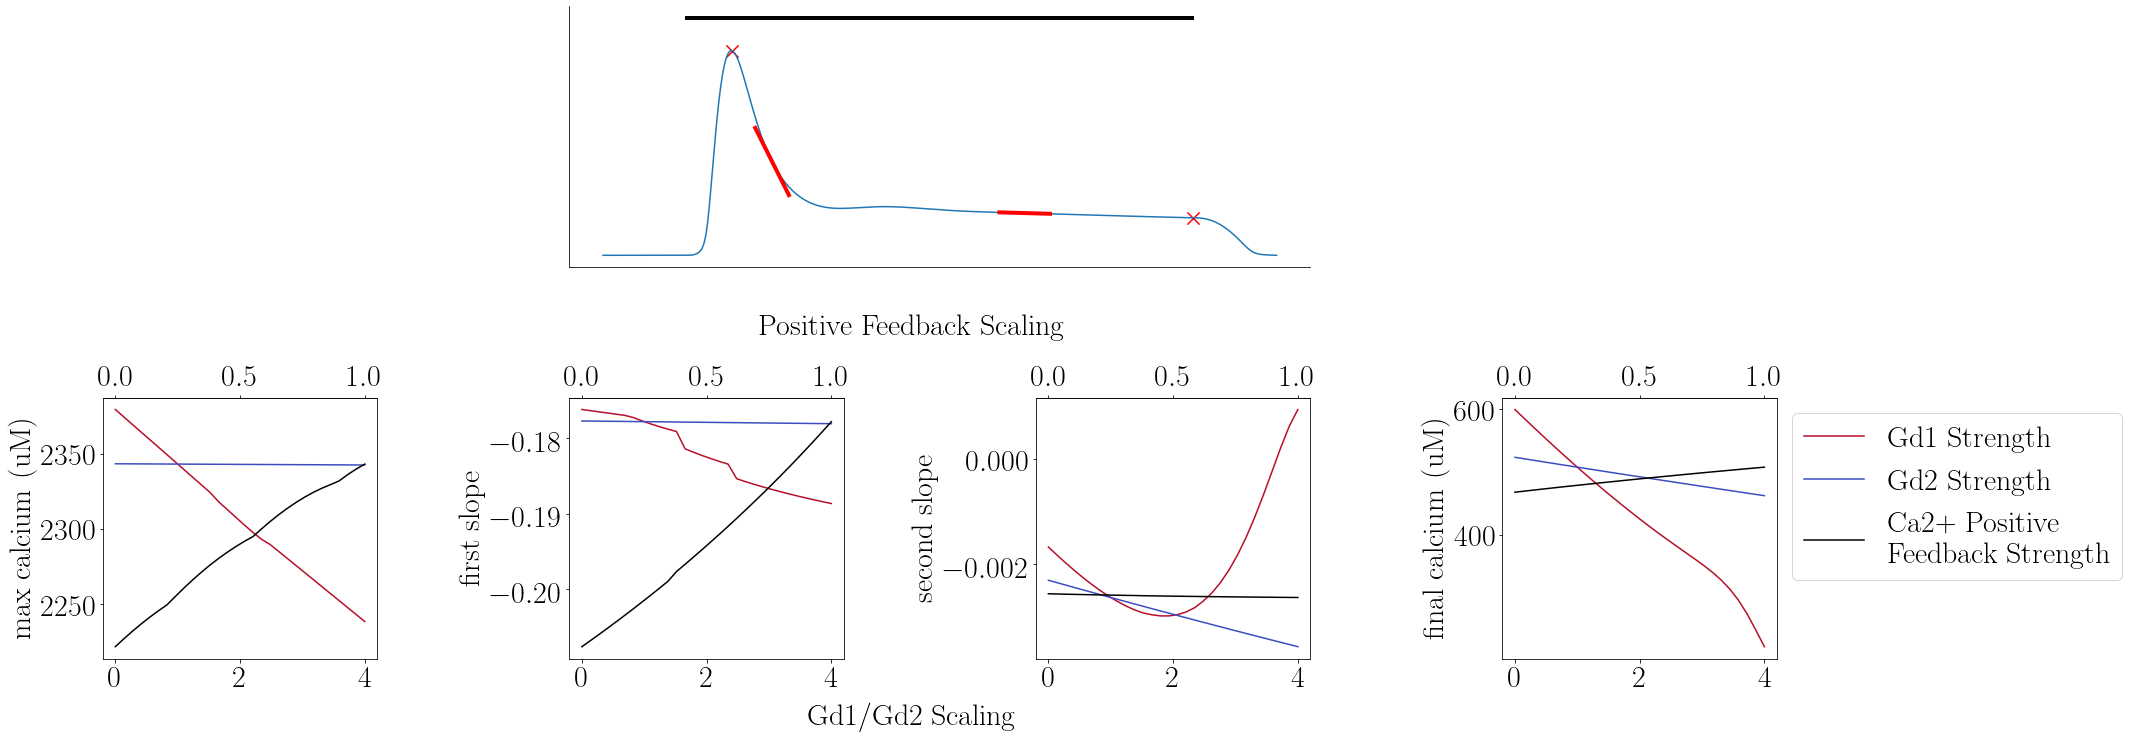

In [141]:
values = pickle.load(open('data/plot_data/plateau_falloff_summary', 'rb'))
cond_types = ['kd1', 'kd2', 'v_delta']
set_init()
def slope_at_index(idx, var='c'):
    y = getattr(cfg, var)
    t2 = cfg.t[idx + 1]
    t1 = cfg.t[idx - 1]
    y2 = y[idx + 1]
    y1 = y[idx - 1]
    return (y2 - y1) / (t2 - t1)

cmap = matplotlib.cm.get_cmap('coolwarm')
# fig, ax = plt.subplots(3, 4, figsize=(20,13), sharey='col')
cfg.input_max = 0.4
cfg.input_duration = 60
cfg.kd1 = 0.02
cfg.kd2 = 0.6
cfg.v_delta = 0.01
run_experiment(t_f=80)
slider = np.linspace(0, 4, 30)

fig = plt.figure(constrained_layout=False, figsize=(30, 12))
# gs = fig.add_gridspec(1, 1, left=0, right=1, top=1, bottom=0.8)
# gs2 = fig.add_gridspec(1, 4, left=0, right=1, top=0.75, bottom=0, wspace=0.3)
gs = fig.add_gridspec(2, 4, hspace=0.5, wspace=0.7)
ax = fig.add_subplot(gs[0, 1:-1])
axs = []
labels = ['Gd1 Strength', 'Gd2 Strength', 'Ca2+ Positive \n Feedback Strength']
colors = [cmap(0.99), cmap(0), 'k']
ylabels = ['max calcium (uM)', 'first slope', 'second slope', 'final calcium (uM)']
#summary plots
for j in range(4):
    axs.append(fig.add_subplot(gs[1:, j]))

for i, typ in enumerate(cond_types):
    data = np.array(values[typ]).T
    for j in range(4):
        if(j == 0 or j == 3):
            data[j] = data[j] * 1000
        axs[j].plot(slider, data[j], label=labels[i], c=colors[i])
        
def bot_to_top(x):
    return x/4
def top_to_bot(x):
    return x*4
for j in range(4):
    axs[j].set_xticks([0, 2, 4])
    axs[j].secondary_xaxis('top', functions=(bot_to_top, top_to_bot))
    axs[j].set_ylabel(ylabels[j])
axs[-1].legend(bbox_to_anchor=(1,1,0,0))
axs[2].set_xlabel
    
    
#example plots
ax.plot(cfg.t, cfg.c)
ts = [20, 50, 70]
max_t = cfg.t[np.argmax(cfg.c)]
max_c = np.max(cfg.c)
idx = np.array([np.argmax(cfg.t > t) for t in ts])
slope1 = slope_at_index(idx[0])
slope2 = slope_at_index(idx[1])
decayed_c = cfg.c[idx[2]]

ax.scatter([max_t, cfg.t[idx[2]]], [max_c, decayed_c], c='red', marker='x', s=150)
h1 = 2
h2 = 3
t1 = cfg.t[idx[0]]
t2 = cfg.t[idx[1]]
c1 = cfg.c[idx[0]]
c2 = cfg.c[idx[1]]
ax.plot([t1-h1, t1+h1], [c1-slope1*h1, c1+slope1*h1], c='red', linewidth=4)
ax.plot([t2-h2, t2+h2], [c2-slope2*h2, c2+slope2*h2], c='red', linewidth=4)
ax.plot([10, 70], [2.7, 2.7], c='k', linewidth=4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

#text
plt.text(0.5, 0.05, 'Gd1/Gd2 Scaling', fontsize=30, transform=plt.gcf().transFigure, ha='center')
plt.text(0.5, 0.5, 'Positive Feedback Scaling', fontsize=30, transform=plt.gcf().transFigure, ha='center')

plt.savefig('figures/poster_plots/plateau_falloff_summary', bbox_inches='tight')

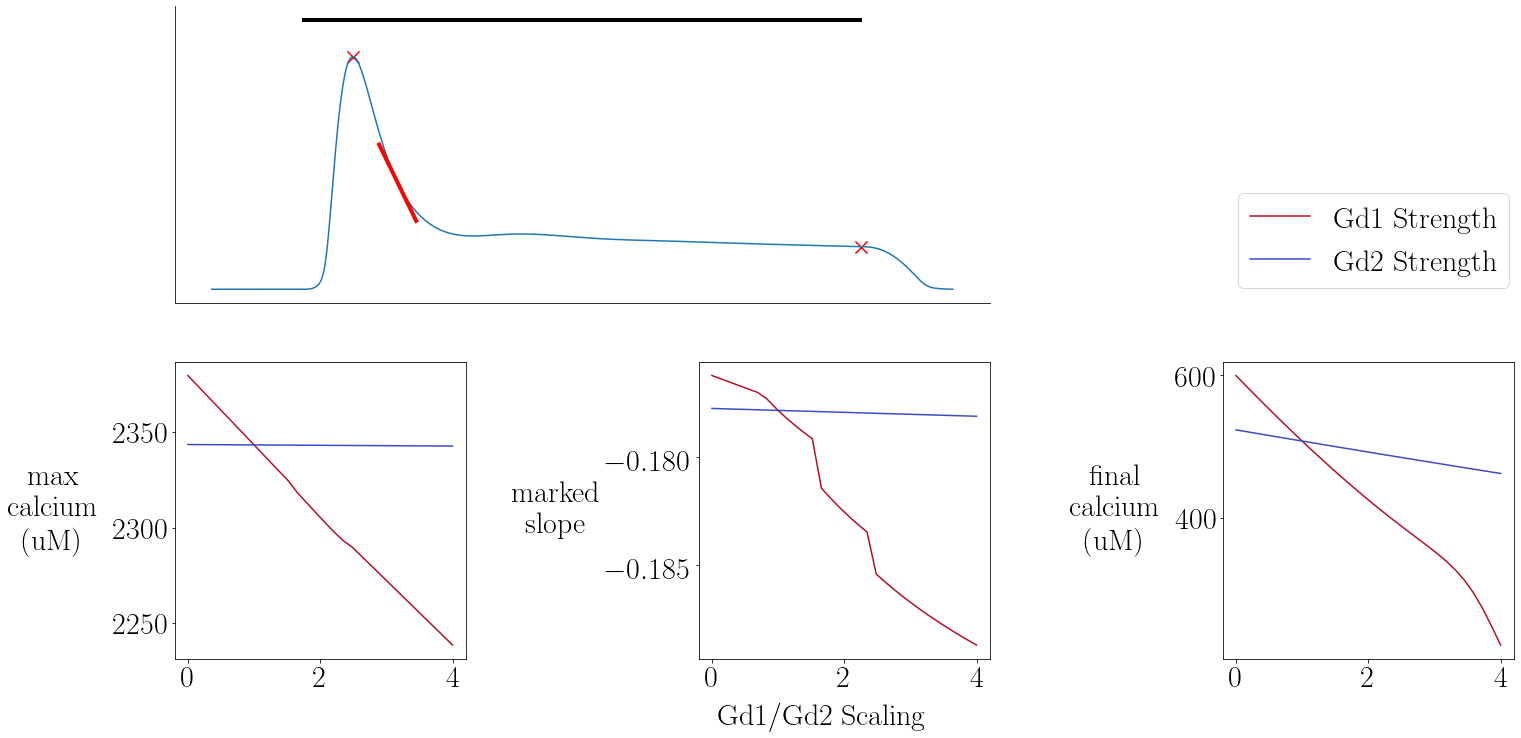

In [146]:
values = pickle.load(open('data/plot_data/plateau_falloff_summary', 'rb'))
cond_types = ['kd1', 'kd2']
set_init()
def slope_at_index(idx, var='c'):
    y = getattr(cfg, var)
    t2 = cfg.t[idx + 1]
    t1 = cfg.t[idx - 1]
    y2 = y[idx + 1]
    y1 = y[idx - 1]
    return (y2 - y1) / (t2 - t1)

cmap = matplotlib.cm.get_cmap('coolwarm')
# fig, ax = plt.subplots(3, 4, figsize=(20,13), sharey='col')
cfg.input_max = 0.4
cfg.input_duration = 60
cfg.kd1 = 0.02
cfg.kd2 = 0.6
cfg.v_delta = 0.01
run_experiment(t_f=80)
slider = np.linspace(0, 4, 30)

fig = plt.figure(constrained_layout=False, figsize=(24, 12))
# gs = fig.add_gridspec(1, 1, left=0, right=1, top=1, bottom=0.8)
# gs2 = fig.add_gridspec(1, 4, left=0, right=1, top=0.75, bottom=0, wspace=0.3)
gs = fig.add_gridspec(2, 3, hspace=0.2, wspace=0.8)
ax = fig.add_subplot(gs[0, :-1])
axs = []
labels = ['Gd1 Strength', 'Gd2 Strength', 'Ca2+ Positive \n Feedback Strength']
colors = [cmap(0.99), cmap(0), 'k']
ylabelpads = [60, 50, 60]
ylabels = ['max \n calcium \n (uM)', 'marked \n slope', 'second slope',  'final \n calcium \n (uM)']
#summary plots
for j in range(3):
    axs.append(fig.add_subplot(gs[1:, j]))

for i, typ in enumerate(cond_types):
    data = np.array(values[typ]).T
    for j in range(4):
        if j == 2:
            continue
        if(j == 0 or j == 3):
            data[j] = data[j] * 1000

        if j != 3:
            ax_num = j
        else:
            ax_num = j-1
        
        label = labels[i] if j == 0 else None
        axs[ax_num].plot(slider, data[j], label=labels[i], c=colors[i])
        
def bot_to_top(x):
    return x/4
def top_to_bot(x):
    return x*4
for j in range(4):
#     axs[j].set_xticks([0, 2, 4])
#     axs[j].secondary_xaxis('top', functions=(bot_to_top, top_to_bot))
    if j == 2:
        continue
    elif j == 3:
        ax_num = 2
    else:
        ax_num = j 
    axs[ax_num].set_ylabel(ylabels[j], rotation=0, verticalalignment='center', 
                           labelpad=ylabelpads[ax_num])
axs[-1].legend(bbox_to_anchor=(0,1.2,0,0), loc='lower left')
axs[2].set_xlabel
    
    
#example plots
ax.plot(cfg.t, cfg.c)
ts = [20, 50, 70]
max_t = cfg.t[np.argmax(cfg.c)]
max_c = np.max(cfg.c)
idx = np.array([np.argmax(cfg.t > t) for t in ts])
slope1 = slope_at_index(idx[0])
slope2 = slope_at_index(idx[1])
decayed_c = cfg.c[idx[2]]

ax.scatter([max_t, cfg.t[idx[2]]], [max_c, decayed_c], c='red', marker='x', s=150)
h1 = 2
h2 = 3
t1 = cfg.t[idx[0]]
t2 = cfg.t[idx[1]]
c1 = cfg.c[idx[0]]
c2 = cfg.c[idx[1]]
ax.plot([t1-h1, t1+h1], [c1-slope1*h1, c1+slope1*h1], c='red', linewidth=4)
# ax.plot([t2-h2, t2+h2], [c2-slope2*h2, c2+slope2*h2], c='red', linewidth=4)
ax.plot([10, 70], [2.7, 2.7], c='k', linewidth=4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

#text
plt.text(0.5, 0.05, 'Gd1/Gd2 Scaling', fontsize=30, transform=plt.gcf().transFigure, ha='center')
# plt.text(0.5, 0.5, 'Positive Feedback Scaling', fontsize=30, transform=plt.gcf().transFigure, ha='center')

plt.savefig('figures/poster_plots/plateau_falloff_summary2', bbox_inches='tight')

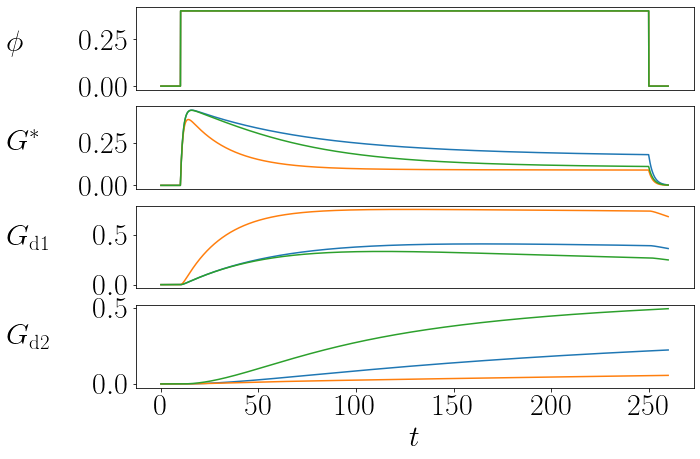

In [29]:
fig, ax = plt.subplots(4, 1, figsize=(10, 7))
cfg.input_duration = 240
run_experiment(t_f=260)
plot_experiment_plots(['glut', 'Gstar','Gd1', 'Gd2'], ax)
cfg.kd1 = 0.08
run_experiment(t_f=260)
plot_experiment_plots(['glut', 'Gstar','Gd1', 'Gd2'], ax)
cfg.kd1 = 0.02
cfg.kd2 = 2.4
run_experiment(t_f=260)
plot_experiment_plots(['glut', 'Gstar','Gd1', 'Gd2'], ax)
cfg.kd2 = 0.6

In [161]:
set_init('poisson')
cfg.input_max = 0.1
cfg.oscillation_on_duration = 400
cfg.oscillation_off_duration = 60
# fig, ax = plt.subplots(1, 3, figsize=(12, 4))
# run_experiment('oscillation', t_f=1000, max_step=0.1)
# ax[0].plot(cfg.t, cfg.c)

slider1 = np.linspace(0, 4, 10)
slider2 = np.linspace(0, 1, 10)
conditions = {}
values = {}

cond_types = ['kd1', 'kd2', 'v_delta', 'kd2_half_vd', 'kd1_half_vd']
default_vals = [0.02, 0.6, 0.01]
for i, typ in enumerate(cond_types):
    conditions[typ] = []
    values[typ] = {}
    slider = slider1 if i != 2 else slider2

    for j in range(len(slider1)):
        values[typ][j] = {}

for i, typ in enumerate(cond_types):
    slider = slider1 if i != 2 else slider2

    for j in range(len(slider1)):
        vals = default_vals.copy()
        if i < 3:
            vals[i] = vals[i] * slider[j]
        elif i == 3:
            vals[1] = vals[1] * slider[j]
            vals[2] = 0.005
        elif i == 4:
            vals[0] = vals[0] * slider[j]
            vals[2] = 0.005
            
        cfg.kd1 = vals[0]
        cfg.kd2 = vals[1]
        cfg.v_delta = vals[2]
        
        run_experiment('oscillation', t_f=1000, max_step=0.1)
        first_t = 450
        idx = np.argmax(cfg.t > first_t)
        peaks = scipy.signal.find_peaks(cfg.c[idx:])[0] + idx
        isi = np.diff(cfg.t[peaks])
        
        values[typ][j]['isi'] = isi
        values[typ][j]['t_peaks'] = cfg.t[peaks]
        values[typ][j]['c_peaks'] = cfg.c[peaks]
        
# first_t = 450
# idx = np.argmax(cfg.t > first_t)
# peaks = scipy.signal.find_peaks(cfg.c[idx:])[0] + idx
# isi = np.diff(cfg.t[peaks])
# ax[1].scatter(cfg.t[peaks[1:]], 1/isi)
# ax[2].scatter(cfg.t[peaks], cfg.c[peaks])
pickle.dump(values, open('data/plot_data/oscillation_falloff_summary', 'wb'))

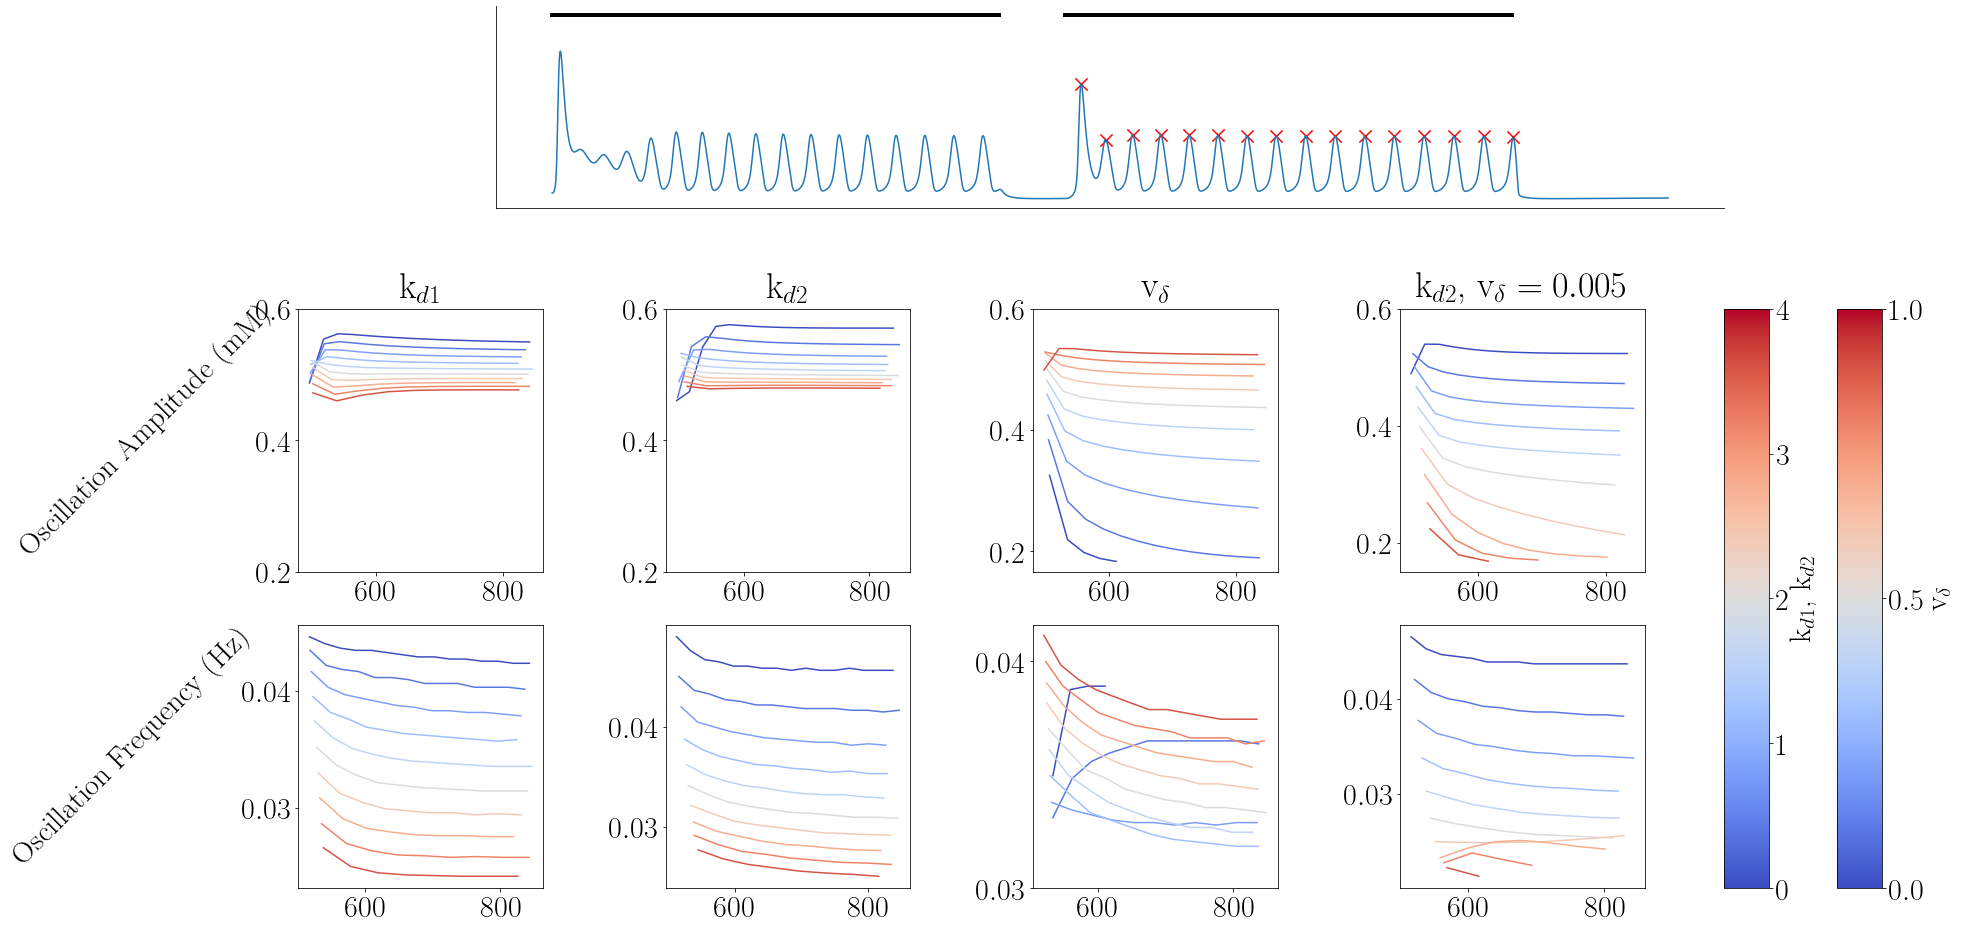

In [156]:
values = pickle.load(open('data/plot_data/oscillation_falloff_summary', 'rb'))
cond_types = ['kd1', 'kd2', 'v_delta', 'kd2_half_vd']
slider = np.linspace(0, 4, 10)
cmap = matplotlib.cm.get_cmap('coolwarm')

#Generate gridspecs and subplots
fig = plt.figure(constrained_layout=False, figsize=(22, 14))
gs = fig.add_gridspec(2, 4, left=0, right=0.85, top=0.7, wspace=0.5)
gs2 = fig.add_gridspec(1, 2, left=0.9, right=1, wspace=1.5, top=0.7)
gs3 = fig.add_gridspec(1, 1, top=1, bottom=0.8)
ax = []
for i in range(2):
    ax_row = []
    for j in range(4):
        ax_row.append(fig.add_subplot(gs[i, j]))
    ax.append(ax_row)

#Plot main plots
for i, typ in enumerate(cond_types):
    for j in range(len(slider)):
        color = cmap((j)/len(slider))
        t_peaks = values[typ][j]['t_peaks'][1:-1]
        c_peaks = values[typ][j]['c_peaks'][1:-1]
        isi = values[typ][j]['isi'][1:-1]
        ax[0][i].plot(t_peaks, c_peaks, c=color)
        ax[1][i].plot(t_peaks[1:], 1/isi, c=color)

ax[0][0].set_ylabel('Oscillation Amplitude (mM)', rotation=45, labelpad=100)
ax[1][0].set_ylabel('Oscillation Frequency (Hz)', rotation=45, labelpad=100)
ax[0][0].set_title('k$_{d1}$')
ax[0][1].set_title('k$_{d2}$')
ax[0][2].set_title('v$_\delta$')
ax[0][3].set_title('k$_{d2}$, v$_\delta=0.005$')

for j in range(4):
    ax[0][j].set_yticks([0.2, 0.4, 0.6])
    ax[1][j].set_yticks([0.03, 0.04])

#Colorbars
ax2 = fig.add_subplot(gs2[0])
norm = matplotlib.colors.Normalize(vmin=0, vmax=4)
cb1 = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='vertical')
cb1.set_label('k$_{d1}$, k$_{d2}$')
cb1.set_ticks([0, 1, 2, 3, 4])
cb1.ax.xaxis.set_label_position('top')

ax3 = fig.add_subplot(gs2[1])
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
cb2 = matplotlib.colorbar.ColorbarBase(ax3, cmap=cmap, norm=norm, orientation='vertical')
cb2.set_label('v$_\delta$')
cb2.set_ticks([0, 0.5, 1])

#Example calcium trace
set_init('poisson')
cfg.input_max = 0.1
cfg.oscillation_on_duration = 400
cfg.oscillation_off_duration = 60
cfg.kd1 = 0.02
cfg.kd2 = 0.6
cfg.v_delta = 0.01
run_experiment('oscillation', t_f=1000, max_step=0.1)
first_t = 450
idx = np.argmax(cfg.t > first_t)
peaks = scipy.signal.find_peaks(cfg.c[idx:])[0] + idx
ax4 = fig.add_subplot(gs3[0])
ax4.plot(cfg.t, cfg.c)
ax4.plot([0, 400], [1.4, 1.4], 'k', linewidth=4)
ax4.plot([460, 860], [1.4, 1.4], 'k', linewidth=4)
ax4.scatter(cfg.t[peaks], cfg.c[peaks], marker='x', color='red', s=150)
ax4.set_xticks([])
ax4.set_yticks([])
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

plt.savefig('figures/poster_plots/oscillation_summary', bbox_inches='tight')


In [116]:
slider[6]

2.6666666666666665

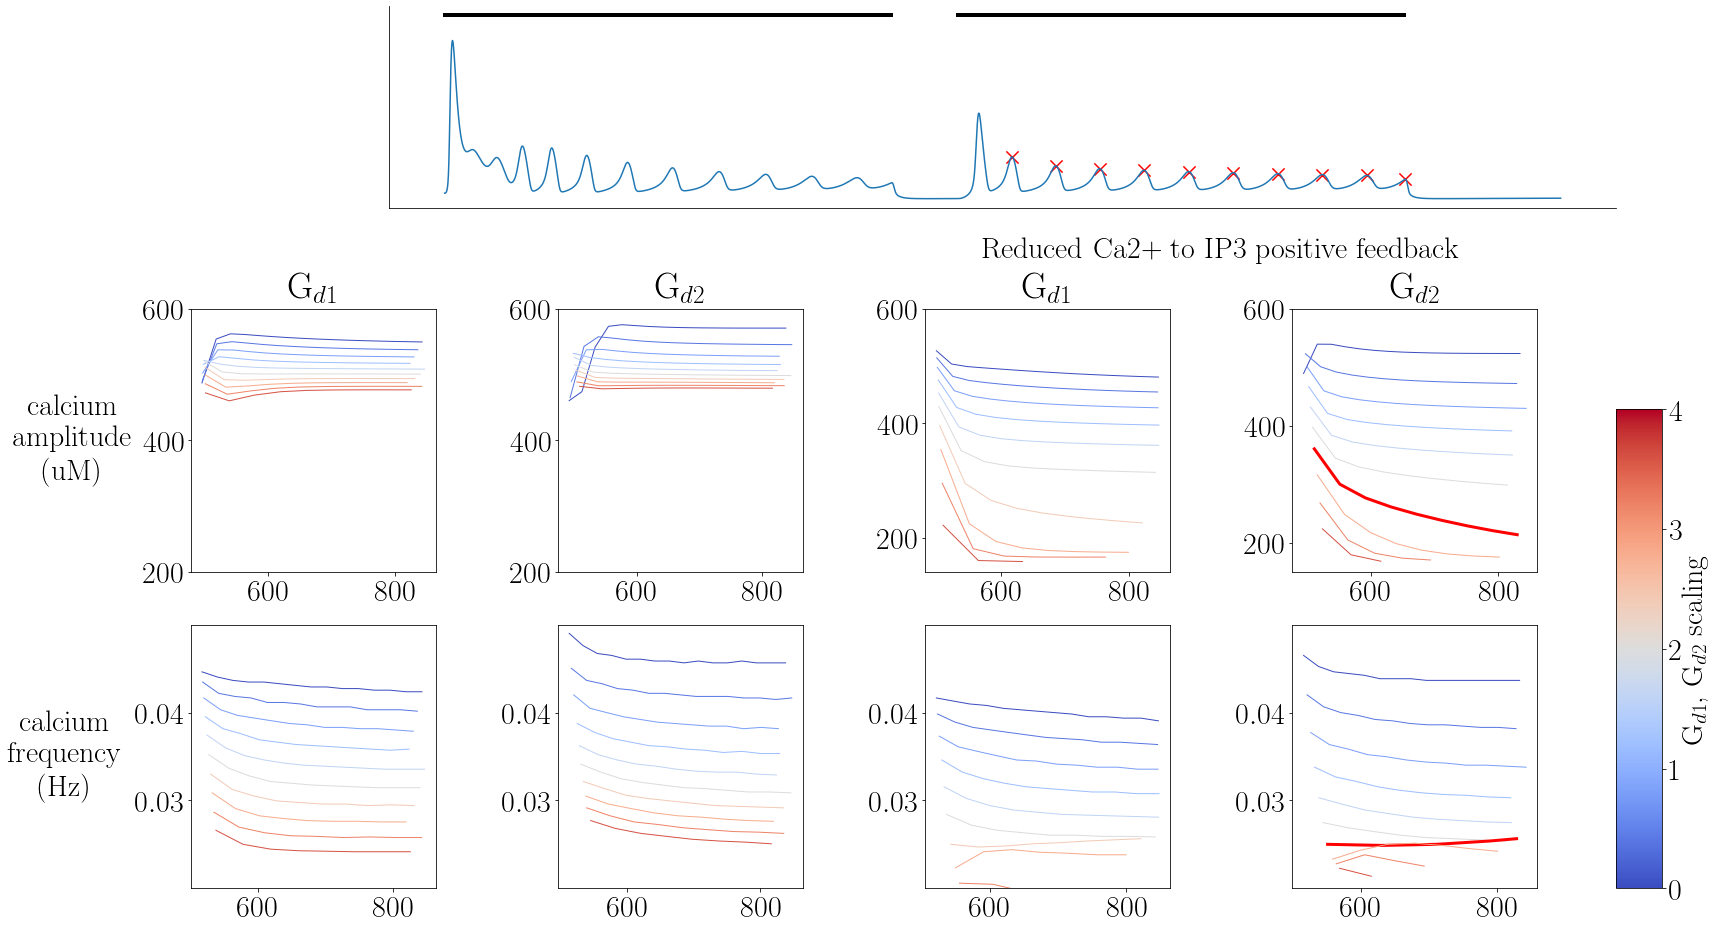

In [118]:
values = pickle.load(open('data/plot_data/oscillation_falloff_summary', 'rb'))
cond_types = ['kd1', 'kd2', 'kd1_half_vd', 'kd2_half_vd']
slider = np.linspace(0, 4, 10)
cmap = matplotlib.cm.get_cmap('coolwarm')

#Generate gridspecs and subplots
fig = plt.figure(constrained_layout=False, figsize=(22, 14))
gs = fig.add_gridspec(2, 4, left=0, right=0.85, top=0.7, wspace=0.5)
gs2 = fig.add_gridspec(1, 2, left=0.9, right=1, wspace=1.5, top=0.6)
gs3 = fig.add_gridspec(1, 1, top=1, bottom=0.8)
ax = []
for i in range(2):
    ax_row = []
    for j in range(4):
        ax_row.append(fig.add_subplot(gs[i, j]))
    ax.append(ax_row)

#Plot main plots
for i, typ in enumerate(cond_types):
    for j in range(len(slider)):
        color = cmap((j)/len(slider))
        linewidth = 1
        if typ == 'kd2_half_vd' and j == 6:
            color = 'red'
            linewidth = 3
        
        t_peaks = values[typ][j]['t_peaks'][1:-1]
        c_peaks = values[typ][j]['c_peaks'][1:-1]
        isi = values[typ][j]['isi'][1:-1]
        ax[0][i].plot(t_peaks, c_peaks*1000, c=color, linewidth=linewidth)
        ax[1][i].plot(t_peaks[1:], 1/isi, c=color, linewidth=linewidth)

plt.text(0.65, 0.75, 'Reduced Ca2+ to IP3 positive feedback', fontsize=30, ha='center',
        transform=plt.gcf().transFigure)
ax[0][0].set_ylabel('calcium \n amplitude \n (uM)', rotation=0, labelpad=70, verticalalignment='center')
ax[1][0].set_ylabel('calcium \n frequency \n (Hz)', rotation=0, labelpad=70, verticalalignment='center')
ax[0][0].set_title('G$_{d1}$')
ax[0][1].set_title('G$_{d2}$')
ax[0][2].set_title('G$_{d1}$')
ax[0][3].set_title('G$_{d2}$')

for j in range(4):
    ax[0][j].set_yticks([200, 400, 600])
    ax[1][j].set_yticks([0.03, 0.04])
    ax[1][j].set_ylim([0.02, 0.05])

#Colorbars
ax2 = fig.add_subplot(gs2[0])
norm = matplotlib.colors.Normalize(vmin=0, vmax=4)
cb1 = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='vertical')
cb1.set_label('G$_{d1}$, G$_{d2}$ scaling')
cb1.set_ticks([0, 1, 2, 3, 4])
cb1.ax.xaxis.set_label_position('top')

#Example calcium trace
set_init('poisson')
cfg.input_max = 0.15
cfg.oscillation_on_duration = 400
cfg.oscillation_off_duration = 60
cfg.num_oscillations = 2
cfg.kd1 = 0.02
cfg.kd2 = 2.6
cfg.v_delta = 0.005
run_experiment('oscillation', t_f=1000, max_step=0.1)
first_t = 450
idx = np.argmax(cfg.t > first_t)
peaks = scipy.signal.find_peaks(cfg.c[idx:])[0] + idx
ax4 = fig.add_subplot(gs3[0])
ax4.plot(cfg.t, cfg.c)
ax4.plot([0, 400], [1.4, 1.4], 'k', linewidth=4)
ax4.plot([460, 860], [1.4, 1.4], 'k', linewidth=4)
ax4.scatter(cfg.t[peaks[1:]], cfg.c[peaks[1:]], marker='x', color='red', s=150)
ax4.set_xticks([])
ax4.set_yticks([])
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

plt.savefig('figures/poster_plots/oscillation_summary3', bbox_inches='tight')


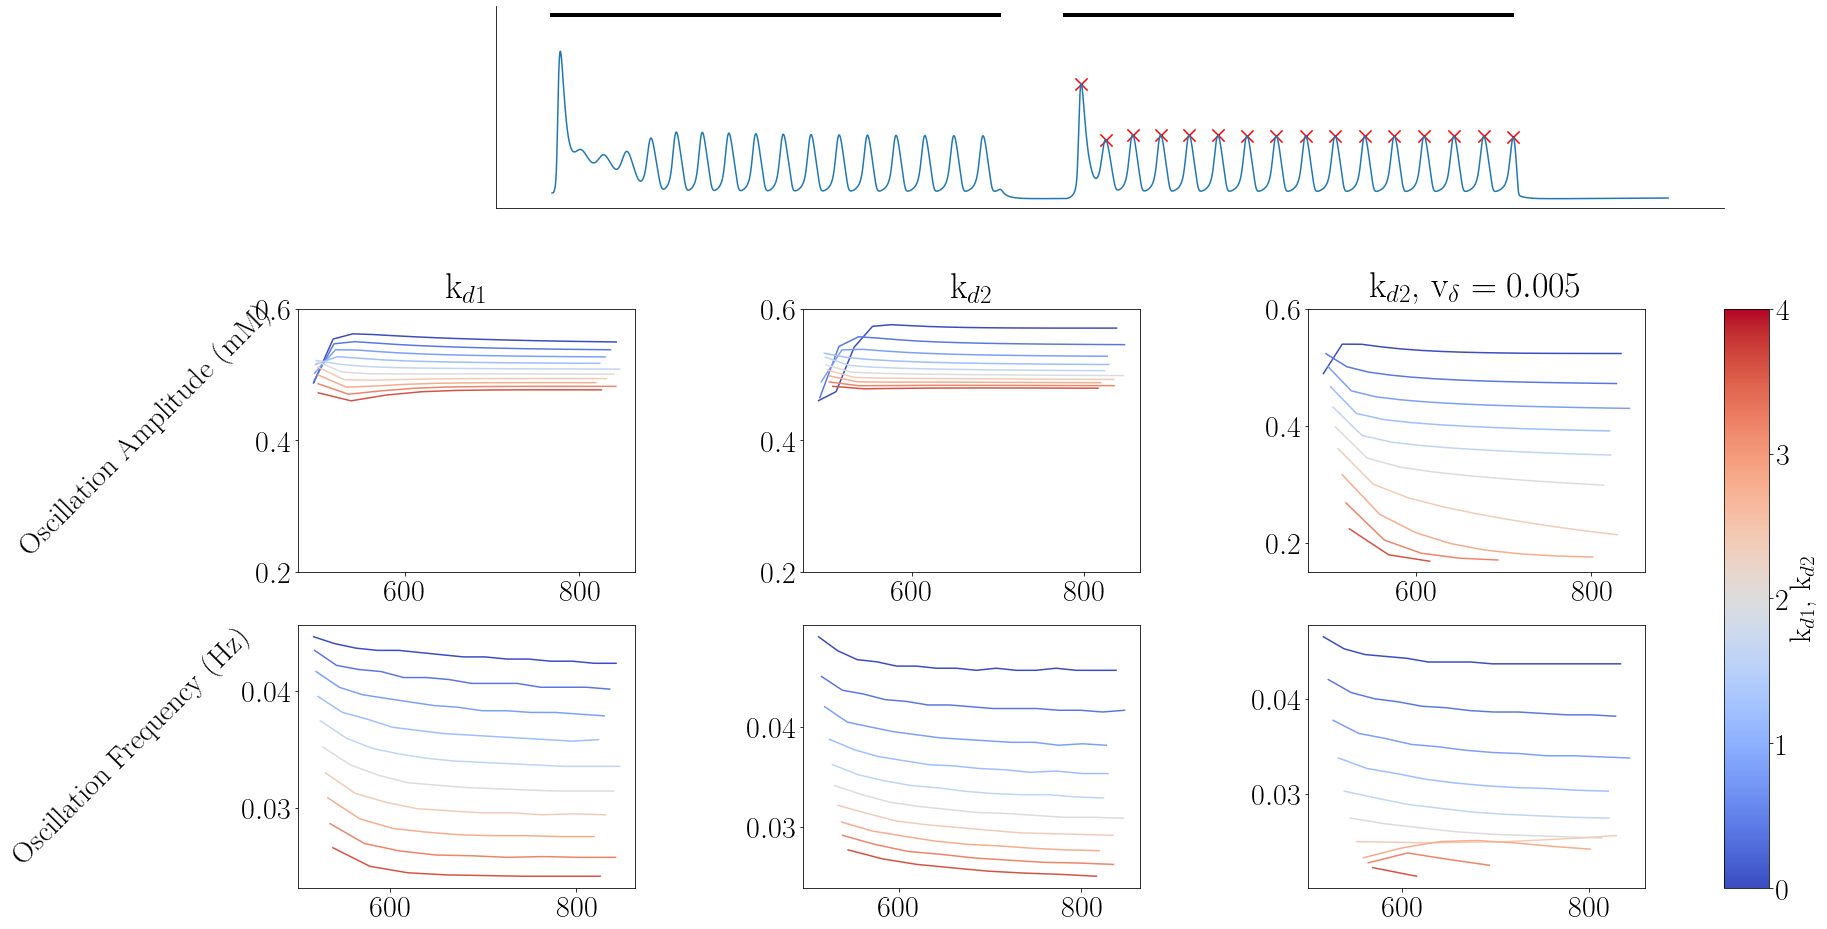

In [158]:
values = pickle.load(open('data/plot_data/oscillation_falloff_summary', 'rb'))
cond_types = ['kd1', 'kd2', 'kd2_half_vd']
slider = np.linspace(0, 4, 10)
cmap = matplotlib.cm.get_cmap('coolwarm')

#Generate gridspecs and subplots
fig = plt.figure(constrained_layout=False, figsize=(22, 14))
gs = fig.add_gridspec(2, 3, left=0, right=0.85, top=0.7, wspace=0.5)
gs2 = fig.add_gridspec(1, 2, left=0.9, right=1, wspace=1.5, top=0.7)
gs3 = fig.add_gridspec(1, 1, top=1, bottom=0.8)
ax = []
for i in range(2):
    ax_row = []
    for j in range(3):
        ax_row.append(fig.add_subplot(gs[i, j]))
    ax.append(ax_row)

#Plot main plots
for i, typ in enumerate(cond_types):
    for j in range(len(slider)):
        color = cmap((j)/len(slider))
        t_peaks = values[typ][j]['t_peaks'][1:-1]
        c_peaks = values[typ][j]['c_peaks'][1:-1]
        isi = values[typ][j]['isi'][1:-1]
        ax[0][i].plot(t_peaks, c_peaks, c=color)
        ax[1][i].plot(t_peaks[1:], 1/isi, c=color)

ax[0][0].set_ylabel('Oscillation Amplitude (mM)', rotation=45, labelpad=100)
ax[1][0].set_ylabel('Oscillation Frequency (Hz)', rotation=45, labelpad=100)
ax[0][0].set_title('k$_{d1}$')
ax[0][1].set_title('k$_{d2}$')
ax[0][2].set_title('k$_{d2}$, v$_\delta=0.005$')

for j in range(3):
    ax[0][j].set_yticks([0.2, 0.4, 0.6])
    ax[1][j].set_yticks([0.03, 0.04])

#Colorbars
ax2 = fig.add_subplot(gs2[0])
norm = matplotlib.colors.Normalize(vmin=0, vmax=4)
cb1 = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='vertical')
cb1.set_label('k$_{d1}$, k$_{d2}$')
cb1.set_ticks([0, 1, 2, 3, 4])
cb1.ax.xaxis.set_label_position('top')

#Example calcium trace
set_init('poisson')
cfg.input_max = 0.1
cfg.oscillation_on_duration = 400
cfg.oscillation_off_duration = 60
cfg.kd1 = 0.02
cfg.kd2 = 0.6
cfg.v_delta = 0.01
run_experiment('oscillation', t_f=1000, max_step=0.1)
first_t = 450
idx = np.argmax(cfg.t > first_t)
peaks = scipy.signal.find_peaks(cfg.c[idx:])[0] + idx
ax4 = fig.add_subplot(gs3[0])
ax4.plot(cfg.t, cfg.c)
ax4.plot([0, 400], [1.4, 1.4], 'k', linewidth=4)
ax4.plot([460, 860], [1.4, 1.4], 'k', linewidth=4)
ax4.scatter(cfg.t[peaks], cfg.c[peaks], marker='x', color='red', s=150)
ax4.set_xticks([])
ax4.set_yticks([])
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

plt.savefig('figures/poster_plots/oscillation_summary2', bbox_inches='tight')


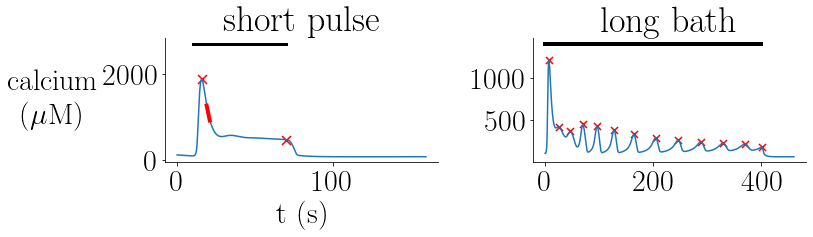

In [150]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

set_init('poisson')
cfg.input_start = 10
cfg.input_max = 0.4
cfg.input_duration = 60
cfg.kd1 = 0.02
cfg.kd2 = 0.6
cfg.v_delta = 0.01
run_experiment(t_f=160)
#example plots
ax[0].plot(cfg.t, cfg.c*1000)
ts = [20, 50, 70]
max_t = cfg.t[np.argmax(cfg.c)]
max_c = np.max(cfg.c*1000)
idx = np.array([np.argmax(cfg.t > t) for t in ts])
slope1 = slope_at_index(idx[0])
slope2 = slope_at_index(idx[1])
decayed_c = cfg.c[idx[2]]*1000
ax[0].scatter([max_t, cfg.t[idx[2]]], [max_c, decayed_c], c='red', marker='x', s=80)
h1 = 1
h2 = 3
t1 = cfg.t[idx[0]]
t2 = cfg.t[idx[1]]
c1 = cfg.c[idx[0]]
c2 = cfg.c[idx[1]]
ax[0].plot([t1-h1, t1+h1], [c1*1000-slope1*h1*1000, c1*1000+slope1*h1*1000], c='red', linewidth=4)
# ax[0].plot([t2-h2, t2+h2], [c2-slope2*h2, c2+slope2*h2], c='red', linewidth=4)
ax[0].plot([10, 70], [2700, 2700], c='k', linewidth=3)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
# ax[0].set_xticks([])
# ax[0].set_yticks([])

#Example calcium trace
set_init('poisson')
cfg.input_max = 0.15
cfg.oscillation_on_duration = 400
cfg.oscillation_off_duration = 60
cfg.num_oscillations = 2
cfg.kd1 = 0.02
cfg.kd2 = 2.6
cfg.v_delta = 0.005
run_experiment('oscillation', t_f=460, max_step=0.1)
first_t = 0
idx = np.argmax(cfg.t > first_t)
peaks = scipy.signal.find_peaks(cfg.c[idx:])[0] + idx
ax[1].plot(cfg.t, cfg.c * 1000)
ax[1].plot([0, 400], [1400, 1400], 'k', linewidth=4)
# ax[1].plot([460, 860], [1400, 1400], 'k', linewidth=4)
ax[1].scatter(cfg.t[peaks], cfg.c[peaks]*1000, marker='x', color='red', s=50)
# ax[1].set_xticks([])
# ax[1].set_yticks([])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

ax[0].set_ylabel('calcium \n ($\mu$M)', rotation=0, labelpad=50, va='center')
ax[0].set_xlabel('t (s)')

ax[0].set_title('short pulse')
ax[1].set_title('long bath')
plt.tight_layout()
plt.savefig('figures/poster_plots/calcium_falloff_examples', bbox_inches='tight')

In [46]:
values = pickle.load(open('data/plot_data/plateau_falloff_summary', 'rb'))


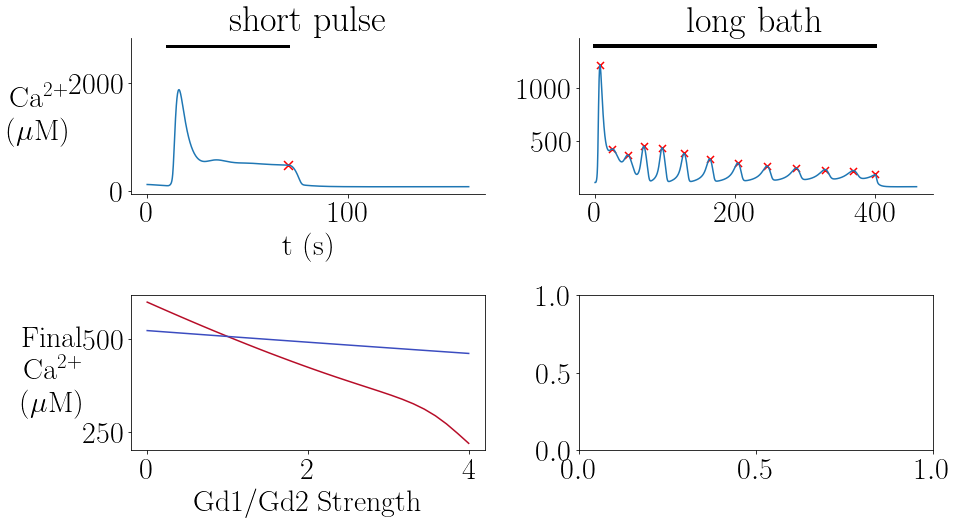

In [52]:
fig, ax = plt.subplots(2, 2, figsize=(14, 8))
cmap = matplotlib.cm.get_cmap('coolwarm')
set_init('poisson')
cfg.input_start = 10
cfg.input_max = 0.4
cfg.input_duration = 60
cfg.kd1 = 0.02
cfg.kd2 = 0.6
cfg.v_delta = 0.01
run_experiment(t_f=160)
#example plots
ax[0,0].plot(cfg.t, cfg.c*1000)
ts = [20, 50, 70]
max_t = cfg.t[np.argmax(cfg.c)]
max_c = np.max(cfg.c*1000)
idx = np.array([np.argmax(cfg.t > t) for t in ts])
slope1 = slope_at_index(idx[0])
slope2 = slope_at_index(idx[1])
decayed_c = cfg.c[idx[2]]*1000
ax[0,0].scatter([cfg.t[idx[2]]], [decayed_c], c='red', marker='x', s=80)
h1 = 1
h2 = 3
t1 = cfg.t[idx[0]]
t2 = cfg.t[idx[1]]
c1 = cfg.c[idx[0]]
c2 = cfg.c[idx[1]]
# ax[1].plot([t1-h1, t1+h1], [c1*1000-slope1*h1*1000, c1*1000+slope1*h1*1000], c='red', linewidth=4)
# ax[0].plot([t2-h2, t2+h2], [c2-slope2*h2, c2+slope2*h2], c='red', linewidth=4)
ax[0,0].plot([10, 70], [2700, 2700], c='k', linewidth=3)
ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
# ax[0].set_xticks([])
# ax[0].set_yticks([])

#Example calcium trace
set_init('poisson')
cfg.input_max = 0.15
cfg.oscillation_on_duration = 400
cfg.oscillation_off_duration = 60
cfg.num_oscillations = 2
cfg.kd1 = 0.02
cfg.kd2 = 2.6
cfg.v_delta = 0.005
run_experiment('oscillation', t_f=460, max_step=0.1)
first_t = 0
idx = np.argmax(cfg.t > first_t)
peaks = scipy.signal.find_peaks(cfg.c[idx:])[0] + idx
ax[0,1].plot(cfg.t, cfg.c * 1000)
ax[0,1].plot([0, 400], [1400, 1400], 'k', linewidth=4)
# ax[1].plot([460, 860], [1400, 1400], 'k', linewidth=4)
ax[0,1].scatter(cfg.t[peaks], cfg.c[peaks]*1000, marker='x', color='red', s=50)
# ax[1].set_xticks([])
# ax[1].set_yticks([])
ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)

ax[0,0].set_ylabel('Ca$^{2+}$ \n ($\mu$M)', rotation=0, labelpad=40, va='center')
ax[0,0].set_xlabel('t (s)')

ax[0,0].set_title('short pulse')
ax[0,1].set_title('long bath')

values = pickle.load(open('data/plot_data/plateau_falloff_summary', 'rb'))
cond_types = ['kd1', 'kd2']
labels = ['Gd1', 'Gd2']
colors = [cmap(0.99), cmap(0)]
slider = np.linspace(0, 4, 30)
for i, typ in enumerate(cond_types):
    data = np.array(values[typ]).T
    ax[1,0].plot(slider, data[3]*1000, label=labels[i], c=colors[i])
ax[1,0].set_xlabel('Gd1/Gd2 Strength')
ax[1,0].set_ylabel('Final \n Ca$^{2+}$ \n ($\mu$M)', rotation=0, ha='center', va='center', labelpad=40)

plt.tight_layout()
plt.savefig('figures/poster_plots/calcium_falloff_examples', bbox_inches='tight')

In [55]:
for i in range(2, 5):
    print(i)

2
3
4


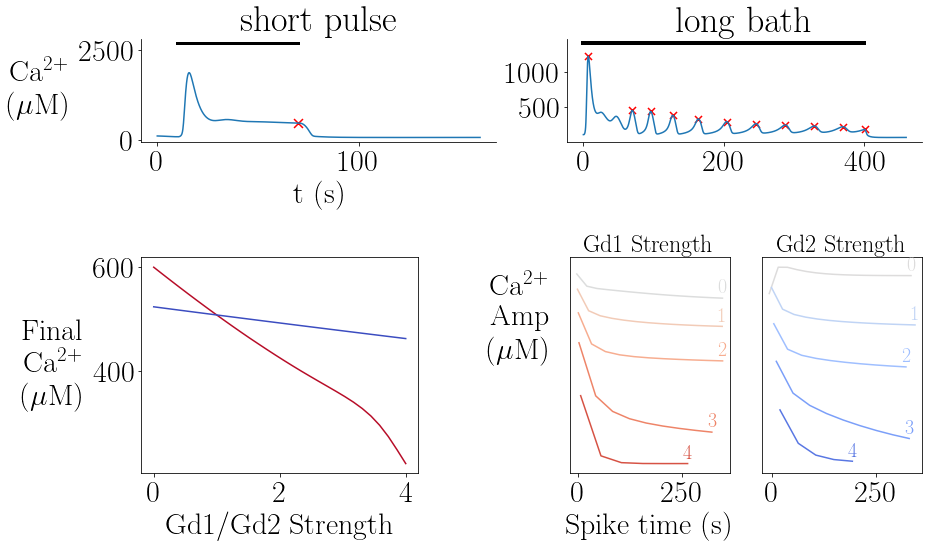

In [75]:
# fig, ax = plt.subplots(2, 2, figsize=(14, 8))
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(1, 2, bottom=0.7)
ax = [fig.add_subplot(gs[i]) for i in range(2)]

cmap = matplotlib.cm.get_cmap('coolwarm')
set_init('poisson')
cfg.input_start = 10
cfg.input_max = 0.4
cfg.input_duration = 60
cfg.kd1 = 0.02
cfg.kd2 = 0.6
cfg.v_delta = 0.01
run_experiment(t_f=160)
#example plots
ax[0].plot(cfg.t, cfg.c*1000)
ts = [20, 50, 70]
max_t = cfg.t[np.argmax(cfg.c)]
max_c = np.max(cfg.c*1000)
idx = np.array([np.argmax(cfg.t > t) for t in ts])
slope1 = slope_at_index(idx[0])
slope2 = slope_at_index(idx[1])
decayed_c = cfg.c[idx[2]]*1000
ax[0].scatter([cfg.t[idx[2]]], [decayed_c], c='red', marker='x', s=80)
h1 = 1
h2 = 3
t1 = cfg.t[idx[0]]
t2 = cfg.t[idx[1]]
c1 = cfg.c[idx[0]]
c2 = cfg.c[idx[1]]
# ax[1].plot([t1-h1, t1+h1], [c1*1000-slope1*h1*1000, c1*1000+slope1*h1*1000], c='red', linewidth=4)
# ax[0].plot([t2-h2, t2+h2], [c2-slope2*h2, c2+slope2*h2], c='red', linewidth=4)
ax[0].plot([10, 70], [2700, 2700], c='k', linewidth=3)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
# ax[0].set_xticks([])
# ax[0].set_yticks([])

#Example calcium trace
set_init('poisson')
cfg.input_max = 0.15
cfg.oscillation_on_duration = 400
cfg.oscillation_off_duration = 60
cfg.num_oscillations = 2
cfg.kd1 = 0.02
cfg.kd2 = 2.6
cfg.v_delta = 0.005
run_experiment('oscillation', t_f=460, max_step=0.1)
first_t = 0
idx = np.argmax(cfg.t > first_t)
peaks = scipy.signal.find_peaks(cfg.c[idx:])[0] + idx
ax[1].plot(cfg.t, cfg.c * 1000)
ax[1].plot([0, 400], [1400, 1400], 'k', linewidth=4)
# ax[1].plot([460, 860], [1400, 1400], 'k', linewidth=4)
peaks = [peaks[0]] + [peaks[i] for i in range(3, len(peaks))]
ax[1].scatter(cfg.t[peaks], cfg.c[peaks]*1000, marker='x', color='red', s=50)
# ax[1].set_xticks([])
# ax[1].set_yticks([])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

ax[0].set_ylabel('Ca$^{2+}$ \n ($\mu$M)', rotation=0, labelpad=40, va='center')
ax[0].set_xlabel('t (s)')

ax[0].set_title('short pulse')
ax[1].set_title('long bath')

#bottom left summary plot
gs2 = fig.add_gridspec(1, 1, top=0.5, right=0.4)
ax1 = fig.add_subplot(gs2[0])

values = pickle.load(open('data/plot_data/plateau_falloff_summary', 'rb'))
cond_types = ['kd1', 'kd2']
labels = ['Gd1', 'Gd2']
colors = [cmap(0.99), cmap(0)]
slider = np.linspace(0, 4, 30)
for i, typ in enumerate(cond_types):
    data = np.array(values[typ]).T
    ax1.plot(slider, data[3]*1000, label=labels[i], c=colors[i])
ax1.set_xlabel('Gd1/Gd2 Strength')
ax1.set_ylabel('Final \n Ca$^{2+}$ \n ($\mu$M)', rotation=0, ha='center', va='center', labelpad=40)


#bottom right summary plots
gs3 = fig.add_gridspec(1, 2, top=0.5, left=0.55)
ax2 = [fig.add_subplot(gs3[0])]
ax2.append(fig.add_subplot(gs3[1], sharey=ax2[0]))
# ax2 = [fig.add_subplot(gs3[i]) for i in range(2)]
values = pickle.load(open('data/plot_data/oscillation_falloff_summary', 'rb'))
ax2[0].set_ylabel('Ca$^{2+}$ \n Amp \n ($\mu$M)', rotation=0, labelpad=50)
ax2[0].set_xlabel('Spike time (s)')

slider = np.linspace(0, 4, 10)
for i, typ in enumerate(['kd1_half_vd', 'kd2_half_vd']):
    for j in range(len(slider)):
        if j%2 == 1:
            continue
        else:
            if i == 0:
                cval = 0.499 + j/20
                color = cmap(cval)
            elif i == 1:
                cval = 0.501 - j/20
                color = cmap(cval)
#             print(cval)
            t_peaks = values[typ][j]['t_peaks'][1:-1] - 500
            c_peaks = values[typ][j]['c_peaks'][1:-1]*1000
            isi = values[typ][j]['isi'][1:-1]
            ax2[i].plot(t_peaks, c_peaks, c=color)
            ax2[i].text(t_peaks[-1] - 10, c_peaks[-1] + 10, int(j / 2), color=color, fontsize=20)
ax2[0].set_title('Gd1 Strength', fontsize=24)
ax2[1].set_title('Gd2 Strength', fontsize=24)
ax2[1].set_yticks([])
            


# plt.tight_layout()
plt.savefig('figures/poster_plots/calcium_falloff_examples', bbox_inches='tight')

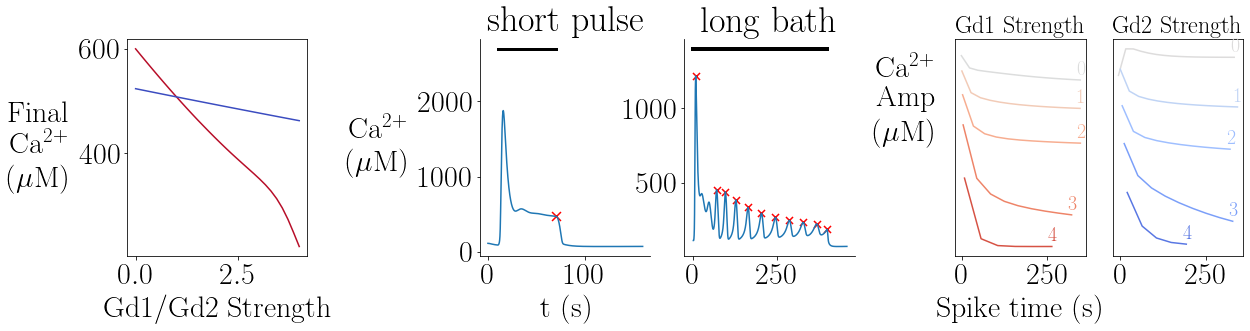

In [81]:
# fig, ax = plt.subplots(2, 2, figsize=(14, 8))
fig = plt.figure(figsize=(20, 4))
gs = fig.add_gridspec(1, 2, left=0.37, right=0.63)
ax = [fig.add_subplot(gs[i]) for i in range(2)]

cmap = matplotlib.cm.get_cmap('coolwarm')
set_init('poisson')
cfg.input_start = 10
cfg.input_max = 0.4
cfg.input_duration = 60
cfg.kd1 = 0.02
cfg.kd2 = 0.6
cfg.v_delta = 0.01
run_experiment(t_f=160)
#example plots
ax[0].plot(cfg.t, cfg.c*1000)
ts = [20, 50, 70]
max_t = cfg.t[np.argmax(cfg.c)]
max_c = np.max(cfg.c*1000)
idx = np.array([np.argmax(cfg.t > t) for t in ts])
slope1 = slope_at_index(idx[0])
slope2 = slope_at_index(idx[1])
decayed_c = cfg.c[idx[2]]*1000
ax[0].scatter([cfg.t[idx[2]]], [decayed_c], c='red', marker='x', s=80)
h1 = 1
h2 = 3
t1 = cfg.t[idx[0]]
t2 = cfg.t[idx[1]]
c1 = cfg.c[idx[0]]
c2 = cfg.c[idx[1]]
# ax[1].plot([t1-h1, t1+h1], [c1*1000-slope1*h1*1000, c1*1000+slope1*h1*1000], c='red', linewidth=4)
# ax[0].plot([t2-h2, t2+h2], [c2-slope2*h2, c2+slope2*h2], c='red', linewidth=4)
ax[0].plot([10, 70], [2700, 2700], c='k', linewidth=3)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
# ax[0].set_xticks([])
# ax[0].set_yticks([])

#Example calcium trace
set_init('poisson')
cfg.input_max = 0.15
cfg.oscillation_on_duration = 400
cfg.oscillation_off_duration = 60
cfg.num_oscillations = 2
cfg.kd1 = 0.02
cfg.kd2 = 2.6
cfg.v_delta = 0.005
run_experiment('oscillation', t_f=460, max_step=0.1)
first_t = 0
idx = np.argmax(cfg.t > first_t)
peaks = scipy.signal.find_peaks(cfg.c[idx:])[0] + idx
ax[1].plot(cfg.t, cfg.c * 1000)
ax[1].plot([0, 400], [1400, 1400], 'k', linewidth=4)
# ax[1].plot([460, 860], [1400, 1400], 'k', linewidth=4)
peaks = [peaks[0]] + [peaks[i] for i in range(3, len(peaks))]
ax[1].scatter(cfg.t[peaks], cfg.c[peaks]*1000, marker='x', color='red', s=50)
# ax[1].set_xticks([])
# ax[1].set_yticks([])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

ax[0].set_ylabel('Ca$^{2+}$ \n ($\mu$M)', rotation=0, labelpad=40, va='center')
ax[0].set_xlabel('t (s)')

ax[0].set_title('short bath')
ax[1].set_title('long bath')

#bottom left summary plot
gs2 = fig.add_gridspec(1, 1, right=0.25)
ax1 = fig.add_subplot(gs2[0])

values = pickle.load(open('data/plot_data/plateau_falloff_summary', 'rb'))
cond_types = ['kd1', 'kd2']
labels = ['Gd1', 'Gd2']
colors = [cmap(0.99), cmap(0)]
slider = np.linspace(0, 4, 30)
for i, typ in enumerate(cond_types):
    data = np.array(values[typ]).T
    ax1.plot(slider, data[3]*1000, label=labels[i], c=colors[i])
ax1.set_xlabel('Gd1/Gd2 Strength')
ax1.set_ylabel('Final \n Ca$^{2+}$ \n ($\mu$M)', rotation=0, ha='center', va='center', labelpad=40)


#bottom right summary plots
gs3 = fig.add_gridspec(1, 2, left=0.7)
ax2 = [fig.add_subplot(gs3[0])]
ax2.append(fig.add_subplot(gs3[1], sharey=ax2[0]))
# ax2 = [fig.add_subplot(gs3[i]) for i in range(2)]
values = pickle.load(open('data/plot_data/oscillation_falloff_summary', 'rb'))
ax2[0].set_ylabel('Ca$^{2+}$ \n Amp \n ($\mu$M)', rotation=0, labelpad=50)
ax2[0].set_xlabel('Spike time (s)')

slider = np.linspace(0, 4, 10)
for i, typ in enumerate(['kd1_half_vd', 'kd2_half_vd']):
    for j in range(len(slider)):
        if j%2 == 1:
            continue
        else:
            if i == 0:
                cval = 0.499 + j/20
                color = cmap(cval)
            elif i == 1:
                cval = 0.501 - j/20
                color = cmap(cval)
#             print(cval)
            t_peaks = values[typ][j]['t_peaks'][1:-1] - 500
            c_peaks = values[typ][j]['c_peaks'][1:-1]*1000
            isi = values[typ][j]['isi'][1:-1]
            ax2[i].plot(t_peaks, c_peaks, c=color)
            ax2[i].text(t_peaks[-1] - 10, c_peaks[-1] + 10, int(j / 2), color=color, fontsize=20)
ax2[0].set_title('Gd1 Strength', fontsize=24)
ax2[1].set_title('Gd2 Strength', fontsize=24)
ax2[1].set_yticks([])
            


# plt.tight_layout()
plt.savefig('figures/poster_plots/calcium_falloff_examples', bbox_inches='tight')

In [69]:
slider

array([0.        , 0.44444444, 0.88888889, 1.33333333, 1.77777778,
       2.22222222, 2.66666667, 3.11111111, 3.55555556, 4.        ])

# Stochastic Experiments

Goal here is to figure out how stochastic changes might affect responses to a bath pulse

## Code for underlying stochastic spike trains

Here we use code for poisson spike train which can be modified

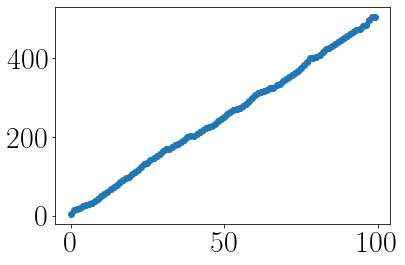

In [14]:
def next_time(rate):
    return -math.log(1 - random.random()) / rate

def generate_train(rate, t_f=300):
    total_time = 0
    spikes = []
    while True:
        nxt = next_time(rate)
        total_time += nxt
        if total_time > t_f:
            return np.array(spikes)
        spikes.append(total_time)
    
    
def exponential_input(t):
    '''
    This function will generate an exponential increase and decay glutamate input
    '''
    input_half = cfg.input_duration / 2
    if(t > cfg.input_start and t <= (cfg.input_start + input_half)):
        return cfg.input_max * (1 - np.exp((t - cfg.input_start) / (t - cfg.input_start - input_half)))
    elif(t > (cfg.input_start + input_half) and t <= (cfg.input_start + cfg.input_duration)):
        return cfg.input_max * np.exp((t - cfg.input_start - input_half) / (t - cfg.input_start - cfg.input_duration))
    else:
        return cfg.input_min
    
    
def exponential_train(t):
    '''
    Get exponential input based on a Poisson spike train
    '''
    if t > np.max(cfg.train):
        idx = len(cfg.train) - 1
    else:
        idx = np.argmax(cfg.train > t) - 1
        if idx < 0:
            return cfg.input_min
#     print(idx)
    t = t - cfg.train[idx]
    return exponential_input(t)
    

## Skipping in response to spritzes

## What does realistic noise look like?

In [41]:
sol = run_experiment()

In [46]:
t, y = get_input_plot('pulse')

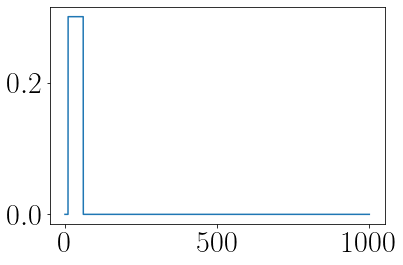

In [47]:
plt.plot(t, y)

In [49]:
f = scipy.interpolate.interp1d(t, y)

In [62]:
y2 = np.clip(y + np.random.normal(scale=0.01, size=y.size), 0, np.inf)

In [67]:
f = scipy.interpolate.interp1d(t, y2)

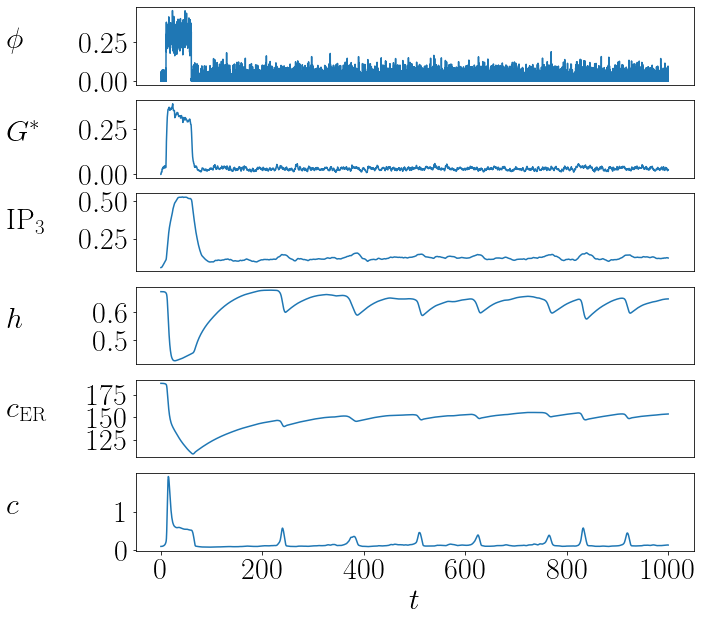

In [3]:
run_experiment('pulse', noise=0.05, max_step=1)
fig, ax = plt.subplots(6, 1, figsize=(10, 10))
plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], ax)

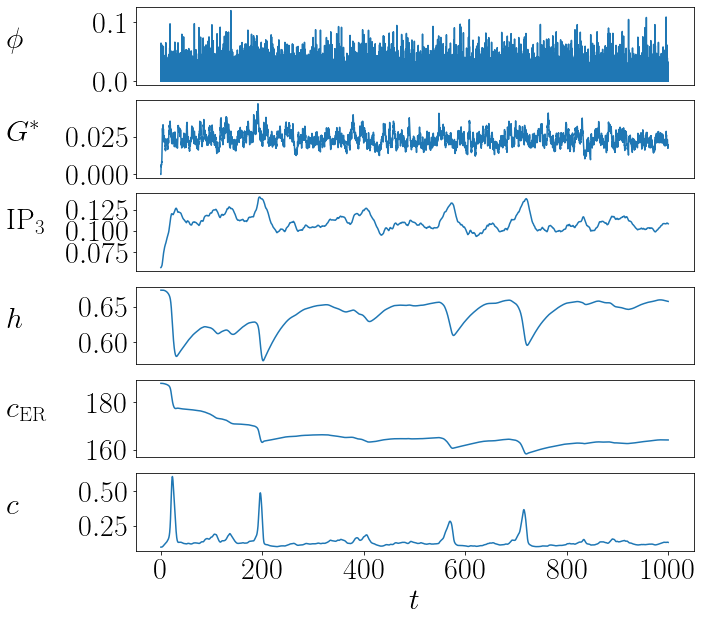

In [25]:
cfg.input_duration=0
run_experiment('pulse', noise=0.03, max_step=0.1)
fig, ax = plt.subplots(6, 1, figsize=(10, 10))
plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], ax)

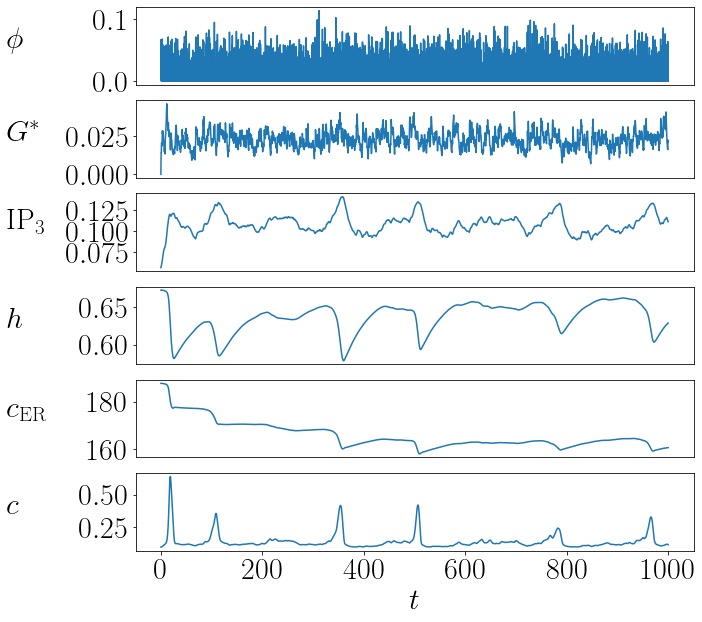

In [27]:
np.random.seed(0)
cfg.input_duration=0
run_experiment('pulse', noise=0.03, max_step=1)
fig, ax = plt.subplots(6, 1, figsize=(10, 10))
plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], ax)

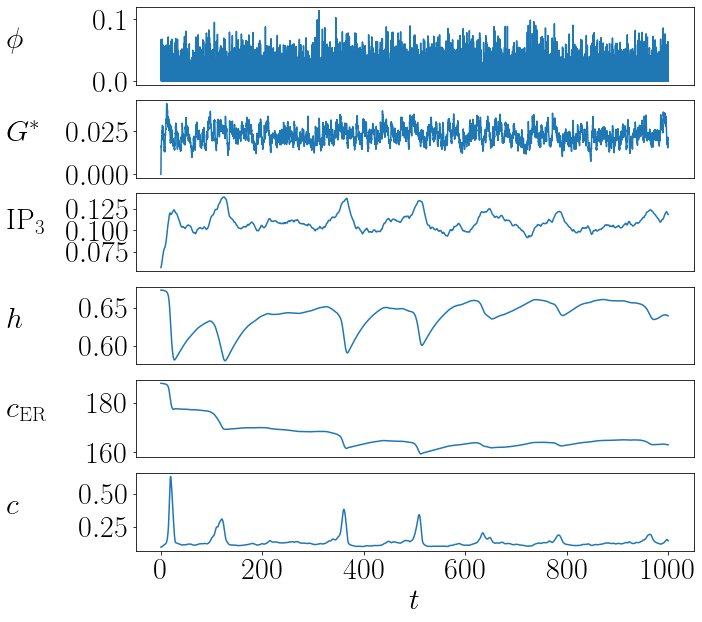

In [29]:
np.random.seed(0)
cfg.input_duration=0
run_experiment('pulse', noise=0.03, max_step=0.1)
fig, ax = plt.subplots(6, 1, figsize=(10, 10))
plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], ax)
plt.savefig('')

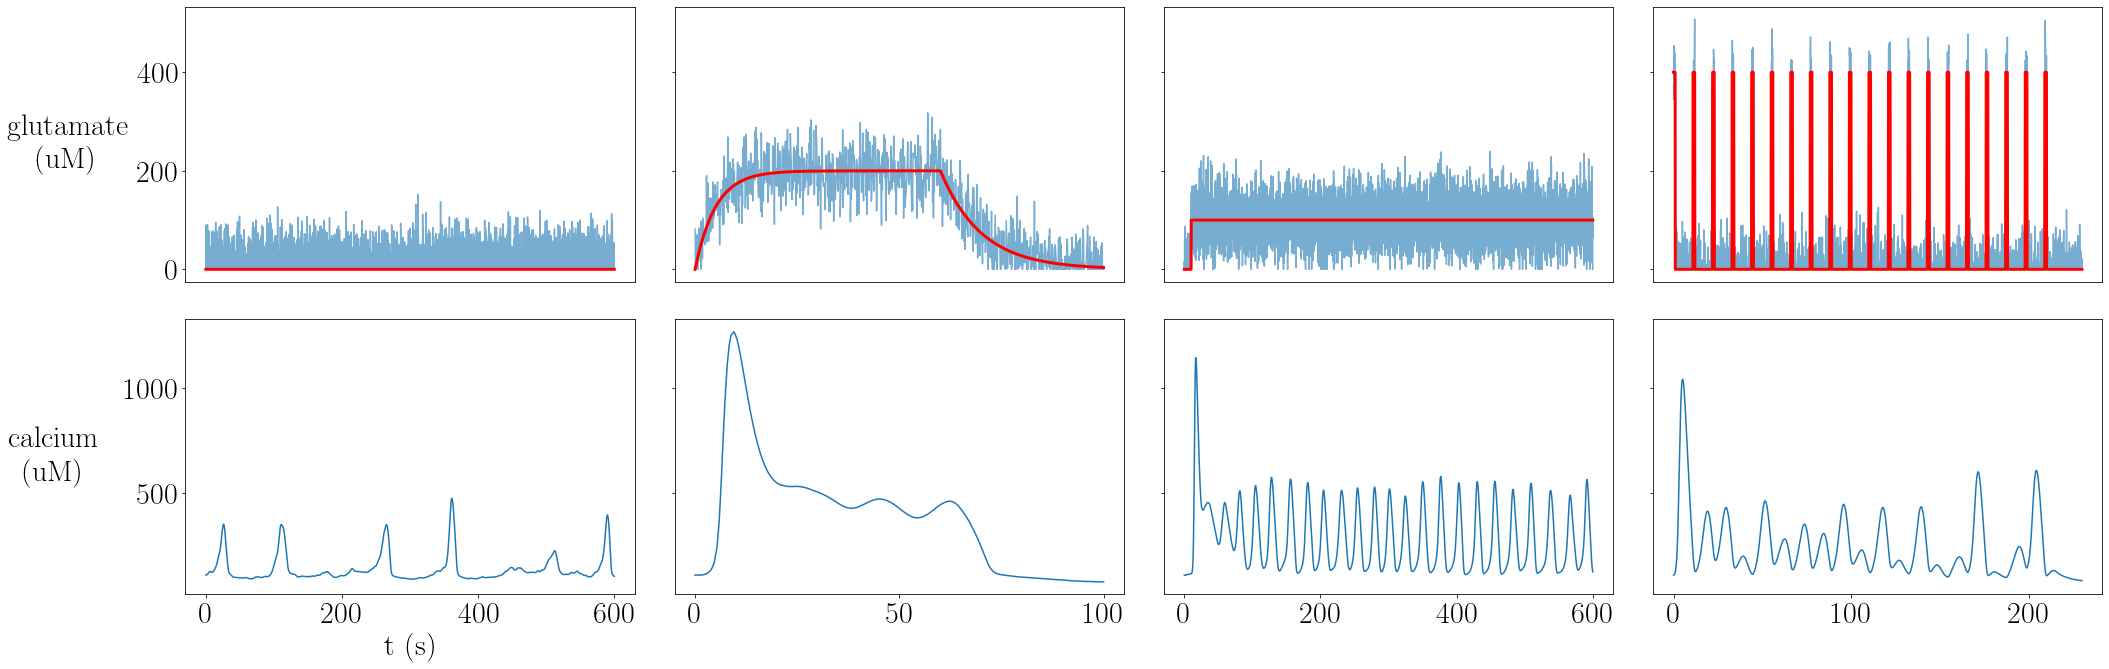

In [142]:
fig, ax = plt.subplots(2, 4, figsize=(30, 10), sharey='row')
set_init('poisson')
noise = 0.04
np.random.seed(0)

input_types = ['pulse', 'curve', 'pulse', 'oscillation']
input_maxes = [0, 0.2, 0.1, 0.4]
input_durations = [600, 60, 600, 1]
t_fs = [600, 100, 600, 230]
max_steps = [1, 1, 1, 0.2]

cfg.A = 0.2
cfg.d_rise = 60
cfg.r_rise = 0.2
cfg.r_decay = 0.1
cfg.d_decay = 20

cfg.oscillation_on_duration = 1
cfg.oscillation_off_duration = 10
cfg.num_oscillations = 20

for i in range(4):
    cfg.input_max = input_maxes[i]
    cfg.input_duration = input_durations[i]
    run_experiment(input_types[i], noise=noise, max_step=max_steps[i], t_f=t_fs[i])
    ax[0, i].plot(cfg.t_input, cfg.glut * 1000, alpha=0.6)
    ax[0, i].set_xticks([])
    t, glut = get_input_plot(input_types[i])
    ax[0, i].plot(t, glut * 1000, c='red', linewidth=3)
    ax[1, i].plot(cfg.t, cfg.c * 1000)
    
ax[0, 0].set_ylabel('glutamate \n (uM)', rotation=0, labelpad=70, verticalalignment='center')
ax[1, 0].set_ylabel('calcium \n (uM)', rotation=0, labelpad=70, verticalalignment='center')
ax[1, 0].set_xlabel('t (s)')
plt.tight_layout()
plt.savefig('figures/poster_plots/noisy_examples', bbox_inches='tight')

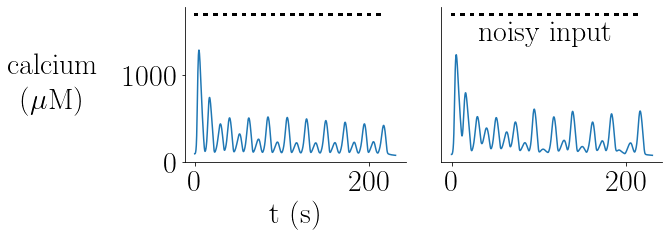

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
set_init()
noise = 0.04
np.random.seed(1)

cfg.input_max = 0.4
cfg.oscillation_on_duration = 1
cfg.oscillation_off_duration = 10
cfg.num_oscillations = 20
spikes = np.array([(cfg.oscillation_on_duration + cfg.oscillation_off_duration)*i for i in range(cfg.num_oscillations)])
run_experiment('oscillation', noise=noise, max_step=0.2, t_f=230)
ax[1].plot(cfg.t, cfg.c*1000)
# ax[1].plot(cfg.t_input, cfg.glut)
cfg.input_max = 0.5
run_experiment('oscillation', max_step=0.2, t_f=230)
ax[0].plot(cfg.t, cfg.c*1000)
for i in range(cfg.num_oscillations):
    ax[0].plot([spikes[i], spikes[i] + cfg.oscillation_on_duration + 1], [1700, 1700], c='k', linewidth=3)
    ax[1].plot([spikes[i], spikes[i] + cfg.oscillation_on_duration + 1], [1600, 1600], c='k', linewidth=3)

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

ax[1].text(30, 1300, 'noisy input')
ax[1].set_yticks([])
ax[0].set_ylabel('calcium \n ($\mu$M)', rotation=0, labelpad=70, verticalalignment='center')
ax[0].set_xlabel('t (s)')
plt.tight_layout()
plt.savefig('figures/poster_plots/spritz_skips', bbox_inches='tight')

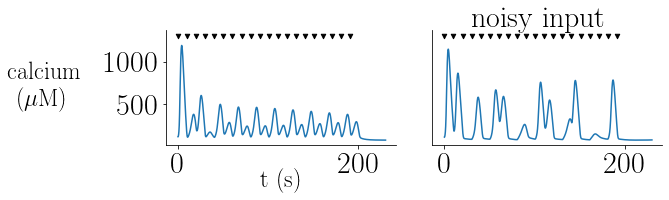

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))
set_init('poisson')
noise = 0.04
np.random.seed(1)

cfg.input_max = 10
cfg.oscillation_on_duration = 0.06
cfg.oscillation_off_duration = 10
cfg.num_oscillations = 20
spikes = np.array([(cfg.oscillation_on_duration + cfg.oscillation_off_duration)*i for i in range(cfg.num_oscillations)])
run_experiment('oscillation', noise=noise, max_step=0.02, t_f=230)
ax[1].plot(cfg.t, cfg.c*1000)
# ax[1].plot(cfg.t_input, cfg.glut)
# cfg.input_max = 0.5
run_experiment('oscillation', max_step=0.02, t_f=230)
ax[0].plot(cfg.t, cfg.c*1000)
# for i in range(cfg.num_oscillations):
#     ax[0].plot([spikes[i], spikes[i] + cfg.oscillation_on_duration + 1], [1700, 1700], c='k', linewidth=3)
#     ax[1].plot([spikes[i], spikes[i] + cfg.oscillation_on_duration + 1], [1600, 1600], c='k', linewidth=3)

ax[0].scatter(spikes, np.full(len(spikes), 1300), marker='v', c='k', s=20)
ax[1].scatter(spikes, np.full(len(spikes), 1300), marker='v', c='k', s=20)

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

ax[1].text(30, 1400, 'noisy input')
ax[1].set_yticks([])
ax[0].set_ylabel('calcium \n ($\mu$M)', rotation=0, labelpad=60, verticalalignment='center', fontsize=24)
ax[0].set_xlabel('t (s)', fontsize=24, labelpad=-10)
plt.tight_layout()
plt.savefig('figures/poster_plots/spritz_skips2', bbox_inches='tight')

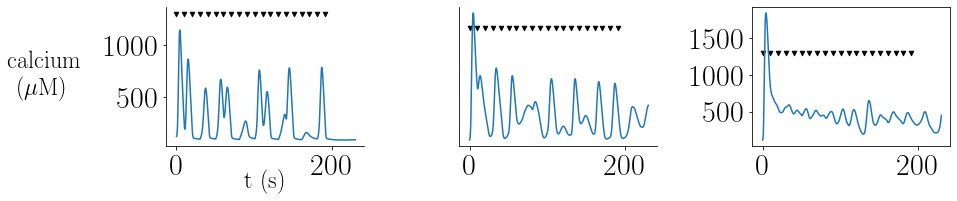

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(14, 3.5))
set_init('poisson')
noises = [0.04, 0.4, 1]
np.random.seed(1)

cfg.input_max = 10
cfg.oscillation_on_duration = 0.06
cfg.oscillation_off_duration = 10
cfg.num_oscillations = 20
spikes = np.array([(cfg.oscillation_on_duration + cfg.oscillation_off_duration)*i for i in range(cfg.num_oscillations)])
for i, noise in enumerate(noises):
    run_experiment('oscillation', noise=noises[i], max_step=0.02, t_f=230)
    ax[i].plot(cfg.t, cfg.c*1000)
    ax[i].scatter(spikes, np.full(len(spikes), 1300), marker='v', c='k', s=20)


ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

# ax[1].text(30, 1400, 'noisy input')
ax[1].set_yticks([])
ax[0].set_ylabel('calcium \n ($\mu$M)', rotation=0, labelpad=60, verticalalignment='center', fontsize=24)
ax[0].set_xlabel('t (s)', fontsize=24, labelpad=-10)
plt.tight_layout()
# plt.savefig('figures/poster_plots/spritz_skips2', bbox_inches='tight')

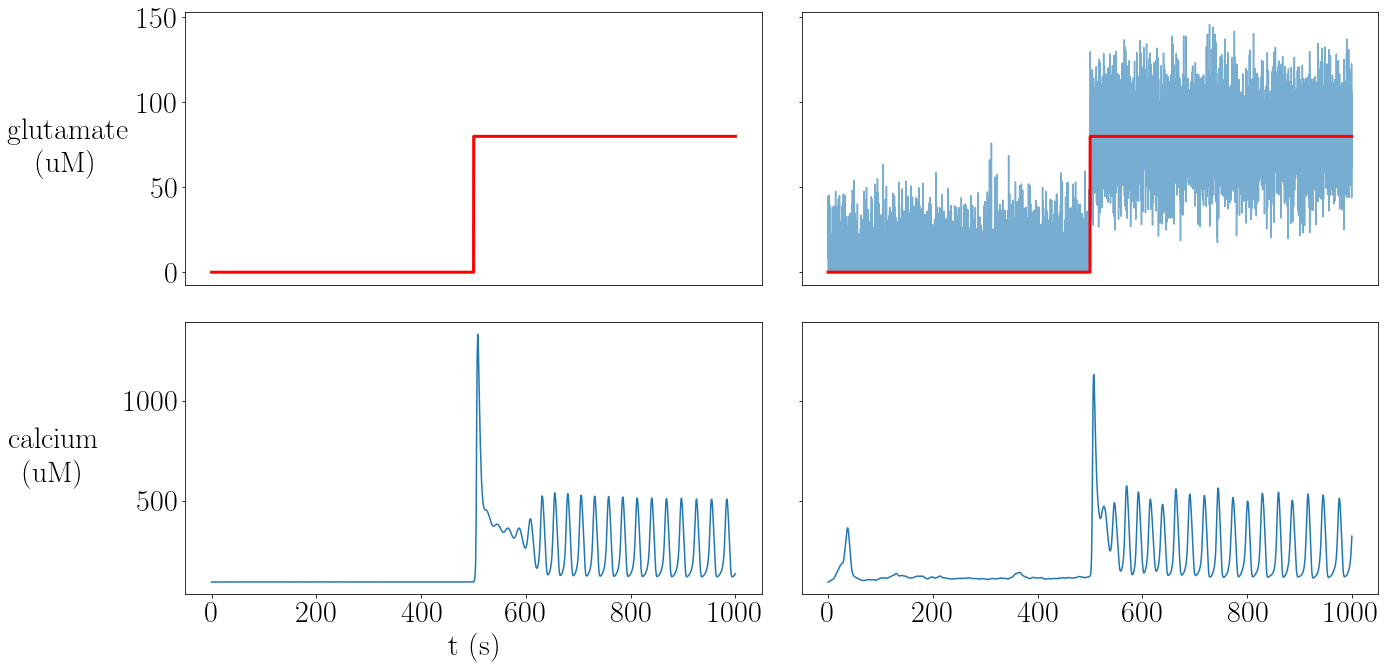

In [83]:
set_init()
fig, ax = plt.subplots(2, 2, figsize=(20, 10), sharey='row')
np.random.seed(0)
noises = [False, 0.02]

t_f = 1000
cfg.input_max = 0.08
cfg.input_duration = 500
cfg.input_start = 500


for i in range(2):
    run_experiment(noise=noises[i], max_step=1, t_f=1000)
    ax[0, i].plot(cfg.t_input, cfg.glut * 1000, alpha=0.6)
    ax[0, i].set_xticks([])
    t, glut = get_input_plot('pulse')
    ax[0, i].plot(t, glut * 1000, c='red', linewidth=3)
    ax[1, i].plot(cfg.t, cfg.c * 1000)
    
ax[0, 0].set_ylabel('glutamate \n (uM)', rotation=0, labelpad=70, verticalalignment='center')
ax[1, 0].set_ylabel('calcium \n (uM)', rotation=0, labelpad=70, verticalalignment='center')
ax[1, 0].set_xlabel('t (s)')

plt.tight_layout()
plt.savefig('figures/poster_plots/noise_recover_delay', bbox_inches='tight')

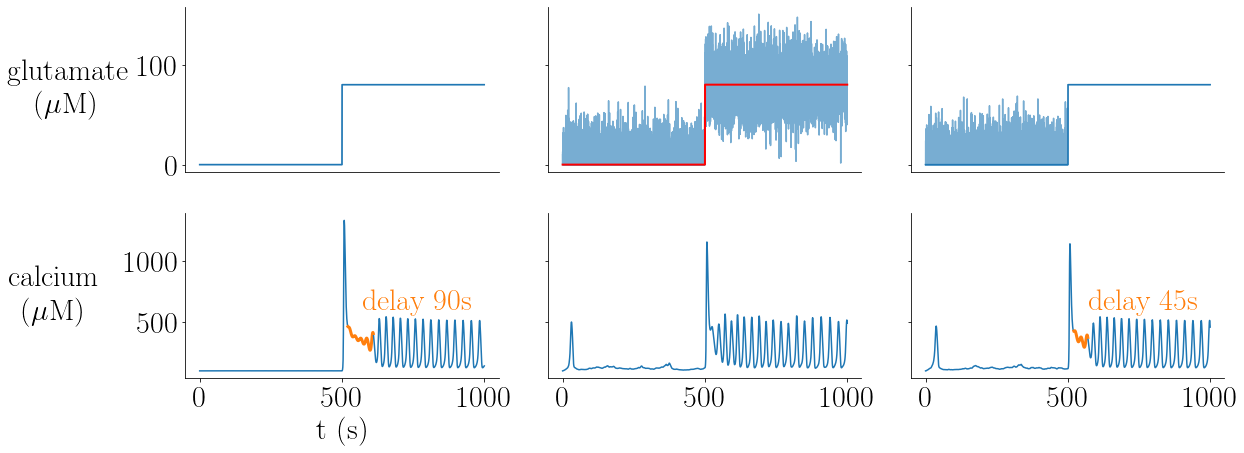

In [45]:
set_init()
fig, ax = plt.subplots(2, 3, figsize=(18, 7), sharey='row')
np.random.seed(42)
noises = [False, 0.02]

t_f = 1000
cfg.input_max = 0.08
cfg.input_duration = 500
cfg.input_start = 500


for i in range(3):
    if i == 2:
        run_experiment(noise=noises[1], max_step=1, t_f=500)
#         print([cfg.c[-1], cfg.c_tot[-1], cfg.h[-1], cfg.p[-1], cfg.Gstar[-1], 
#             cfg.Gd1[-1], cfg.Gd2[-1], cfg.lamb[-1]])
        continue_experiment(max_step=1, t_cont=500)
    else:
        run_experiment(noise=noises[i], max_step=1, t_f=1000)
    ax[0, i].plot(cfg.t_input, cfg.glut * 1000, alpha=0.6)
    ax[0, i].set_xticks([])
    t, glut = get_input_plot('pulse')
    
    if i == 1:
        ax[1, i].plot(cfg.t, cfg.c * 1000, c=color_cycle[0])
        ax[0, i].plot(t, glut * 1000, c='red', linewidth=2)

    if i == 0:
        t_break1 = 520
        t_break2 = 610
        t_idx1 = np.argmax(cfg.t > t_break1)
        t_idx2 = np.argmax(cfg.t > t_break2)
        ax[1, i].plot(cfg.t[:t_idx1], cfg.c[:t_idx1]*1000, c=color_cycle[0])
        ax[1, i].plot(cfg.t[t_idx1:t_idx2], cfg.c[t_idx1:t_idx2]*1000, c=color_cycle[1], linewidth=3)
        ax[1, i].plot(cfg.t[t_idx2:], cfg.c[t_idx2:]*1000, c=color_cycle[0])
        ax[0, i].plot(t, glut * 1000, c=color_cycle[0])
        
    if i == 2:
        t_break1 = 520
        t_break2 = 570
        t_idx1 = np.argmax(cfg.t > t_break1)
        t_idx2 = np.argmax(cfg.t > t_break2)
        ax[1, i].plot(cfg.t[:t_idx1], cfg.c[:t_idx1]*1000, c=color_cycle[0])
        ax[1, i].plot(cfg.t[t_idx1:t_idx2], cfg.c[t_idx1:t_idx2]*1000, c=color_cycle[1], linewidth=3)
        ax[1, i].plot(cfg.t[t_idx2:], cfg.c[t_idx2:]*1000, c=color_cycle[0])
        ax[0, i].plot(t, glut * 1000, c=color_cycle[0])
        
    ax[0, i].spines['top'].set_visible(False)
    ax[0, i].spines['right'].set_visible(False)
    ax[1, i].spines['top'].set_visible(False)
    ax[1, i].spines['right'].set_visible(False)
    
# run_experiment(noise=noises[1], max_step=1, t_f=500)
# continue_experiment(max_step=1, t_cont=500)


ax[1, 0].text(t_break1+50, 600, 'delay 90s', c=color_cycle[1])
ax[1, 2].text(t_break1+50, 600, 'delay 45s', c=color_cycle[1])   
ax[0, 0].set_ylabel('glutamate \n ($\mu$M)', rotation=0, labelpad=70, verticalalignment='center')
ax[1, 0].set_ylabel('calcium \n ($\mu$M)', rotation=0, labelpad=70, verticalalignment='center')
ax[1, 0].set_xlabel('t (s)')

plt.tight_layout()
plt.savefig('figures/poster_plots/noise_recover_delay', bbox_inches='tight')

# Diversity of calcium response types

In [163]:
def diversity_barchart(data, ylim=60, ax=None, legend=True):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 10))
        
    num_sp = len(data[data['response_type'] == 'SP'])
    num_pl = len(data[data['response_type'] == 'PL'])
    num_mp = len(data[data['response_type'] == 'MP'])
    num_ll = len(data[data['response_type'] == 'LL'])
    bar_counts = np.array([num_sp, num_pl, num_mp, num_ll])
    scale = np.sum(bar_counts)
    bar_counts = bar_counts / scale * 100
    
    colors = []
    tick_labels = []
    for response in diversity_colors:
        colors.append(diversity_colors[response])
        tick_labels.append(response)
#     colors = ['#2b8bfb', '#040404', '#7e3838', '#90a0b5']
    edge_colors = ['#152c4c', '#4c4c4c', '#403232', '#a49c9c']
#     tick_labels = ['SP', 'PL', 'MP', 'LL']
    ax.bar([0, 1, 2, 3], bar_counts, 0.995, color=colors, edgecolor=edge_colors, tick_label=tick_labels)
    
    if ax is not None:
        ax.set_xlim([-1, 4])
        ax.set_xticks([])
        ax.set_ylim([0, ylim])
        ax.set_yticks(np.arange(0, ylim+1, 20))
    else:
        ax.xlim([-1, 4])
        ax.xticks([])
        ax.ylim([0, ylim])
        ax.yticks(np.arange(0, ylim+1, 20))
    
    for i in range(len(bar_counts)):
        s = str(round(bar_counts[i], 1)) + '\%'
        ax.text(i, bar_counts[i] + 1, s ,horizontalalignment='center')
        
    if legend:
        handles = [plt.Rectangle((0,0), 1, 1, color=colors[i]) for i in range(4)]
        ax.legend(handles, tick_labels)

diversity_colors = {
#     'SP': '#5dbcd2', #blue
    'SP': '#2b8bfb',
    'PL': 'black',
    'MP': '#b11b1a', #maroon
    'LL': '#cbcae6' #grey
}

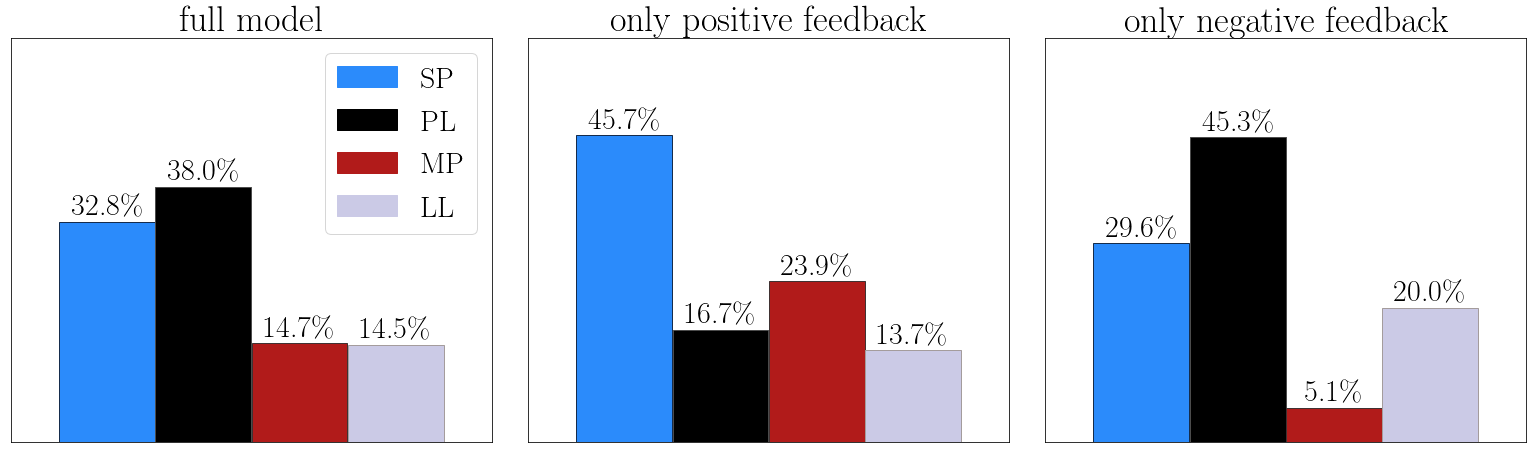

In [175]:
fig, ax = plt.subplots(1, 3, figsize=(22, 7))
file_names = ['glut_kp30_km10_ct_0.8', 'glut_kp30_km10_ct_0.8_negoff', 'glut_kp30_km10_ct_0.8_posoff']
titles = ['full model', 'only positive feedback', 'only negative feedback']

for i, file in enumerate(file_names):
    results = pd.read_pickle('data/ca_diversity/' + file)
    legend = (i == 0)
    diversity_barchart(results, ax=ax[i], legend=legend)
    ax[i].set_yticks([])
    ax[i].set_title(titles[i])
    
plt.tight_layout()
plt.savefig('figures/poster_plots/diversity_barcharts', bbox_inches='tight')
